In [80]:
import cv2,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from poe.bulk.predictions import *
from itertools import groupby
from pathlib import Path 
from poe.bulk.image_cutter import *
import hashlib
from collections import defaultdict
import easyocr
from Levenshtein.StringMatcher import StringMatcher
from poe.ninja import retrieve_prices
from poe.valuation import own_valuations
from poe.div_cards.rules import *

display = pd.options.display

display.max_columns = 1000
display.max_rows = 10000
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
plt.style.use('dark_background')
%matplotlib inline

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [2]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
valuations=own_valuations()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
https://poe.ninja/api/data/itemoverview Scarab 200
https://poe.ninja/api/data/currencyoverview Fragment 200
https://poe.ninja/api/data/currencyoverview Currency 200
https://poe.ninja/api/data/itemoverview Scarab 200
https://poe.ninja/api/data/itemoverview Oil 200
https://poe.ninja/api/data/itemoverview Fossil 200
https://poe.ninja/api/data/itemoverview Resonator 200
https://poe.ninja/api/data/itemoverview Prophecy 200
https://poe.ninja/api/data/itemoverview Incubator 200
https://poe.ninja/api/data/itemoverview UniqueMap 200
https://poe.ninja/api/data/itemoverview UniqueJewel 200
https://poe.ninja/api/data/itemoverview UniqueFlask 200
https://poe.ninja/api/data/itemoverview UniqueArmour 200
https://poe.ninja/api/data/itemoverview UniqueWeapon 200
https://poe.ninja/api/data/itemoverview UniqueAccessory 200
https://poe.ninja/api/data/itemoverview Essence 200
https://poe.ninja/api/data/itemover

In [3]:
def parse_numbers(img):
    assert img.shape[0]*img.shape[1]>0
    cols_of_interest=[1,6,8,11,13,14,19,21,24,26]

    try:
        frags=cut_image_to_frags(img)
    except Exception as e: 
        print(f'could not be processed:{e}')
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        raise

    results=defaultdict(dict)
    for col in cols_of_interest:
        for row,frag in enumerate(frags[col]):
            _frag=normalize_frag(frag,target=(32,80))
#             plt.figure()
#             plt.imshow(_frag)
#             plt.show()
            result = predict_wrapper(_frag)
#             input(f'{result} next?')
            results[col][row]=result.replace('..','9.')
    return results
def parse_text(img,reader):
    assert img.shape[0]*img.shape[1]>0
    cols_of_interest=[4,17]
    try:
        frags=cut_image_to_frags(img)
    except Exception as e: 
        print(f'{path,img_hash} could not be processed:{e}')
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        raise
    results=defaultdict(dict)
    for col in cols_of_interest:
        
        for row,frag in enumerate(frags[col]):
            result=reader.readtext(frag)
            if result:
                results[col][row]=result[0][1]
    return results

/Users/swozny/work/poe/venv/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1      6      8      11    13  14 19   21    24    26
0   4    130    117    468   2.9  16  4  3.6  57.6  0.36
1   2  28.86  25.97  51.94  0.32  41  1  0.9  36.9  0.23
2   2     19   17.1   34.2  0.21  10  3  2.7    27  0.17
3  28      1    0.9   25.2  0.16   5  5  4.5  22.5  0.14
4   2     11    9.9   19.8  0.12  20  1  0.9    18  0.11

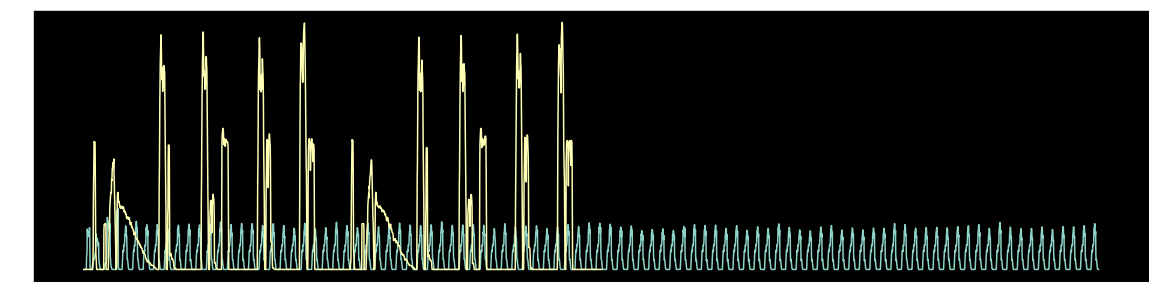

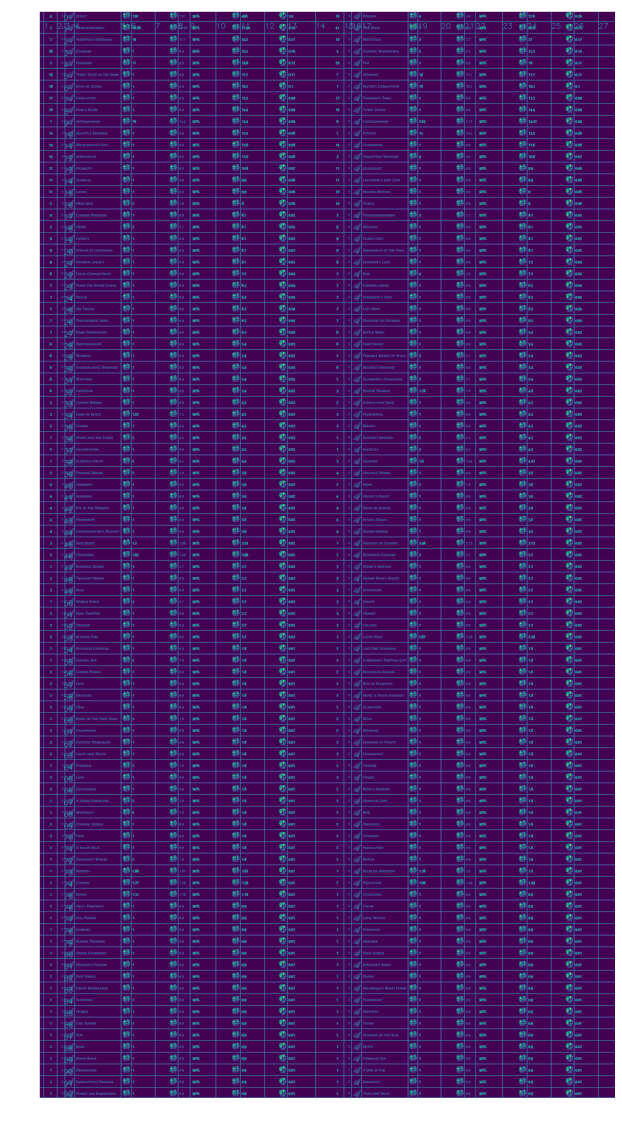

In [4]:
path='poe/bulk/data/tabs/unknown (34).png'

img=cv2.imread(path)
results=parse_numbers(img)
numbers=pd.DataFrame(results)
numbers.head()

4                    17
0                Scout              Disdain
1        Dementophobia             Her Mask
2  Ambitlous ObSEsSLon             Wretched
3              GAMBLER  CHaotyc Dispositlon
4              Hoarder                  THE

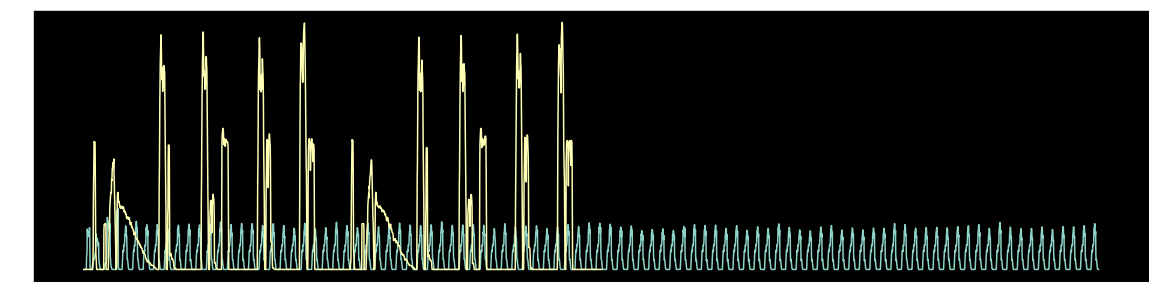

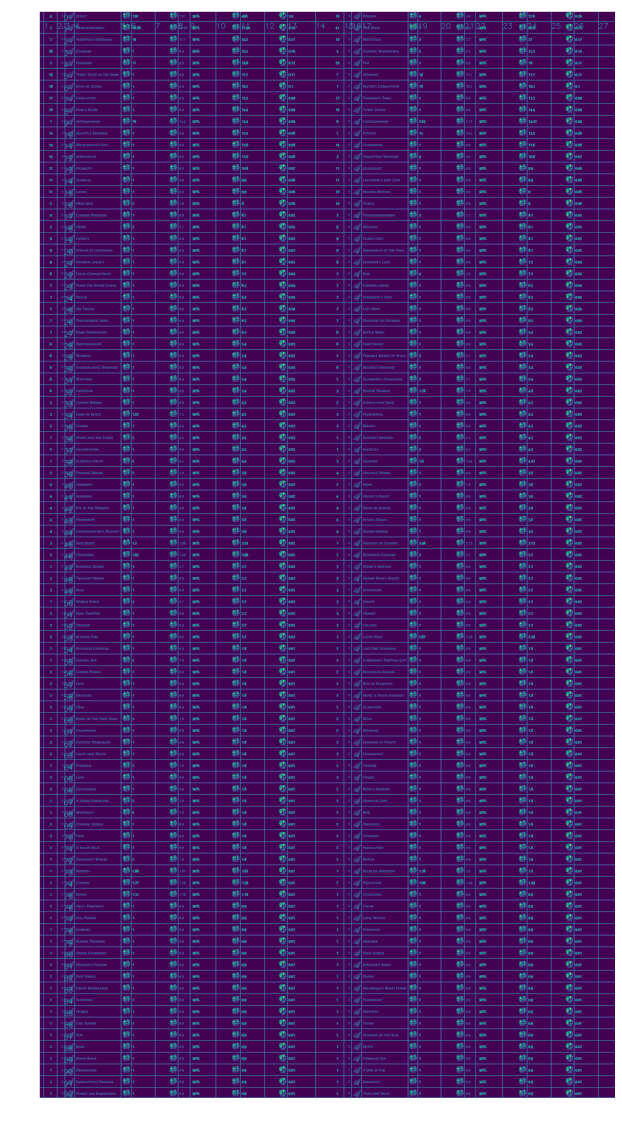

In [5]:
img=cv2.imread(path)
strings=pd.DataFrame(parse_text(img, reader))
strings.head()

In [6]:
prices=retrieve_prices()

https://poe.ninja/api/data/currencyoverview Fragment 200
https://poe.ninja/api/data/currencyoverview Currency 200
https://poe.ninja/api/data/itemoverview Scarab 200
https://poe.ninja/api/data/itemoverview Oil 200
https://poe.ninja/api/data/itemoverview Fossil 200
https://poe.ninja/api/data/itemoverview Resonator 200
https://poe.ninja/api/data/itemoverview Prophecy 200
https://poe.ninja/api/data/itemoverview Incubator 200
https://poe.ninja/api/data/itemoverview UniqueMap 200
https://poe.ninja/api/data/itemoverview UniqueJewel 200
https://poe.ninja/api/data/itemoverview UniqueFlask 200
https://poe.ninja/api/data/itemoverview UniqueArmour 200
https://poe.ninja/api/data/itemoverview UniqueWeapon 200
https://poe.ninja/api/data/itemoverview UniqueAccessory 200
https://poe.ninja/api/data/itemoverview Essence 200
https://poe.ninja/api/data/itemoverview DeliriumOrb 200
https://poe.ninja/api/data/itemoverview DivinationCard 200
https://poe.ninja/api/data/itemoverview Map 200
https://poe.ninja/ap

In [7]:

def map_read_to_ninja(read_from_picture, prices):
    
    raw=str(read_from_picture).lower()
    augmented=[f'the {raw}',f'{raw} scarab',raw]
    asd = max([(StringMatcher(seq1=candidate, seq2=str(y).lower()).ratio(), y, read_from_picture) for y in prices for candidate in augmented])[1]
    return asd
from functools import partial
strings_processed=strings.applymap(partial(map_read_to_ninja,prices=prices))
strings_processed.head()

4                    17
0            The Scout              Disdain
1        Dementophobia             Her Mask
2  Ambitious Obsession         The Wretched
3          The Gambler  Chaotic Disposition
4          The Hoarder           The Throne

In [8]:
df=numbers.join(strings_processed)
df=df[sorted(df.columns)].rename({1:'quantity',4:'name',6:'price',8:'asking_price',11:'total_chaos',13:'total_exalt',14:'quantity',17:'name',19:'price',21:'asking_price',24:'total_chaos',26:'total_exalt'},axis=1)
left=df.iloc[:,int(len(df.columns)/2):]
right=df.iloc[:,:int(len(df.columns)/2)]
df=pd.concat([left,right],ignore_index=True,axis=0)
df=df[df.price!='']
df['total_chaos']=df.total_chaos.astype(float)
df=df.set_index('name').astype('float')
df['total_chaos']=df.quantity*df.asking_price
print(df['total_chaos'].sum())
df.head()

1532.9399999999998


quantity  price  asking_price  total_chaos  total_exalt
name                                                                        
Disdain                  16.0    4.0           3.6         57.6         0.36
Her Mask                 41.0    1.0           0.9         36.9         0.23
The Wretched             10.0    3.0           2.7         27.0         0.17
Chaotic Disposition       5.0    5.0           4.5         22.5         0.14
The Throne               20.0    1.0           0.9         18.0         0.11

In [9]:
df['lookup']=df.index.map(xxxmap_div_card_name)
df=df.join(pd.Series(valuations,name='valuation'),on='lookup').drop(['total_exalt','total_chaos','lookup'],axis=1)
df['valuation']=df['valuation'].fillna(df.price)
df=df.rename({'price':'ninja'},axis=1)
df.head()

quantity  ninja  asking_price  valuation
name                                                         
Disdain                  16.0    4.0           3.6   7.789263
Her Mask                 41.0    1.0           0.9   0.000000
The Wretched             10.0    3.0           2.7   3.000000
Chaotic Disposition       5.0    5.0           4.5   0.000000
The Throne               20.0    1.0           0.9   1.000000

In [10]:
df['own']=df.quantity*df.valuation
df['their']=df.quantity*df.asking_price
df['ratio']=df.their/df.own
df.sort_values('own',ascending=False).query('ratio<0.7')

quantity   ninja  asking_price   valuation  \
name                                                                   
The Scout                      4.0  130.00        117.00  183.720638   
Disdain                       16.0    4.00          3.60    7.789263   
The Tinkerer's Table          17.0    1.00          0.90    5.276000   
Terrible Secret of Space       2.0    3.00          2.70   19.411667   
Society's Remorse             15.0    1.00          0.90    1.954625   
Last Hope                      7.0    1.00          0.90    3.315790   
The Obscured                   5.0    2.00          1.80    4.390570   
Humility                      12.0    1.00          0.90    1.479368   
The Risk                       2.0    4.00          3.60    6.666667   
The Offering                   2.0    1.00          0.90    6.516667   
No Traces                      7.0    1.00          0.90    1.724371   
Emperor's Luck                 8.0    1.00          0.90    1.493878   
The Spark and the Flame        1.0    5.00          4.50   10.000000   
Desperate Crusade              1.0    3.00          2.70    9.703333   
Vanity                         3.0    1.00          0.90    1.479368   
Emperor of Purity              2.0    1.00          0.90    1.902044   
More is Never Enough           2.0    1.00          0.90    1.827500   
The Cacophony                  2.0    1.00          0.90    1.678125   
The Porcupine                  1.0    1.66          1.49    2.219052   
The Bones                      1.0    1.31          1.18    2.166667   
The Innocent                   1.0    1.00          0.90    1.432112   

                                 own   their     ratio  
name                                                    
The Scout                 734.882551  468.00  0.636836  
Disdain                   124.628211   57.60  0.462175  
The Tinkerer's Table       89.692000   15.30  0.170584  
Terrible Secret of Space   38.823333    5.40  0.139092  
Society's Remorse          29.319375   13.50  0.460446  
Last Hope                  23.210530    6.30  0.271429  
The Obscured               21.952852    9.00  0.409970  
Humility                   17.752415   10.80  0.608368  
The Risk                   13.333333    7.20  0.540000  
The Offering               13.033333    1.80  0.138107  
No Traces                  12.070599    6.30  0.521929  
Emperor's Luck             11.951027    7.20  0.602459  
The Spark and the Flame    10.000000    4.50  0.450000  
Desperate Crusade           9.703333    2.70  0.278255  
Vanity                      4.438104    2.70  0.608368  
Emperor of Purity           3.804089    1.80  0.473175  
More is Never Enough        3.655000    1.80  0.492476  
The Cacophony               3.356250    1.80  0.536313  
The Porcupine               2.219052    1.49  0.671458  
The Bones                   2.166667    1.18  0.544615  
The Innocent                1.432112    0.90  0.628442

In [11]:
print((df.quantity*df.valuation).sum())
(df.quantity*df.valuation).sort_values(ascending=False)

1609.4701105531167


name
The Scout                    734.882551
Disdain                      124.628211
The Tinkerer's Table          89.692000
Dementophobia                 70.811483
Terrible Secret of Space      38.823333
Ambitious Obsession           38.000000
The Wretched                  30.000000
Society's Remorse             29.319375
The Hoarder                   26.792593
Last Hope                     23.210530
The Obscured                  21.952852
The Throne                    20.000000
The Aspirant                  19.000000
Keeper's Corruption           18.000000
Humility                      17.752415
The Astromancer               16.000000
The Patient                   15.000000
The Risk                      13.333333
The Offering                  13.033333
No Traces                     12.070599
The Forgotten Treasure        12.000000
Emperor's Luck                11.951027
The Cartographer              10.714200
The Spark and the Flame       10.000000
Desperate Crusade              9.70

In [12]:
(df.quantity*df.valuation-df.quantity*df.asking_price).sum()

76.53011055311663

In [13]:
(df.quantity*df.ninja).sum()/(df.quantity*df.valuation).sum()

1.058286195457612

In [14]:
valuations['The Artist']

KeyError: 'The Artist'

In [ ]:
df=df.set_index('name').join(scarab_values.set_index('name'),rsuffix='own')
(df.quantity.astype('float')*df.valuation.astype('float')).sum()

In [ ]:
gems = [item for price in prices.values() for item in price if item["type"] == "SkillGem"]
relevant_gems = [
    gem
    for gem in gems
    if any(qual in gem["name"] for qual in ALT_QUALITY)
    if gem["variant"] == '20/20'
]
values = pd.Series({gem['name']:gem["chaosValue"] for gem in relevant_gems})

In [ ]:
from pprint import pprint
pprint(valuations)

In [89]:
gems = [item for price in prices.values() for item in price if item["type"] == "SkillGem"]
relevant_gems = [
    gem
    for gem in gems
    if "Support" in gem["name"]
    if not "wakened" in gem["name"]
    if gem['sparkline']['data']
    if not gem.get('corrupted')
    if gem['variant']=='1'
]


In [122]:
df=pd.DataFrame(relevant_gems)
df=df.query('"Phantasmal" not in name')
df['quality']=df.name.str.startswith('Anomalous')|df.name.str.startswith('Divergent')
df.loc[df.quality==False,'quality']='Superior'
df.loc[df.quality==True,'quality']=df[df.quality==True].name.str.split().str[0]
df['basegem']=df.name.str.replace('Anomalous','').str.replace('Divergent','').str.replace('Phantasmal','').str.strip()

df.head()

id                                      name  \
0  61239              Anomalous Nightblade Support   
1  61979                  Anomalous Pierce Support   
2  62063  Divergent Cast when Damage Taken Support   
3  61459             Divergent Inspiration Support   
4  61103        Increased Critical Strikes Support   

                                                icon  levelRequired variant  \
0  https://web.poecdn.com/gen/image/WzI1LDE0LHsiZ...             62       1   
1  https://web.poecdn.com/gen/image/WzI1LDE0LHsiZ...             60       1   
2  https://web.poecdn.com/gen/image/WzI1LDE0LHsiZ...             38       1   
3  https://web.poecdn.com/gen/image/WzI1LDE0LHsiZ...             62       1   
4  https://web.poecdn.com/gen/image/WzI1LDE0LHsiZ...             64       1   

   itemClass                                          sparkline  \
0          4  {'data': [0, 17.65, 10.12, 21.26, 22.75, 23.06...   
1          4  {'data': [0, 8.99, -3.3, 7.0, 10.01, 12.51, 13...   
2          4  {'data': [0, -1.04, 1.09, -7.81, 5.53, -3.57, ...   
3          4  {'data': [0, -3.36, -1.18, -3.24, -5.26, -3.16...   
4          4  {'data': [0, 0, 0, 0, 0, 0, 0], 'totalChange': 0}   

                              lowConfidenceSparkline implicitModifiers  \
0  {'data': [0, 17.65, 10.12, 21.26, 22.75, 23.06...                []   
1  {'data': [0, 8.99, -3.3, 7.0, 10.01, 12.51, 13...                []   
2  {'data': [0, -1.04, 1.09, -7.81, 5.53, -3.57, ...                []   
3  {'data': [0, -3.36, -1.18, -3.24, -5.26, -3.16...                []   
4  {'data': [0, 0, 0, 0, 0, 0, 0], 'totalChange': 0}                []   

                                   explicitModifiers flavourText  gemLevel  \
0  [{'text': 'Supported Skills grant Elusive on C...                    16   
1  [{'text': 'Projectiles from Supported Skills P...                    17   
2  [{'text': 'This Gem can only Support Skill Gem...                     1   
3  [{'text': 'Supported Skills have (25-43)% redu...                    16   
4  [{'text': 'Supported Skills have (60-132)% inc...                    18   

   chaosValue  exaltedValue  count  \
0      810.25          5.00      7   
1       20.00          0.12     43   
2     1752.41         10.81     10   
3      632.00          3.90     14   
4        1.00          0.01     99   

                                    detailsId  listingCount      type  \
0              anomalous-nightblade-support-1            17  SkillGem   
1                  anomalous-pierce-support-1           145  SkillGem   
2  divergent-cast-when-damage-taken-support-1            16  SkillGem   
3             divergent-inspiration-support-1            35  SkillGem   
4        increased-critical-strikes-support-1          3106  SkillGem   

   gemQuality    quality                             basegem  
0         NaN  Anomalous                  Nightblade Support  
1         NaN  Anomalous                      Pierce Support  
2         NaN  Divergent      Cast when Damage Taken Support  
3         NaN  Divergent                 Inspiration Support  
4         NaN   Superior  Increased Critical Strikes Support

In [118]:
sub=df.query('basegem=="Cast when Damage Taken Support"')

In [124]:
qual_map={'Superior':50,'Anomalous':100,'Divergent':20}
df['weight']=df.quality.map(qual_map)

In [192]:
def trans(df):

#     return pd.DataFrame((df['chaosValue'].sum() - df['chaosValue'])/(len(df)-1))
    result=((df.chaosValue*df.weight).sum() - df['chaosValue']*df.weight)/(df['weight'].sum()-df['weight'])
    return pd.DataFrame(result)
df['mean']=df.groupby(['basegem','variant'])[['chaosValue','weight']].apply(trans)-prices['Secondary Regrading Lens'][0]['chaosValue']
df.sort_values('mean',ascending=False)

id                                              name  \
265  60975                                Nightblade Support   
12    2640                                 Enlighten Support   
8    45225                       Anomalous Enlighten Support   
75   61423                      Divergent Nightblade Support   
79   61511          Anomalous Cast when Damage Taken Support   
195  61220                    Cast when Damage Taken Support   
54   61156                               Inspiration Support   
273  60988               Anomalous Void Manipulation Support   
7    61307                                  Efficacy Support   
64   61398                    Anomalous Melee Splash Support   
332  61385                            Feeding Frenzy Support   
253  61618                   Anomalous Minion Damage Support   
40   61431                        Divergent Efficacy Support   
299  61415                             Mirage Archer Support   
104  61886                  Divergent Feeding Frenzy Support   
43   61059              Greater Multiple Projectiles Support   
365  60918                              Melee Splash Support   
19   61607                     Anomalous Inspiration Support   
91   61512        Anomalous Power Charge On Critical Support   
323  60934                         Void Manipulation Support   
114  61366                   Divergent Mirage Archer Support   
90   61682    Divergent Greater Multiple Projectiles Support   
3    61459                     Divergent Inspiration Support   
162  60999                             Minion Damage Support   
194  61344                               Minion Life Support   
25    2610                                   Empower Support   
176  61420                  Power Charge On Critical Support   
120  61622                     Divergent Minion Life Support   
10   44848                         Anomalous Empower Support   
256  62103                     Anomalous Multistrike Support   
53    2647                                   Enhance Support   
201  61217                           Withering Touch Support   
131  61321                       Anomalous Pulverise Support   
130  61581                  Anomalous Ancestral Call Support   
2    62063          Divergent Cast when Damage Taken Support   
305  61112                              Arcane Surge Support   
197  61446                               Multistrike Support   
111  61305                 Divergent Withering Touch Support   
57   61535             Anomalous Additional Accuracy Support   
186  61295                                 Pulverise Support   
203  61237                                   Barrage Support   
172  61068                                 Arrogance Support   
317  61243                            Ancestral Call Support   
349  61402                            Faster Casting Support   
56   61370                         Divergent Barrage Support   
24   61337                       Divergent Arrogance Support   
11   61554                    Divergent Arcane Surge Support   
198  61158                               Hypothermia Support   
391  61018                       Additional Accuracy Support   
229  62140                  Divergent Faster Casting Support   
386  61277                              Minion Speed Support   
315  61016                               Second Wind Support   
18   61793                    Divergent Melee Splash Support   
159  60941                       Damage on Full Life Support   
154  61196                       Concentrated Effect Support   
406  61168                                 Onslaught Support   
46   45566                         Anomalous Enhance Support   
367  61455                            Multiple Traps Support   
99   61816                    Anomalous Arcane Surge Support   
279  61141                            Faster Attacks Support   
59   61541                       Anomalous Bonechill Support   
72   61354                 Anomalous Wit

In [88]:
df

id                                              name  \
0     48367                      Anomalous Nightblade Support   
1     61239                      Anomalous Nightblade Support   
2     45729                      Anomalous Nightblade Support   
3     46657                          Anomalous Pierce Support   
4     44828                          Anomalous Pierce Support   
5     61979                          Anomalous Pierce Support   
6     49195          Divergent Cast when Damage Taken Support   
7     45619          Divergent Cast when Damage Taken Support   
8     62063          Divergent Cast when Damage Taken Support   
9     45045                     Divergent Inspiration Support   
10    46545                     Divergent Inspiration Support   
11    61459                     Divergent Inspiration Support   
12     2873                Increased Critical Strikes Support   
13     2974                Increased Critical Strikes Support   
14     3235                Increased Critical Strikes Support   
15    61103                Increased Critical Strikes Support   
16    49872             Divergent Additional Accuracy Support   
17    62165             Divergent Additional Accuracy Support   
18    46016             Divergent Additional Accuracy Support   
19    47074             Anomalous Concentrated Effect Support   
20    45420             Anomalous Concentrated Effect Support   
21    61491             Anomalous Concentrated Effect Support   
22     3727                                  Efficacy Support   
23     2908                                  Efficacy Support   
24     2810                                  Efficacy Support   
25    61307                                  Efficacy Support   
26    46580                       Anomalous Enlighten Support   
27    45225                       Anomalous Enlighten Support   
28    46857             Divergent Infused Channelling Support   
29    45751             Divergent Infused Channelling Support   
30    62260             Divergent Infused Channelling Support   
31    46157                         Anomalous Empower Support   
32    44848                         Anomalous Empower Support   
33    46686                    Divergent Arcane Surge Support   
34    45217                    Divergent Arcane Surge Support   
35    61554                    Divergent Arcane Surge Support   
36     3023                                 Enlighten Support   
37     2983                                 Enlighten Support   
38     2640                                 Enlighten Support   
39    47395        Divergent Power Charge On Critical Support   
40    45465        Divergent Power Charge On Critical Support   
41    61910        Divergent Power Charge On Critical Support   
42    47681                  Anomalous Faster Casting Support   
43    61500                  Anomalous Faster Casting Support   
44    45467                  Anomalous Faster Casting Support   
45    48024                   Divergent Minion Damage Support   
46    45271                   Divergent Minion Damage Support   
47    61996                   Divergent Minion Damage Support   
48    47047                            Divergent Rage Support   
49    46281                            Divergent Rage Support   
50    46951      Anomalous Increased Critical Strikes Support   
51    62727      Anomalous Increased Critical Strikes Support   
52    44961      Anomalous Increased Critical Strikes Support   
53    61742      Anomalous Increased Critical Strikes Support   
54    45385               Divergent Void Manipulation Support   
55    61790               Divergent Void Manipulation Support   
56    46082               Divergent Void Manipulation Support   
57    47464                    Divergent Melee Splash Support   
58    61793                    Divergent Melee Splash Support   
59    44780                    Divergent Melee Splash Support   
60    45792                     Anomalous In

In [41]:
(df.set_index(['name','variant']).chaosValue-df.set_index(['name','variant']).variant_mean).sort_values()

SyntaxError: unexpected EOF while parsing (<ipython-input-41-c8aa41c7820f>, line 4)

In [39]:
(df.set_index(['name','variant']).chaosValue).sort_values()

name                                      variant
Impending Doom Support                    1             0.56
Additional Accuracy Support               1             0.61
Elemental Army Support                    1             0.70
Blind Support                             1             0.73
Close Combat Support                      1             0.79
                                                      ...   
Divergent Rage Support                    1/20       1382.72
                                          20/20      1458.45
Divergent Cast when Damage Taken Support  1          1752.41
                                          1/20       1773.61
                                          20/20      2041.67
Name: chaosValue, Length: 1336, dtype: float64

In [40]:
prices['Secondary Regrading Lens']

[{'currencyTypeName': 'Secondary Regrading Lens',
  'pay': {'id': 0,
   'league_id': 116,
   'pay_currency_id': 134,
   'get_currency_id': 1,
   'sample_time_utc': '2021-12-27T23:59:12.2911672Z',
   'count': 7,
   'value': 0.006270214285714286,
   'data_point_count': 1,
   'includes_secondary': False,
   'listing_count': 26},
  'receive': {'id': 0,
   'league_id': 116,
   'pay_currency_id': 1,
   'get_currency_id': 134,
   'sample_time_utc': '2021-12-27T23:59:12.2911672Z',
   'count': 169,
   'value': 240.73666905,
   'data_point_count': 1,
   'includes_secondary': True,
   'listing_count': 531},
  'paySparkLine': {'data': [0, 0.21, 7.16, -4.58, -18.95, -20.3, -23.61],
   'totalChange': -23.61},
  'receiveSparkLine': {'data': [0,
    -0.84,
    -24.77,
    -24.8,
    -24.69,
    -24.69,
    -24.77],
   'totalChange': -24.77},
  'chaosEquivalent': 237.51,
  'lowConfidencePaySparkLine': {'data': [0,
    0.21,
    7.16,
    -4.58,
    -18.95,
    -20.3,
    -23.61],
   'totalChange': -23.

In [247]:
import random
outcomes={
    'Superior':['Divergent']*20+['Anomalous']*100,
        'Anomalous':['Divergent']*20+['Superior']*50,
         }
def until_div(state):
    cost=0
    while not state=='Divergent':
        state=random.choice(outcomes[state])
        cost+=240
    return cost
from statistics import mean
s=mean(until_div('Superior') for _ in range(10000))
a=mean(until_div('Anomalous') for _ in range(10000))
print(f'Cost starting from Superior:{s}, Cost starting from Anomalous{a}, Diff:{s-a}')

Cost starting from Superior:1084.968, Cost starting from Anomalous1015.584, Diff:69.38400000000013


In [302]:
df=pd.read_html('''<table class="mb-0 table table-dark table-hover table-striped table-bordered filters tablesorter tablesorter-default tablesorterbb6374d755f38" role="grid"><thead><tr role="row" class="tablesorter-headerRow"><th data-column="0" class="tablesorter-header tablesorter-headerUnSorted" tabindex="0" scope="col" role="columnheader" aria-disabled="false" unselectable="on" aria-sort="none" aria-label="Item: No sort applied, activate to apply an ascending sort" style="user-select: none;"><div class="tablesorter-header-inner">Item</div></th><th data-column="1" class="tablesorter-header tablesorter-headerUnSorted" tabindex="0" scope="col" role="columnheader" aria-disabled="false" unselectable="on" aria-sort="none" aria-label="Type: No sort applied, activate to apply an ascending sort" style="user-select: none;"><div class="tablesorter-header-inner">Type</div></th><th data-column="2" class="tablesorter-header tablesorter-headerUnSorted" tabindex="0" scope="col" role="columnheader" aria-disabled="false" unselectable="on" aria-sort="none" aria-label="Stats: No sort applied, activate to apply an ascending sort" style="user-select: none;"><div class="tablesorter-header-inner">Stats</div></th><th data-column="3" class="tablesorter-header tablesorter-headerUnSorted" tabindex="0" scope="col" role="columnheader" aria-disabled="false" unselectable="on" aria-sort="none" aria-label="Weight: No sort applied, activate to apply an ascending sort" style="user-select: none;"><div class="tablesorter-header-inner">Weight</div></th></tr></thead><tbody aria-live="polite" aria-relevant="all"><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Fireball" href="/us/Fireball">Fireball</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Fireball" href="/us/Fireball">Fireball</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Area of Effect<br><span class="mod-value">(0–40)</span>% reduced Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Fireball" href="/us/Fireball">Fireball</a></td><td>Divergent </td><td><span class="mod-value">(-40–0)</span>% more Damage with Ignite<br><span class="mod-value">(0–60)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>40</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Fireball" href="/us/Fireball">Fireball</a></td><td>Phantasmal </td><td><span class="mod-value">(0–5)</span>% chance to Debilitate Enemies for 1 second on Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Fireball" href="/us/Vaal_Fireball">Vaal Fireball</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Nova" href="/us/Ice_Nova">Ice Nova</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Nova" href="/us/Ice_Nova">Ice Nova</a></td><td>Anomalous </td><td><span class="mod-value">(0–30)</span>% increased Damage with Hits against Chilled Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Nova" href="/us/Ice_Nova">Ice Nova</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Nova" href="/us/Ice_Nova">Ice Nova</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% increased Effect of Chill</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Ice+Nova" href="/us/Vaal_Ice_Nova">Vaal Ice Nova</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Leap+Slam" href="/us/Leap_Slam">Leap Slam</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Stun Duration on enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Leap+Slam" href="/us/Leap_Slam">Leap Slam</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Leap+Slam" href="/us/Leap_Slam">Leap Slam</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Leap+Slam" href="/us/Leap_Slam">Leap Slam</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Charged+Dash" href="/us/Charged_Dash">Charged Dash</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Charged+Dash" href="/us/Charged_Dash">Charged Dash</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% more Movement Speed</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Charged+Dash" href="/us/Charged_Dash">Charged Dash</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased travel distance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Flurry" href="/us/Blade_Flurry">Blade Flurry</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Flurry" href="/us/Blade_Flurry">Blade Flurry</a></td><td>Anomalous </td><td>Final Flurry has <span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Flurry" href="/us/Blade_Flurry">Blade Flurry</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Elemental Damage while Channelling</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sweep" href="/us/Sweep">Sweep</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sweep" href="/us/Sweep">Sweep</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sweep" href="/us/Sweep">Sweep</a></td><td>Divergent </td><td><span class="mod-value">(0–2)</span>% chance to deal Triple Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sweep" href="/us/Sweep">Sweep</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Knockback Distance</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ground+Slam" href="/us/Ground_Slam">Ground Slam</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect<br><span class="mod-value">(0–20)</span>% increased Stun Duration on enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ground+Slam" href="/us/Ground_Slam">Ground Slam</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ground+Slam" href="/us/Ground_Slam">Ground Slam</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Area of Effect<br><span class="mod-value">(0–40)</span>% reduced angle</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Ground+Slam" href="/us/Vaal_Ground_Slam">Vaal Ground Slam</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect<br><span class="mod-value">(0–20)</span>% increased Stun Duration on enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cleave" href="/us/Cleave">Cleave</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cleave" href="/us/Cleave">Cleave</a></td><td>Anomalous </td><td><span class="mod-value">+(0–20)</span> Life gained for each Enemy hit by your Attacks</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cleave" href="/us/Cleave">Cleave</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect while not Dual Wielding</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cleave" href="/us/Cleave">Cleave</a></td><td>Phantasmal </td><td><span class="mod-value">(0–100)</span>% chance to Destroy Corpses on Kill</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shield+Charge" href="/us/Shield_Charge">Shield Charge</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shield+Charge" href="/us/Shield_Charge">Shield Charge</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shield+Charge" href="/us/Shield_Charge">Shield Charge</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% more Damage with Hits at Maximum Charge Distance</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Enduring+Cry" href="/us/Enduring_Cry">Enduring Cry</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Enduring+Cry" href="/us/Enduring_Cry">Enduring Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Enduring+Cry" href="/us/Enduring_Cry">Enduring Cry</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% reduced Cooldown Recovery Rate<br><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Double+Strike" href="/us/Double_Strike">Double Strike</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Double+Strike" href="/us/Double_Strike">Double Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Elemental Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Double+Strike" href="/us/Double_Strike">Double Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to Maim on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Double+Strike" href="/us/Vaal_Double_Strike">Vaal Double Strike</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lacerate" href="/us/Lacerate">Lacerate</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lacerate" href="/us/Lacerate">Lacerate</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Physical Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lacerate" href="/us/Lacerate">Lacerate</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Bleeding Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Elemental+Hit" href="/us/Elemental_Hit">Elemental Hit</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Elemental Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Elemental+Hit" href="/us/Elemental_Hit">Elemental Hit</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Elemental+Hit" href="/us/Elemental_Hit">Elemental Hit</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Immortal+Call" href="/us/Immortal_Call">Immortal Call</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Immortal+Call" href="/us/Immortal_Call">Immortal Call</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Immortal+Call" href="/us/Immortal_Call">Immortal Call</a></td><td>Divergent </td><td><span class="mod-value">(0–2)</span>% less Elemental Damage taken per Endurance Charge removed<br><span class="mod-value">(-2–0)</span>% less Physical Damage taken per Endurance Charge removed</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Immortal+Call" href="/us/Vaal_Immortal_Call">Vaal Immortal Call</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Dual+Strike" href="/us/Dual_Strike">Dual Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Critical Strike Chance<br><span class="mod-value">+(0–10)</span>% to Critical Strike Multiplier</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Dual+Strike" href="/us/Dual_Strike">Dual Strike</a></td><td>Anomalous </td><td><span class="mod-value">+(0–5)</span> to Melee Strike Range</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Dual+Strike" href="/us/Dual_Strike">Dual Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–100)</span>% increased Damage with Hits and Ailments against Enemies that are on Full Life</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Dual+Strike" href="/us/Dual_Strike">Dual Strike</a></td><td>Phantasmal </td><td>Deals <span class="mod-value">(0–10)</span>% more added damage</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Whirling+Blades" href="/us/Whirling_Blades">Whirling Blades</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Whirling+Blades" href="/us/Whirling_Blades">Whirling Blades</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Whirling+Blades" href="/us/Whirling_Blades">Whirling Blades</a></td><td>Divergent </td><td><span class="mod-value">(0–200)</span>% increased Evasion Rating while Moving</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Frenzy" href="/us/Frenzy">Frenzy</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Frenzy" href="/us/Frenzy">Frenzy</a></td><td>Anomalous </td><td>Fires an additional Projectile</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Frenzy" href="/us/Frenzy">Frenzy</a></td><td>Divergent </td><td>Melee Strikes target <span class="mod-value">(0–1)</span> additional nearby Enemy</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Frenzy" href="/us/Frenzy">Frenzy</a></td><td>Phantasmal </td><td><span class="mod-value">(0–5)</span>% increased Damage with Ailments per Frenzy Charge</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Detonate+Dead" href="/us/Detonate_Dead">Detonate Dead</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Detonate+Dead" href="/us/Detonate_Dead">Detonate Dead</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% of Fire Damage Converted to Chaos Damage</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Detonate+Dead" href="/us/Detonate_Dead">Detonate Dead</a></td><td>Divergent </td><td>Explosion deals <span class="mod-value">(0–80)</span>% increased Damage if the Corpse is Ignited</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Detonate+Dead" href="/us/Vaal_Detonate_Dead">Vaal Detonate Dead</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Area Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Volatile+Dead" href="/us/Volatile_Dead">Volatile Dead</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Volatile+Dead" href="/us/Volatile_Dead">Volatile Dead</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Volatile+Dead" href="/us/Volatile_Dead">Volatile Dead</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Orb Movement Speed</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Unearth" href="/us/Unearth">Unearth</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Unearth" href="/us/Unearth">Unearth</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Physical Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Unearth" href="/us/Unearth">Unearth</a></td><td>Divergent </td><td>Maximum of <span class="mod-value">(0–2)</span> corpses allowed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Unearth" href="/us/Unearth">Unearth</a></td><td>Phantasmal </td><td>Corpses Spawned have <span class="mod-value">(0–40)</span>% increased Maximum Life</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Split+Arrow" href="/us/Split_Arrow">Split Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Split+Arrow" href="/us/Split_Arrow">Split Arrow</a></td><td>Anomalous </td><td>Fires an additional Arrow</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Split+Arrow" href="/us/Split_Arrow">Split Arrow</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Added+Fire+Damage+Support" href="/us/Added_Fire_Damage_Support">Added Fire Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Added+Fire+Damage+Support" href="/us/Added_Fire_Damage_Support">Added Fire Damage Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% reduced Fire Damage<br>Supported Skills have <span class="mod-value">+(0–20)</span>% to Fire Damage over Time Multiplier</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Added+Fire+Damage+Support" href="/us/Added_Fire_Damage_Support">Added Fire Damage Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% of Physical Damage Converted to Fire Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Faster+Attacks+Support" href="/us/Faster_Attacks_Support">Faster Attacks Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Faster+Attacks+Support" href="/us/Faster_Attacks_Support">Faster Attacks Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Faster+Attacks+Support" href="/us/Faster_Attacks_Support">Faster Attacks Support</a></td><td>Divergent </td><td>Bleeding inflicted by Supported Skills deals Damage <span class="mod-value">(0–10)</span>% faster</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Greater+Multiple+Projectiles+Support" href="/us/Greater_Multiple_Projectiles_Support">Greater Multiple Projectiles Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Greater+Multiple+Projectiles+Support" href="/us/Greater_Multiple_Projectiles_Support">Greater Multiple Projectiles Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Life Cost<br>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Mana Cost<br>Supported Skills have <span class="mod-value">(0–10)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Greater+Multiple+Projectiles+Support" href="/us/Greater_Multiple_Projectiles_Support">Greater Multiple Projectiles Support</a></td><td>Divergent </td><td>Projectiles Fired by Supported Skills have <span class="mod-value">(0–20)</span>% increased Projectile spread</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lesser+Multiple+Projectiles+Support" href="/us/Lesser_Multiple_Projectiles_Support">Lesser Multiple Projectiles Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lesser+Multiple+Projectiles+Support" href="/us/Lesser_Multiple_Projectiles_Support">Lesser Multiple Projectiles Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Life Cost<br>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Mana Cost<br>Supported Skills have <span class="mod-value">(0–10)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lesser+Multiple+Projectiles+Support" href="/us/Lesser_Multiple_Projectiles_Support">Lesser Multiple Projectiles Support</a></td><td>Divergent </td><td>Projectiles Fired by Supported Skills have <span class="mod-value">(0–20)</span>% increased Projectile spread</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Faster+Projectiles+Support" href="/us/Faster_Projectiles_Support">Faster Projectiles Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Faster+Projectiles+Support" href="/us/Faster_Projectiles_Support">Faster Projectiles Support</a></td><td>Anomalous </td><td>Projectiles from Supported Skills have <span class="mod-value">(0–60)</span>% chance to Return to you from final target</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Faster+Projectiles+Support" href="/us/Faster_Projectiles_Support">Faster Projectiles Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Added+Cold+Damage+Support" href="/us/Added_Cold_Damage_Support">Added Cold Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Added+Cold+Damage+Support" href="/us/Added_Cold_Damage_Support">Added Cold Damage Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Freeze</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Added+Cold+Damage+Support" href="/us/Added_Cold_Damage_Support">Added Cold Damage Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% of Physical Damage Converted to Cold Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Additional+Accuracy+Support" href="/us/Additional_Accuracy_Support">Additional Accuracy Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Accuracy Rating</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Additional+Accuracy+Support" href="/us/Additional_Accuracy_Support">Additional Accuracy Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">+(0–20)</span>% to Critical Strike Multiplier</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Additional+Accuracy+Support" href="/us/Additional_Accuracy_Support">Additional Accuracy Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–4)</span>% increased Attack damage per 1000 Accuracy Rating</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Area+of+Effect+Support" href="/us/Increased_Area_of_Effect_Support">Increased Area of Effect Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Area Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Area+of+Effect+Support" href="/us/Increased_Area_of_Effect_Support">Increased Area of Effect Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect<br>Supported Skills deal <span class="mod-value">(0–20)</span>% reduced Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Area+of+Effect+Support" href="/us/Increased_Area_of_Effect_Support">Increased Area of Effect Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Added+Lightning+Damage+Support" href="/us/Added_Lightning_Damage_Support">Added Lightning Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Added+Lightning+Damage+Support" href="/us/Added_Lightning_Damage_Support">Added Lightning Damage Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–30)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Added+Lightning+Damage+Support" href="/us/Added_Lightning_Damage_Support">Added Lightning Damage Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% of Physical Damage Converted to Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cold+Snap" href="/us/Cold_Snap">Cold Snap</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cold+Snap" href="/us/Cold_Snap">Cold Snap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Effect of Chill</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cold+Snap" href="/us/Cold_Snap">Cold Snap</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Damage with Hits and Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Cold+Snap" href="/us/Vaal_Cold_Snap">Vaal Cold Snap</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Zombie" href="/us/Raise_Zombie">Raise Zombie</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Minion Movement Speed<br><span class="mod-value">(0–20)</span>% increased Minion Maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Zombie" href="/us/Raise_Zombie">Raise Zombie</a></td><td>Anomalous </td><td>Raised Zombies' Slam Attack has <span class="mod-value">(0–40)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Zombie" href="/us/Raise_Zombie">Raise Zombie</a></td><td>Divergent </td><td>Minions Regenerate <span class="mod-value">(0–2)</span>% of Life per second</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Zombie" href="/us/Raise_Zombie">Raise Zombie</a></td><td>Phantasmal </td><td>Minions gain <span class="mod-value">(0–10)</span>% of Physical Damage as Extra Chaos Damage<br>Minions take Chaos Damage equal to <span class="mod-value">(0–20)</span>% of their Life over one second when Raised</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Caustic+Arrow" href="/us/Caustic_Arrow">Caustic Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Caustic+Arrow" href="/us/Caustic_Arrow">Caustic Arrow</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to inflict Withered for 2 seconds on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Caustic+Arrow" href="/us/Caustic_Arrow">Caustic Arrow</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blood+Rage" href="/us/Blood_Rage">Blood Rage</a></td><td>Superior </td><td><span class="mod-value">(0–5)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blood+Rage" href="/us/Blood_Rage">Blood Rage</a></td><td>Anomalous </td><td>Buff grants <span class="mod-value">(0–2)</span>% chance to gain a Frenzy Charge when you Hit a Unique Enemy</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blood+Rage" href="/us/Blood_Rage">Blood Rage</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–0.4)</span>% of Elemental Attack Damage leeched as Life</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Righteous+Fire" href="/us/Righteous_Fire">Righteous Fire</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Burning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Righteous+Fire" href="/us/Righteous_Fire">Righteous Fire</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Righteous+Fire" href="/us/Righteous_Fire">Righteous Fire</a></td><td>Divergent </td><td>Buff Grants <span class="mod-value">(0–20)</span>% increased Spell Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Righteous+Fire" href="/us/Vaal_Righteous_Fire">Vaal Righteous Fire</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Burning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Discharge" href="/us/Discharge">Discharge</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Elemental Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Discharge" href="/us/Discharge">Discharge</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Discharge" href="/us/Discharge">Discharge</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% chance to deal Damage without removing Charges</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Discharge" href="/us/Discharge">Discharge</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage if three different Charge types removed</td><td>20</td></tr><tr role="row"><td><a data-hover="?t=gem&amp;n=Portal" href="/us/Portal">Portal</a></td><td>Superior </td><td><span class="mod-value">(0–60)</span>% increased Cast Speed</td><td>10000</td></tr><tr role="row"><td><a data-hover="?t=gem&amp;n=Portal" href="/us/Portal">Portal</a></td><td>Anomalous </td><td><span class="mod-value">(0–0.2)</span>% chance to travel to Winding Pier instead while on a Ley Fishing Line</td><td>1</td></tr><tr role="row"><td><a data-hover="?t=gem&amp;n=Vaal+Breach" href="/us/Vaal_Breach">Vaal Breach</a></td><td>Superior </td><td><span class="mod-value">(0–60)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Inspiration+Support" href="/us/Inspiration_Support">Inspiration Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Inspiration Charge Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Inspiration+Support" href="/us/Inspiration_Support">Inspiration Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Inspiration+Support" href="/us/Inspiration_Support">Inspiration Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Mana Cost</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Critical+Strikes+Support" href="/us/Increased_Critical_Strikes_Support">Increased Critical Strikes Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Critical+Strikes+Support" href="/us/Increased_Critical_Strikes_Support">Increased Critical Strikes Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">+(0–5)</span>% to Critical Strike Multiplier</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Critical+Strikes+Support" href="/us/Increased_Critical_Strikes_Support">Increased Critical Strikes Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to gain a Power Charge on Killing Blow</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Critical+Damage+Support" href="/us/Increased_Critical_Damage_Support">Increased Critical Damage Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">+(0–10)</span>% to Critical Strike Multiplier</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Critical+Damage+Support" href="/us/Increased_Critical_Damage_Support">Increased Critical Damage Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Increased+Critical+Damage+Support" href="/us/Increased_Critical_Damage_Support">Increased Critical Damage Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">+(0–15)</span>% Damage over Time Multiplier for Ailments from Critical Strikes</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Knockback+Support" href="/us/Knockback_Support">Knockback Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Knock Enemies Back on hit</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Knockback+Support" href="/us/Knockback_Support">Knockback Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Knockback+Support" href="/us/Knockback_Support">Knockback Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Knockback Distance</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Life+Leech+Support" href="/us/Life_Leech_Support">Life Leech Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage while Leeching Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Life+Leech+Support" href="/us/Life_Leech_Support">Life Leech Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–40)</span>% increased Damage when on Full Life</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Life+Leech+Support" href="/us/Life_Leech_Support">Life Leech Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–100)</span>% increased Maximum Recovery per Life Leech</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mana+Leech+Support" href="/us/Mana_Leech_Support">Mana Leech Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage while Leeching Mana</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mana+Leech+Support" href="/us/Mana_Leech_Support">Mana Leech Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Damage for each 200 Mana you have Spent Recently</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mana+Leech+Support" href="/us/Mana_Leech_Support">Mana Leech Support</a></td><td>Divergent </td><td><span class="mod-value">+(0–4)</span> Mana gained for each Enemy hit by Attacks from Supported Skills</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Added+Chaos+Damage+Support" href="/us/Added_Chaos_Damage_Support">Added Chaos Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Added+Chaos+Damage+Support" href="/us/Added_Chaos_Damage_Support">Added Chaos Damage Support</a></td><td>Anomalous </td><td>Supported Skills Penetrate <span class="mod-value">(0–5)</span>% Chaos Resistance</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Added+Chaos+Damage+Support" href="/us/Added_Chaos_Damage_Support">Added Chaos Damage Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% of Physical Damage Converted to Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Flicker+Strike" href="/us/Flicker_Strike">Flicker Strike</a></td><td>Superior </td><td><span class="mod-value">(0–5)</span>% chance to gain a Frenzy Charge on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Flicker+Strike" href="/us/Flicker_Strike">Flicker Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Flicker+Strike" href="/us/Flicker_Strike">Flicker Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased teleport range</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spark" href="/us/Spark">Spark</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spark" href="/us/Spark">Spark</a></td><td>Anomalous </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spark" href="/us/Spark">Spark</a></td><td>Divergent </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spark" href="/us/Spark">Spark</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% of Lightning Damage Converted to Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Spark" href="/us/Vaal_Spark">Vaal Spark</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Stun+Support" href="/us/Stun_Support">Stun Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–30)</span>% increased Stun Duration on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Stun+Support" href="/us/Stun_Support">Stun Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–4)</span>% chance to double Stun Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Stun+Support" href="/us/Stun_Support">Stun Support</a></td><td>Divergent </td><td>Recover <span class="mod-value">(0–1)</span>% of Life when you Stun an Enemy with Supported Skills</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Spear" href="/us/Ice_Spear">Ice Spear</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Spear" href="/us/Ice_Spear">Ice Spear</a></td><td>Anomalous </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Spear" href="/us/Ice_Spear">Ice Spear</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Cold Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ice+Spear" href="/us/Ice_Spear">Ice Spear</a></td><td>Phantasmal </td><td>Travels <span class="mod-value">(0–20)</span>% reduced distance before changing forms</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Pierce+Support" href="/us/Pierce_Support">Pierce Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Pierce+Support" href="/us/Pierce_Support">Pierce Support</a></td><td>Anomalous </td><td>Projectiles from Supported Skills Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Pierce+Support" href="/us/Pierce_Support">Pierce Support</a></td><td>Divergent </td><td>Projectiles from Supported Skills that have Pierced deal <span class="mod-value">(0–40)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Trap+Support" href="/us/Trap_Support">Trap Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Trap Throwing Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Trap+Support" href="/us/Trap_Support">Trap Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Trap+Support" href="/us/Trap_Support">Trap Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Trap Trigger Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Spectre" href="/us/Raise_Spectre">Raise Spectre</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Spectre" href="/us/Raise_Spectre">Raise Spectre</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Minion Maximum Life<br>Minions deal <span class="mod-value">(0–20)</span>% increased Melee Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Spectre" href="/us/Raise_Spectre">Raise Spectre</a></td><td>Divergent </td><td>Minions have <span class="mod-value">(0–10)</span>% reduced Enemy Stun Threshold</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Raise+Spectre" href="/us/Raise_Spectre">Raise Spectre</a></td><td>Phantasmal </td><td>Minions are Created with maximum Frenzy Charges</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Blow" href="/us/Infernal_Blow">Infernal Blow</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Blow" href="/us/Infernal_Blow">Infernal Blow</a></td><td>Anomalous </td><td>Explosion has <span class="mod-value">(0–20)</span>% chance to apply Uncharged Debuff on Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Blow" href="/us/Infernal_Blow">Infernal Blow</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to Ignite enemies<br><span class="mod-value">(0–60)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Blow" href="/us/Infernal_Blow">Infernal Blow</a></td><td>Phantasmal </td><td><span class="mod-value">(0–80)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Glacial+Hammer" href="/us/Glacial_Hammer">Glacial Hammer</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Duration of Cold Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Glacial+Hammer" href="/us/Glacial_Hammer">Glacial Hammer</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Glacial+Hammer" href="/us/Glacial_Hammer">Glacial Hammer</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Glacial+Hammer" href="/us/Vaal_Glacial_Hammer">Vaal Glacial Hammer</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Duration of Cold Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Wall" href="/us/Frost_Wall">Frost Wall</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Wall" href="/us/Frost_Wall">Frost Wall</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Wall" href="/us/Frost_Wall">Frost Wall</a></td><td>Divergent </td><td>Freezes enemies as though dealing <span class="mod-value">(0–100)</span>% more Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Freezing+Pulse" href="/us/Freezing_Pulse">Freezing Pulse</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Freezing+Pulse" href="/us/Freezing_Pulse">Freezing Pulse</a></td><td>Anomalous </td><td>Deals <span class="mod-value">(0–20)</span>% less Damage<br>Projectiles continuously gain Damage, up to <span class="mod-value">(0–60)</span>% more Damage by the time they dissipate</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Freezing+Pulse" href="/us/Freezing_Pulse">Freezing Pulse</a></td><td>Divergent </td><td>Cannot Pierce Enemies</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Shock+Nova" href="/us/Shock_Nova">Shock Nova</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Shock Duration on enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Shock+Nova" href="/us/Shock_Nova">Shock Nova</a></td><td>Anomalous </td><td>Ring has <span class="mod-value">(0–40)</span>% chance to Shock<br>Ring Shocks as if dealing <span class="mod-value">(0–100)</span>% more Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Shock+Nova" href="/us/Shock_Nova">Shock Nova</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Viper+Strike" href="/us/Viper_Strike">Viper Strike</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed<br><span class="mod-value">(0–10)</span>% increased Poison Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Viper+Strike" href="/us/Viper_Strike">Viper Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Viper+Strike" href="/us/Viper_Strike">Viper Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Viper+Strike" href="/us/Viper_Strike">Viper Strike</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% chance to also Poison a nearby Enemy when you inflict Poison</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Old+Phase+Run" href="/us/Old_Phase_Run">Old Phase Run</a></td><td>Superior </td><td>Buff grants <span class="mod-value">(0–10)</span>% increased Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Old+Phase+Run" href="/us/Old_Phase_Run">Old Phase Run</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Old+Phase+Run" href="/us/Old_Phase_Run">Old Phase Run</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% chance not to replace the Buff when you use a Skill</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Phase+Run" href="/us/Phase_Run">Phase Run</a></td><td>Superior </td><td>Buff grants <span class="mod-value">(0–10)</span>% increased Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Phase+Run" href="/us/Phase_Run">Phase Run</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Phase+Run" href="/us/Phase_Run">Phase Run</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% chance not to replace the Buff when you use a Skill</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Melee+Physical+Damage+Support" href="/us/Melee_Physical_Damage_Support">Melee Physical Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Melee+Physical+Damage+Support" href="/us/Melee_Physical_Damage_Support">Melee Physical Damage Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">+(0–2)</span> to Melee Strike Range</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Melee+Physical+Damage+Support" href="/us/Melee_Physical_Damage_Support">Melee Physical Damage Support</a></td><td>Divergent </td><td>Supported Skills Overwhelm <span class="mod-value">(0–5)</span>% Physical Damage Reduction</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Item+Quantity+Support" href="/us/Item_Quantity_Support">Item Quantity Support</a></td><td>Superior </td><td><span class="mod-value">(0–7)</span>% increased Quantity of Items Dropped by Enemies Slain from Supported Skills</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Item+Rarity+Support" href="/us/Item_Rarity_Support">Item Rarity Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Rarity of Items Dropped by Enemies Slain from Supported Skills</td><td>10000</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Item+Rarity+Support" href="/us/Item_Rarity_Support">Item Rarity Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–2)</span>% chance for Coin Shower on Kill</td><td>1</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Faster+Casting+Support" href="/us/Faster_Casting_Support">Faster Casting Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Faster+Casting+Support" href="/us/Faster_Casting_Support">Faster Casting Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Faster+Casting+Support" href="/us/Faster_Casting_Support">Faster Casting Support</a></td><td>Divergent </td><td>Ignites from Supported Skills deal Damage <span class="mod-value">(0–10)</span>% faster</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Arrow" href="/us/Explosive_Arrow">Explosive Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration<br><span class="mod-value">(0–20)</span>% chance to Ignite enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Arrow" href="/us/Explosive_Arrow">Explosive Arrow</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Arrow" href="/us/Explosive_Arrow">Explosive Arrow</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% less Skill Effect Duration<br>Maximum <span class="mod-value">(0–4)</span> Explosive Arrows stuck in an Enemy</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Temporal+Chains" href="/us/Temporal_Chains">Temporal Chains</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Curse</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Temporal+Chains" href="/us/Temporal_Chains">Temporal Chains</a></td><td>Anomalous </td><td>Curse has <span class="mod-value">(0–40)</span>% increased Doom gain rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Temporal+Chains" href="/us/Temporal_Chains">Temporal Chains</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Curse Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Weakness" href="/us/Elemental_Weakness">Elemental Weakness</a></td><td>Superior </td><td>Cursed enemies have <span class="mod-value">(-5–0)</span>% to Elemental Resistances</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Weakness" href="/us/Elemental_Weakness">Elemental Weakness</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Effect of Curse</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Weakness" href="/us/Elemental_Weakness">Elemental Weakness</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Duration of Elemental Ailments on Cursed enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Warlord%27s+Mark" href="/us/Warlords_Mark">Warlord's Mark</a></td><td>Superior </td><td>Cursed Enemies have a <span class="mod-value">(0–5)</span>% chance to grant an Endurance Charge when Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Warlord%27s+Mark" href="/us/Warlords_Mark">Warlord's Mark</a></td><td>Anomalous </td><td>Cursed enemies take <span class="mod-value">(0–4)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Warlord%27s+Mark" href="/us/Warlords_Mark">Warlord's Mark</a></td><td>Divergent </td><td>Cursed Enemies grant <span class="mod-value">(0–2)</span> Rage Regenerated over 1 second when Stunned</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Punishment" href="/us/Punishment">Punishment</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Curse</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Punishment" href="/us/Punishment">Punishment</a></td><td>Anomalous </td><td>Curse has <span class="mod-value">(0–40)</span>% increased Doom gain rate</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Punishment" href="/us/Punishment">Punishment</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Enfeeble" href="/us/Enfeeble">Enfeeble</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Curse</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Enfeeble" href="/us/Enfeeble">Enfeeble</a></td><td>Anomalous </td><td>Curse has <span class="mod-value">(0–40)</span>% increased Doom gain rate</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Enfeeble" href="/us/Enfeeble">Enfeeble</a></td><td>Divergent </td><td>Curse Skills have <span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Assassin%27s+Mark" href="/us/Assassins_Mark">Assassin's Mark</a></td><td>Superior </td><td>Cursed Enemies have a <span class="mod-value">(0–5)</span>% chance to grant a Power Charge when Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Assassin%27s+Mark" href="/us/Assassins_Mark">Assassin's Mark</a></td><td>Anomalous </td><td>Cursed enemies take <span class="mod-value">(0–4)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Assassin%27s+Mark" href="/us/Assassins_Mark">Assassin's Mark</a></td><td>Divergent </td><td>Hits against Cursed Enemies have <span class="mod-value">+(0–0.2)</span>% to Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Sniper%27s+Mark" href="/us/Snipers_Mark">Sniper's Mark</a></td><td>Superior </td><td>Cursed enemies take <span class="mod-value">(0–5)</span>% increased Damage from Projectile Hits</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Sniper%27s+Mark" href="/us/Snipers_Mark">Sniper's Mark</a></td><td>Anomalous </td><td>Curse Skills have <span class="mod-value">(0–20)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Sniper%27s+Mark" href="/us/Snipers_Mark">Sniper's Mark</a></td><td>Divergent </td><td>Hits on Cursed Enemies have an additional <span class="mod-value">(0–40)</span>% chance to Knockback</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Despair" href="/us/Despair">Despair</a></td><td>Superior </td><td>Cursed enemies take <span class="mod-value">(0–10)</span>% increased Damage from Damage Over Time effects</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Despair" href="/us/Despair">Despair</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Effect of Curse</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Despair" href="/us/Despair">Despair</a></td><td>Divergent </td><td>Spell Hits have <span class="mod-value">(0–10)</span>% chance to Hinder Cursed Enemies with 30% reduced Movement Speed for 4 seconds</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Warp" href="/us/Lightning_Warp">Lightning Warp</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Warp" href="/us/Lightning_Warp">Lightning Warp</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Warp" href="/us/Lightning_Warp">Lightning Warp</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Warp" href="/us/Lightning_Warp">Lightning Warp</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% less Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Warp" href="/us/Vaal_Lightning_Warp">Vaal Lightning Warp</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Skeletons" href="/us/Summon_Skeletons">Summon Skeletons</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Skeletons" href="/us/Summon_Skeletons">Summon Skeletons</a></td><td>Anomalous </td><td>Minions can't be Damaged for <span class="mod-value">(0–2)</span> seconds after being Summoned</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Skeletons" href="/us/Summon_Skeletons">Summon Skeletons</a></td><td>Divergent </td><td>Minions' Attacks have <span class="mod-value">(0–10)</span>% chance to Maim Enemies on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Skeletons" href="/us/Summon_Skeletons">Summon Skeletons</a></td><td>Phantasmal </td><td><span class="mod-value">(0–100)</span>% chance to Summon a Skeleton Archer instead of a Skeleton Warrior</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Summon+Skeletons" href="/us/Vaal_Summon_Skeletons">Vaal Summon Skeletons</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Heavy+Strike" href="/us/Heavy_Strike">Heavy Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Stun Duration on enemies<br><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Heavy+Strike" href="/us/Heavy_Strike">Heavy Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Knockback Distance</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Heavy+Strike" href="/us/Heavy_Strike">Heavy Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–100)</span>% reduced Knockback Distance</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Dominating+Blow" href="/us/Dominating_Blow">Dominating Blow</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Dominating+Blow" href="/us/Dominating_Blow">Dominating Blow</a></td><td>Anomalous </td><td><span class="mod-value">(0–30)</span>% increased Minion Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Dominating+Blow" href="/us/Dominating_Blow">Dominating Blow</a></td><td>Divergent </td><td>Summoned Sentinels have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Dominating+Blow" href="/us/Dominating_Blow">Dominating Blow</a></td><td>Phantasmal </td><td>Maximum <span class="mod-value">(0–2)</span> Summoned Normal Sentinels of Dominance</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Rain+of+Arrows" href="/us/Rain_of_Arrows">Rain of Arrows</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Rain+of+Arrows" href="/us/Rain_of_Arrows">Rain of Arrows</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% chance to fire an additional sequence of arrows</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Rain+of+Arrows" href="/us/Rain_of_Arrows">Rain of Arrows</a></td><td>Divergent </td><td>Fires <span class="mod-value">(0–4)</span> additional Arrows</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Rain+of+Arrows" href="/us/Rain_of_Arrows">Rain of Arrows</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% chance to Maim on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Rain+of+Arrows" href="/us/Vaal_Rain_of_Arrows">Vaal Rain of Arrows</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Concentrated+Effect+Support" href="/us/Concentrated_Effect_Support">Concentrated Effect Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Area Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Concentrated+Effect+Support" href="/us/Concentrated_Effect_Support">Concentrated Effect Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% less Area of Effect</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Concentrated+Effect+Support" href="/us/Concentrated_Effect_Support">Concentrated Effect Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Enemy Stun Threshold</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Damage+Support" href="/us/Minion_Damage_Support">Minion Damage Support</a></td><td>Superior </td><td>Minions from Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Damage+Support" href="/us/Minion_Damage_Support">Minion Damage Support</a></td><td>Anomalous </td><td>Minions from Supported Skills have <span class="mod-value">(0–3)</span>% chance to deal Double Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Damage+Support" href="/us/Minion_Damage_Support">Minion Damage Support</a></td><td>Divergent </td><td>Minions from Supported Skills deal <span class="mod-value">(0–40)</span>% increased Damage with Ailments</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Increased+Duration+Support" href="/us/Increased_Duration_Support">Increased Duration Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Increased+Duration+Support" href="/us/Increased_Duration_Support">Increased Duration Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Life Cost<br>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Mana Cost<br>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Skill Effect Duration</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Increased+Duration+Support" href="/us/Increased_Duration_Support">Increased Duration Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Duration of Ailments on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cold+to+Fire+Support" href="/us/Cold_to_Fire_Support">Cold to Fire Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Cold Damage<br>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cold+to+Fire+Support" href="/us/Cold_to_Fire_Support">Cold to Fire Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% of Cold Damage Converted to Fire Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cold+to+Fire+Support" href="/us/Cold_to_Fire_Support">Cold to Fire Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–60)</span>% increased Damage with Poison</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Combustion+Support" href="/us/Combustion_Support">Combustion Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Combustion+Support" href="/us/Combustion_Support">Combustion Support</a></td><td>Anomalous </td><td>Ignites from Supported Skills deal Damage <span class="mod-value">(0–5)</span>% faster</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Combustion+Support" href="/us/Combustion_Support">Combustion Support</a></td><td>Divergent </td><td>Ignites from Supported Skills deal Damage <span class="mod-value">(0–10)</span>% slower<br>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Speed+Support" href="/us/Minion_Speed_Support">Minion Speed Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Speed+Support" href="/us/Minion_Speed_Support">Minion Speed Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% reduced Minion Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Speed+Support" href="/us/Minion_Speed_Support">Minion Speed Support</a></td><td>Divergent </td><td>Minions from Supported Skills have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Life+Support" href="/us/Minion_Life_Support">Minion Life Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–15)</span>% increased Minion maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Life+Support" href="/us/Minion_Life_Support">Minion Life Support</a></td><td>Anomalous </td><td>Minions Regenerate <span class="mod-value">(0–1)</span>% of Life per second</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minion+Life+Support" href="/us/Minion_Life_Support">Minion Life Support</a></td><td>Divergent </td><td>Minions from Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage while on Full Life</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Elemental+Damage+with+Attacks+Support" href="/us/Elemental_Damage_with_Attacks_Support">Elemental Damage with Attacks Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Elemental Damage with Attack Skills</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Elemental+Damage+with+Attacks+Support" href="/us/Elemental_Damage_with_Attacks_Support">Elemental Damage with Attacks Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% chance to Freeze, Shock and Ignite</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Elemental+Damage+with+Attacks+Support" href="/us/Elemental_Damage_with_Attacks_Support">Elemental Damage with Attacks Support</a></td><td>Divergent </td><td><span class="mod-value">(0–0.5)</span>% of Elemental Damage Leeched as Mana</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bloodlust+Support" href="/us/Bloodlust_Support">Bloodlust Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Damage against Bleeding Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bloodlust+Support" href="/us/Bloodlust_Support">Bloodlust Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Crush for 2 seconds on Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bloodlust+Support" href="/us/Bloodlust_Support">Bloodlust Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to refresh Bleeding Duration on Hit</td><td>5</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Life+Gain+on+Hit+Support" href="/us/Life_Gain_on_Hit_Support">Life Gain on Hit Support</a></td><td>Superior </td><td><span class="mod-value">+(0–10)</span> Life gained for each Enemy hit by Attacks from Supported Skills</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Life+Gain+on+Hit+Support" href="/us/Life_Gain_on_Hit_Support">Life Gain on Hit Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–40)</span>% increased Damage when on Full Life</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Life+Gain+on+Hit+Support" href="/us/Life_Gain_on_Hit_Support">Life Gain on Hit Support</a></td><td>Divergent </td><td><span class="mod-value">+(0–2)</span> Mana gained for each Enemy hit by Attacks from Supported Skills</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Firestorm" href="/us/Firestorm">Firestorm</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Firestorm" href="/us/Firestorm">Firestorm</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to Ignite enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Firestorm" href="/us/Firestorm">Firestorm</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% reduced Enemy Stun Threshold</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Strike" href="/us/Lightning_Strike">Lightning Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed<br><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Strike" href="/us/Lightning_Strike">Lightning Strike</a></td><td>Anomalous </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Strike" href="/us/Lightning_Strike">Lightning Strike</a></td><td>Divergent </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Strike" href="/us/Lightning_Strike">Lightning Strike</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Lightning+Strike" href="/us/Vaal_Lightning_Strike">Vaal Lightning Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed<br><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Tempest+Shield" href="/us/Tempest_Shield">Tempest Shield</a></td><td>Superior </td><td>Buff Grants <span class="mod-value">(0–20)</span>% chance to Shock enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Tempest+Shield" href="/us/Tempest_Shield">Tempest Shield</a></td><td>Anomalous </td><td>Chains <span class="mod-value">+(0–2)</span> Times</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Tempest+Shield" href="/us/Tempest_Shield">Tempest Shield</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">+(0–2)</span>% Chance to Block Spell Damage while holding a Shield</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Molten+Shell" href="/us/Molten_Shell">Molten Shell</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Molten+Shell" href="/us/Molten_Shell">Molten Shell</a></td><td>Anomalous </td><td>Buff can take additional Damage equal to <span class="mod-value">(0–5)</span>% of your Armour</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Molten+Shell" href="/us/Molten_Shell">Molten Shell</a></td><td>Divergent </td><td>Reflected Damage Penetrates <span class="mod-value">(0–20)</span>% of Enemy Fire Resistance</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Molten+Shell" href="/us/Vaal_Molten_Shell">Vaal Molten Shell</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Power+Siphon" href="/us/Power_Siphon">Power Siphon</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Power+Siphon" href="/us/Power_Siphon">Power Siphon</a></td><td>Anomalous </td><td>Fires an additional Projectile</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Power+Siphon" href="/us/Power_Siphon">Power Siphon</a></td><td>Divergent </td><td><span class="mod-value">+(0–20)</span>% to Damage over Time Multiplier for Ailments from Critical Strikes</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Power+Siphon" href="/us/Vaal_Power_Siphon">Vaal Power Siphon</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Puncture" href="/us/Puncture">Puncture</a></td><td>Superior </td><td>Bleeding inflicted by this Skill deals Damage <span class="mod-value">(0–10)</span>% faster</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Puncture" href="/us/Puncture">Puncture</a></td><td>Anomalous </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Puncture" href="/us/Puncture">Puncture</a></td><td>Divergent </td><td>Melee Strikes target <span class="mod-value">(0–2)</span> additional nearby Enemies</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Puncture" href="/us/Puncture">Puncture</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% chance to Maim on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Arrow" href="/us/Lightning_Arrow">Lightning Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% chance to Shock enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Arrow" href="/us/Lightning_Arrow">Lightning Arrow</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Arrow" href="/us/Lightning_Arrow">Lightning Arrow</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lightning+Arrow" href="/us/Lightning_Arrow">Lightning Arrow</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% chance to Hit an additional Enemy</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Haste" href="/us/Haste">Haste</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Haste" href="/us/Haste">Haste</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–10)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Haste" href="/us/Haste">Haste</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–4)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Haste" href="/us/Haste">Haste</a></td><td>Phantasmal </td><td>Buffs on You and nearby Allies expire <span class="mod-value">(0–5)</span>% faster</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Haste" href="/us/Vaal_Haste">Vaal Haste</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purity+of+Elements" href="/us/Purity_of_Elements">Purity of Elements</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purity+of+Elements" href="/us/Purity_of_Elements">Purity of Elements</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased effect of Aura</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purity+of+Elements" href="/us/Purity_of_Elements">Purity of Elements</a></td><td>Divergent </td><td>Your and nearby Allies' Damage Penetrates <span class="mod-value">(0–1)</span>% Elemental Resistances</td><td>5</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vitality" href="/us/Vitality">Vitality</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vitality" href="/us/Vitality">Vitality</a></td><td>Anomalous </td><td>You and nearby Allies Leech <span class="mod-value">(0–0.4)</span>% of Physical Attack Damage as Life</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vitality" href="/us/Vitality">Vitality</a></td><td>Divergent </td><td>You and nearby Allies deal <span class="mod-value">(0–4)</span>% increased Damage while on Full Life</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Discipline" href="/us/Discipline">Discipline</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Discipline" href="/us/Discipline">Discipline</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% increased Damage while on Full Energy Shield</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Discipline" href="/us/Discipline">Discipline</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–10)</span>% slower start of Energy Shield Recharge<br>You and nearby Allies gain <span class="mod-value">(0–10)</span>% increased Energy Shield Recharge rate</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Discipline" href="/us/Vaal_Discipline">Vaal Discipline</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Grace" href="/us/Grace">Grace</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Grace" href="/us/Grace">Grace</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–2)</span>% chance to avoid Elemental Ailments</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Grace" href="/us/Grace">Grace</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–1)</span>% chance to Avoid Chaos Damage from Hits</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Grace" href="/us/Vaal_Grace">Vaal Grace</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Determination" href="/us/Determination">Determination</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Determination" href="/us/Determination">Determination</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to Avoid being Stunned</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Determination" href="/us/Determination">Determination</a></td><td>Divergent </td><td>You and nearby Allies gain <span class="mod-value">(0–2)</span>% of Evasion Rating as Extra Armour</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Anger" href="/us/Anger">Anger</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Anger" href="/us/Anger">Anger</a></td><td>Anomalous </td><td>You and nearby Allies deal <span class="mod-value">(0–5)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Anger" href="/us/Anger">Anger</a></td><td>Divergent </td><td>You and nearby allies gain <span class="mod-value">(0–1)</span>% increased Movement Speed</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Hatred" href="/us/Hatred">Hatred</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Hatred" href="/us/Hatred">Hatred</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–10)</span>% increased Chill and Freeze Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Hatred" href="/us/Hatred">Hatred</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–10)</span>% increased Movement Speed while on Chilled Ground</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wrath" href="/us/Wrath">Wrath</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wrath" href="/us/Wrath">Wrath</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% increased effect of Aura</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wrath" href="/us/Wrath">Wrath</a></td><td>Divergent </td><td><span class="mod-value">(0–4)</span>% increased Reservation Efficiency</td><td>1</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Burning+Arrow" href="/us/Burning_Arrow">Burning Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Burning+Arrow" href="/us/Burning_Arrow">Burning Arrow</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Burning+Arrow" href="/us/Burning_Arrow">Burning Arrow</a></td><td>Divergent </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Burning+Arrow" href="/us/Vaal_Burning_Arrow">Vaal Burning Arrow</a></td><td>Superior </td><td><span class="mod-value">+(0–10)</span>% to Fire Damage over Time Multiplier</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Proliferation+Support" href="/us/Elemental_Proliferation_Support">Elemental Proliferation Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Duration of Elemental Ailments on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Proliferation+Support" href="/us/Elemental_Proliferation_Support">Elemental Proliferation Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Proliferation+Support" href="/us/Elemental_Proliferation_Support">Elemental Proliferation Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage with Hits and Ailments per Freeze, Shock or Ignite on Enemy</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Arrogance+Support" href="/us/Arrogance_Support">Arrogance Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% increased Aura effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Arrogance+Support" href="/us/Arrogance_Support">Arrogance Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–4)</span>% increased Life Reservation Efficiency</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Arrogance+Support" href="/us/Arrogance_Support">Arrogance Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Clarity" href="/us/Clarity">Clarity</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Clarity" href="/us/Clarity">Clarity</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% increased Mana Recovery from Flasks</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Clarity" href="/us/Clarity">Clarity</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% increased Damage while on Full Mana</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Clarity" href="/us/Vaal_Clarity">Vaal Clarity</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Culling+Strike+Support" href="/us/Culling_Strike_Support">Culling Strike Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Culling+Strike+Support" href="/us/Culling_Strike_Support">Culling Strike Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–60)</span>% increased Damage with Hits against Enemies that are on Low Life</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Culling+Strike+Support" href="/us/Culling_Strike_Support">Culling Strike Support</a></td><td>Divergent </td><td>Recover <span class="mod-value">(0–2)</span>% of Life when Supported Skills Cull an Enemy</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Point+Blank+Support" href="/us/Point_Blank_Support">Point Blank Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Point+Blank+Support" href="/us/Point_Blank_Support">Point Blank Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% chance to Knock Enemies Back with Hits at Close Range</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Point+Blank+Support" href="/us/Point_Blank_Support">Point Blank Support</a></td><td>Divergent </td><td>Projectiles from Supported Skills Pierce all Targets within <span class="mod-value">(0–20)</span> units</td><td>5</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Iron+Grip+Support" href="/us/Iron_Grip_Support">Iron Grip Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Iron+Grip+Support" href="/us/Iron_Grip_Support">Iron Grip Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Attack Speed<br>Supported Skills deal <span class="mod-value">(0–40)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Iron+Grip+Support" href="/us/Iron_Grip_Support">Iron Grip Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Iron+Will+Support" href="/us/Iron_Will_Support">Iron Will Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Iron+Will+Support" href="/us/Iron_Will_Support">Iron Will Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Cast Speed<br>Supported Skills deal <span class="mod-value">(0–40)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Iron+Will+Support" href="/us/Iron_Will_Support">Iron Will Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Damage+on+Full+Life+Support" href="/us/Damage_on_Full_Life_Support">Damage on Full Life Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Damage+on+Full+Life+Support" href="/us/Damage_on_Full_Life_Support">Damage on Full Life Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–0.5)</span>% of Attack Damage Leeched as Life</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Damage+on+Full+Life+Support" href="/us/Damage_on_Full_Life_Support">Damage on Full Life Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–40)</span>% increased Damage with Hits and Ailments against Enemies that are on Full Life</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Spell+Totem+Support" href="/us/Spell_Totem_Support">Spell Totem Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Totem Placement speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Spell+Totem+Support" href="/us/Spell_Totem_Support">Spell Totem Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Totem Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Spell+Totem+Support" href="/us/Spell_Totem_Support">Spell Totem Support</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Totem Range</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blastchain+Mine+Support" href="/us/Blastchain_Mine_Support">Blastchain Mine Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Mine Throwing Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blastchain+Mine+Support" href="/us/Blastchain_Mine_Support">Blastchain Mine Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Reservation Efficiency</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blastchain+Mine+Support" href="/us/Blastchain_Mine_Support">Blastchain Mine Support</a></td><td>Divergent </td><td>Mines from Supported Skills have <span class="mod-value">(0–20)</span>% increased Detonation Speed</td><td>20</td></tr><tr role="row"><td><a data-hover="?t=gem&amp;n=Detonate+Mines" href="/us/Detonate_Mines">Detonate Mines</a></td><td>Superior </td><td>Mines have <span class="mod-value">(0–20)</span>% increased Detonation Speed</td><td>1000</td></tr><tr role="row"><td><a data-hover="?t=gem&amp;n=Detonate+Mines" href="/us/Detonate_Mines">Detonate Mines</a></td><td>Anomalous </td><td>Recover <span class="mod-value">(0–0.2)</span>% of Life for each Mine Detonated</td><td>1</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Totem" href="/us/Shockwave_Totem">Shockwave Totem</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased totem life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Totem" href="/us/Shockwave_Totem">Shockwave Totem</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed<br><span class="mod-value">(0–20)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Totem" href="/us/Shockwave_Totem">Shockwave Totem</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% of Physical Damage Converted to Cold Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Totem" href="/us/Shockwave_Totem">Shockwave Totem</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% chance to Knock Enemies Back on hit</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rejuvenation+Totem" href="/us/Rejuvenation_Totem">Rejuvenation Totem</a></td><td>Superior </td><td><span class="mod-value">(0–60)</span>% increased Aura Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rejuvenation+Totem" href="/us/Rejuvenation_Totem">Rejuvenation Totem</a></td><td>Anomalous </td><td><span class="mod-value">(0–100)</span>% increased Totem Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rejuvenation+Totem" href="/us/Rejuvenation_Totem">Rejuvenation Totem</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased effect of Aura</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Icicle+Mine" href="/us/Icicle_Mine">Icicle Mine</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Icicle+Mine" href="/us/Icicle_Mine">Icicle Mine</a></td><td>Anomalous </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Icicle+Mine" href="/us/Icicle_Mine">Icicle Mine</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Conversion+Trap" href="/us/Conversion_Trap">Conversion Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Conversion+Trap" href="/us/Conversion_Trap">Conversion Trap</a></td><td>Anomalous </td><td>Converted Enemies have <span class="mod-value">(0–20)</span>% chance to Taunt on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Conversion+Trap" href="/us/Conversion_Trap">Conversion Trap</a></td><td>Divergent </td><td>Converted Enemies deal <span class="mod-value">(0–400)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Bear+Trap" href="/us/Bear_Trap">Bear Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Bear+Trap" href="/us/Bear_Trap">Bear Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Bear+Trap" href="/us/Bear_Trap">Bear Trap</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Bear+Trap" href="/us/Bear_Trap">Bear Trap</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% chance to Impale Enemies on Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chance+to+Flee+Support" href="/us/Chance_to_Flee_Support">Chance to Flee Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% chance to Cause Monsters to Flee</td><td>10000</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chance+to+Flee+Support" href="/us/Chance_to_Flee_Support">Chance to Flee Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Cast Speed</td><td>1</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Fire+Trap" href="/us/Fire_Trap">Fire Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Fire+Trap" href="/us/Fire_Trap">Fire Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Fire+Trap" href="/us/Fire_Trap">Fire Trap</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% less Area of Effect<br><span class="mod-value">(0–60)</span>% chance to Ignite enemies</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Decoy+Totem" href="/us/Decoy_Totem">Decoy Totem</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased totem life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Decoy+Totem" href="/us/Decoy_Totem">Decoy Totem</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Decoy+Totem" href="/us/Decoy_Totem">Decoy Totem</a></td><td>Divergent </td><td>Totems Regenerate <span class="mod-value">(0–20)</span>% of Life per second</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Decoy+Totem" href="/us/Decoy_Totem">Decoy Totem</a></td><td>Phantasmal </td><td>Totems Explode on Death, dealing <span class="mod-value">(0–40)</span>% of their Life as Physical Damage</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Devouring+Totem" href="/us/Devouring_Totem">Devouring Totem</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased totem life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Devouring+Totem" href="/us/Devouring_Totem">Devouring Totem</a></td><td>Anomalous </td><td><span class="mod-value">(0–100)</span>% increased Totem Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Devouring+Totem" href="/us/Devouring_Totem">Devouring Totem</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ethereal+Knives" href="/us/Ethereal_Knives">Ethereal Knives</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ethereal+Knives" href="/us/Ethereal_Knives">Ethereal Knives</a></td><td>Anomalous </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ethereal+Knives" href="/us/Ethereal_Knives">Ethereal Knives</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% chance to Impale on Spell Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blind+Support" href="/us/Blind_Support">Blind Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Blinding duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blind+Support" href="/us/Blind_Support">Blind Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Blind enemies on hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blind+Support" href="/us/Blind_Support">Blind Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Critical Strike Chance against Blinded Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Shot" href="/us/Ice_Shot">Ice Shot</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Shot" href="/us/Ice_Shot">Ice Shot</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Shot" href="/us/Ice_Shot">Ice Shot</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Cold Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Creeping+Frost" href="/us/Creeping_Frost">Creeping Frost</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Creeping+Frost" href="/us/Creeping_Frost">Creeping Frost</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Creeping+Frost" href="/us/Creeping_Frost">Creeping Frost</a></td><td>Divergent </td><td>Fires an additional Projectile</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Creeping+Frost" href="/us/Creeping_Frost">Creeping Frost</a></td><td>Phantasmal </td><td>Chilling Area has <span class="mod-value">(0–40)</span>% increased Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arc" href="/us/Arc">Arc</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% chance to Shock enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arc" href="/us/Arc">Arc</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Chaining range</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arc" href="/us/Arc">Arc</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Damage for each time this Skill has Chained</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arc" href="/us/Arc">Arc</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% reduced Enemy Stun Threshold</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Arc" href="/us/Vaal_Arc">Vaal Arc</a></td><td>Superior </td><td><span class="mod-value">(0–30)</span>% increased Duration of Lightning Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Old+Arctic+Armour" href="/us/Old_Arctic_Armour">Old Arctic Armour</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Old+Arctic+Armour" href="/us/Old_Arctic_Armour">Old Arctic Armour</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Freeze Enemies for 350 ms when Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Old+Arctic+Armour" href="/us/Old_Arctic_Armour">Old Arctic Armour</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–1)</span>% less Physical Damage taken from Hits while stationary<br>Buff grants <span class="mod-value">(0–1)</span>% less Fire Damage taken from Hits while stationary</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Arctic+Armour" href="/us/Arctic_Armour">Arctic Armour</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Arctic+Armour" href="/us/Arctic_Armour">Arctic Armour</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Freeze Enemies for 350 ms when Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Arctic+Armour" href="/us/Arctic_Armour">Arctic Armour</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–1)</span>% less Physical Damage taken from Hits while stationary<br>Buff grants <span class="mod-value">(0–1)</span>% less Fire Damage taken from Hits while stationary</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Holy+Flame+Totem" href="/us/Holy_Flame_Totem">Holy Flame Totem</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Holy+Flame+Totem" href="/us/Holy_Flame_Totem">Holy Flame Totem</a></td><td>Anomalous </td><td>Fires an additional Projectile</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Holy+Flame+Totem" href="/us/Holy_Flame_Totem">Holy Flame Totem</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Fire Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Holy+Flame+Totem" href="/us/Holy_Flame_Totem">Holy Flame Totem</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Totem Duration<br><span class="mod-value">(0–20)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ballista+Totem+Support" href="/us/Ballista_Totem_Support">Ballista Totem Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Totem Placement speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ballista+Totem+Support" href="/us/Ballista_Totem_Support">Ballista Totem Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Totem Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ballista+Totem+Support" href="/us/Ballista_Totem_Support">Ballista Totem Support</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Totem Range</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ballista+Totem+Support" href="/us/Ballista_Totem_Support">Ballista Totem Support</a></td><td>Phantasmal </td><td>Projectiles from Supported Skills have <span class="mod-value">(0–10)</span>% chance to Return to you</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fire+Penetration+Support" href="/us/Fire_Penetration_Support">Fire Penetration Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fire+Penetration+Support" href="/us/Fire_Penetration_Support">Fire Penetration Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–60)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fire+Penetration+Support" href="/us/Fire_Penetration_Support">Fire Penetration Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–100)</span>% chance to Destroy Ignited Corpses on Killing Blow</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cold+Penetration+Support" href="/us/Cold_Penetration_Support">Cold Penetration Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cold+Penetration+Support" href="/us/Cold_Penetration_Support">Cold Penetration Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Freeze</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cold+Penetration+Support" href="/us/Cold_Penetration_Support">Cold Penetration Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Effect of Cold Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Penetration+Support" href="/us/Lightning_Penetration_Support">Lightning Penetration Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Penetration+Support" href="/us/Lightning_Penetration_Support">Lightning Penetration Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Shock</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Penetration+Support" href="/us/Lightning_Penetration_Support">Lightning Penetration Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Effect of Lightning Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Penetration+Support" href="/us/Elemental_Penetration_Support">Elemental Penetration Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Elemental Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Penetration+Support" href="/us/Elemental_Penetration_Support">Elemental Penetration Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chain+Support" href="/us/Chain_Support">Chain Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Chaining range</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chain+Support" href="/us/Chain_Support">Chain Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chain+Support" href="/us/Chain_Support">Chain Support</a></td><td>Divergent </td><td>Projectiles Fired by Supported Skills have <span class="mod-value">(0–80)</span>% chance not to Pierce Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Fork+Support" href="/us/Fork_Support">Fork Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Fork+Support" href="/us/Fork_Support">Fork Support</a></td><td>Anomalous </td><td>Projectiles from Supported Skills have <span class="mod-value">(0–20)</span>% chance for an additional Projectile when Forking</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Fork+Support" href="/us/Fork_Support">Fork Support</a></td><td>Divergent </td><td>Projectiles from Supported Skills Pierce <span class="mod-value">(0–1)</span> additional Target</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flammability" href="/us/Flammability">Flammability</a></td><td>Superior </td><td>Ignite on Cursed enemies has <span class="mod-value">(0–10)</span>% increased Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flammability" href="/us/Flammability">Flammability</a></td><td>Anomalous </td><td>Curses inflicted by this Skill have <span class="mod-value">+(0–5)</span> to maximum Doom</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flammability" href="/us/Flammability">Flammability</a></td><td>Divergent </td><td>Hits against Cursed Enemies have <span class="mod-value">+(0–20)</span>% chance to Ignite</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostbite" href="/us/Frostbite">Frostbite</a></td><td>Superior </td><td>Freezes on Cursed enemies have <span class="mod-value">(0–20)</span>% increased Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostbite" href="/us/Frostbite">Frostbite</a></td><td>Anomalous </td><td>Curses inflicted by this Skill have <span class="mod-value">+(0–5)</span> to maximum Doom</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostbite" href="/us/Frostbite">Frostbite</a></td><td>Divergent </td><td>Hits against Cursed Enemies have <span class="mod-value">+(0–20)</span>% chance to Freeze</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Conductivity" href="/us/Conductivity">Conductivity</a></td><td>Superior </td><td>Shocks on Cursed enemies have <span class="mod-value">(0–20)</span>% increased Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Conductivity" href="/us/Conductivity">Conductivity</a></td><td>Anomalous </td><td>Curses inflicted by this Skill have <span class="mod-value">+(0–5)</span> to maximum Doom</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Conductivity" href="/us/Conductivity">Conductivity</a></td><td>Divergent </td><td>Hits against Cursed Enemies have <span class="mod-value">+(0–20)</span>% chance to Shock</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Burst" href="/us/Storm_Burst">Storm Burst</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Burst" href="/us/Storm_Burst">Storm Burst</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Burst" href="/us/Storm_Burst">Storm Burst</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% reduced Explosion Area of Effect<br><span class="mod-value">(0–40)</span>% increased Area of Effect while Channelling</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Incinerate" href="/us/Incinerate">Incinerate</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Incinerate" href="/us/Incinerate">Incinerate</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Incinerate" href="/us/Incinerate">Incinerate</a></td><td>Divergent </td><td><span class="mod-value">(0–4)</span>% more Damage with Hits and Ailments for each stage<br>Final wave deals <span class="mod-value">(-200–0)</span>% more Damage with Hits<br>Final wave deals <span class="mod-value">(-200–0)</span>% more Damage with Ignite</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cyclone" href="/us/Cyclone">Cyclone</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cyclone" href="/us/Cyclone">Cyclone</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Knock Enemies Back on hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cyclone" href="/us/Cyclone">Cyclone</a></td><td>Divergent </td><td><span class="mod-value">(0–5)</span>% more Movement Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cyclone" href="/us/Cyclone">Cyclone</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% Chance to Avoid Interruption from Stuns While Using this Skill</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Cyclone" href="/us/Vaal_Cyclone">Vaal Cyclone</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Multistrike+Support" href="/us/Multistrike_Support">Multistrike Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Multistrike+Support" href="/us/Multistrike_Support">Multistrike Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Attack Speed<br>Supported Skills have <span class="mod-value">(0–20)</span>% increased Area of Effect per Repeat</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Multistrike+Support" href="/us/Multistrike_Support">Multistrike Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spell+Echo+Support" href="/us/Spell_Echo_Support">Spell Echo Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spell+Echo+Support" href="/us/Spell_Echo_Support">Spell Echo Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spell+Echo+Support" href="/us/Spell_Echo_Support">Spell Echo Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% less Damage<br>Final Repeat of Supported Skills deals <span class="mod-value">(0–60)</span>% more Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Melee+Splash+Support" href="/us/Melee_Splash_Support">Melee Splash Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Melee+Splash+Support" href="/us/Melee_Splash_Support">Melee Splash Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Melee Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Melee+Splash+Support" href="/us/Melee_Splash_Support">Melee Splash Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(-40–0)</span>% less Damage to surrounding targets</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Power+Charge+On+Critical+Support" href="/us/Power_Charge_On_Critical_Support">Power Charge On Critical Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Power+Charge+On+Critical+Support" href="/us/Power_Charge_On_Critical_Support">Power Charge On Critical Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% chance to gain a Power Charge on Critical Strike</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Power+Charge+On+Critical+Support" href="/us/Power_Charge_On_Critical_Support">Power Charge On Critical Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–2)</span>% increased Damage per Power Charge</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Searing+Bond" href="/us/Searing_Bond">Searing Bond</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased totem life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Searing+Bond" href="/us/Searing_Bond">Searing Bond</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Totem Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Searing+Bond" href="/us/Searing_Bond">Searing Bond</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Searing+Bond" href="/us/Searing_Bond">Searing Bond</a></td><td>Phantasmal </td><td><span class="mod-value">+(0–2)</span> to maximum number of Summoned Totems</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Burning+Damage+Support" href="/us/Burning_Damage_Support">Burning Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Burning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Burning+Damage+Support" href="/us/Burning_Damage_Support">Burning Damage Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Ignite Duration on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Burning+Damage+Support" href="/us/Burning_Damage_Support">Burning Damage Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Army+Support" href="/us/Elemental_Army_Support">Elemental Army Support</a></td><td>Superior </td><td>Minions from Supported Skills have <span class="mod-value">+(0–2)</span>% to all maximum Elemental Resistances</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Army+Support" href="/us/Elemental_Army_Support">Elemental Army Support</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Army+Support" href="/us/Elemental_Army_Support">Elemental Army Support</a></td><td>Divergent </td><td>Minions from Supported Skill Leech <span class="mod-value">(0–0.4)</span>% of Elemental Damage as Life</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hextouch+Support" href="/us/Hextouch_Support">Hextouch Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage with Hits and Ailments per Curse on Enemy</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Reave" href="/us/Reave">Reave</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Reave" href="/us/Reave">Reave</a></td><td>Anomalous </td><td>Converts <span class="mod-value">(0–100)</span>% of Physical Damage to a random Element</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Reave" href="/us/Reave">Reave</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to cause Bleeding</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Reave" href="/us/Reave">Reave</a></td><td>Phantasmal </td><td>+<span class="mod-value">(0–2)</span> to maximum Stages</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Reave" href="/us/Vaal_Reave">Vaal Reave</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cast+On+Critical+Strike+Support" href="/us/Cast_On_Critical_Strike_Support">Cast On Critical Strike Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Attack Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cast+On+Critical+Strike+Support" href="/us/Cast_On_Critical_Strike_Support">Cast On Critical Strike Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% more Attack Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cast+On+Critical+Strike+Support" href="/us/Cast_On_Critical_Strike_Support">Cast On Critical Strike Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cast+on+Melee+Kill+Support" href="/us/Cast_on_Melee_Kill_Support">Cast on Melee Kill Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Attack Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cast+on+Melee+Kill+Support" href="/us/Cast_on_Melee_Kill_Support">Cast on Melee Kill Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–60)</span>% increased Attack Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Multiple+Traps+Support" href="/us/Multiple_Traps_Support">Multiple Traps Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Trap Trigger Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Multiple+Traps+Support" href="/us/Multiple_Traps_Support">Multiple Traps Support</a></td><td>Anomalous </td><td>Supported Skills can have up to <span class="mod-value">(0–2)</span> additional Traps placed at a time</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Multiple+Traps+Support" href="/us/Multiple_Traps_Support">Multiple Traps Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–4)</span>% chance to throw an additional Trap</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Empower+Support" href="/us/Empower_Support">Empower Support</a></td><td>Superior </td><td>This Gem gains <span class="mod-value">(0–100)</span>% increased Experience</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Empower+Support" href="/us/Empower_Support">Empower Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% reduced Strength Requirement</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Trap" href="/us/Lightning_Trap">Lightning Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage<br><span class="mod-value">(0–10)</span>% increased Effect of Lightning Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Trap" href="/us/Lightning_Trap">Lightning Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Trap" href="/us/Lightning_Trap">Lightning Trap</a></td><td>Divergent </td><td>Projectiles have <span class="mod-value">(0–20)</span>% chance to Return to you</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Trap" href="/us/Vaal_Lightning_Trap">Vaal Lightning Trap</a></td><td>Superior </td><td>Shocked Ground causes <span class="mod-value">(0–5)</span>% increased Damage taken</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Smoke+Mine" href="/us/Smoke_Mine">Smoke Mine</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Smoke+Mine" href="/us/Smoke_Mine">Smoke Mine</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Smoke+Mine" href="/us/Smoke_Mine">Smoke Mine</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–10)</span>% increased Attack and Cast Speed</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Endurance+Charge+on+Melee+Stun+Support" href="/us/Endurance_Charge_on_Melee_Stun_Support">Endurance Charge on Melee Stun Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Stun Duration on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Endurance+Charge+on+Melee+Stun+Support" href="/us/Endurance_Charge_on_Melee_Stun_Support">Endurance Charge on Melee Stun Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–2)</span>% increased Damage per Endurance Charge</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Endurance+Charge+on+Melee+Stun+Support" href="/us/Endurance_Charge_on_Melee_Stun_Support">Endurance Charge on Melee Stun Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage if you've lost an Endurance Charge in the past 8 seconds</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Animate+Guardian" href="/us/Animate_Guardian">Animate Guardian</a></td><td>Superior </td><td>Minions have <span class="mod-value">(0–40)</span>% increased Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Animate+Guardian" href="/us/Animate_Guardian">Animate Guardian</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–60)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Animate+Guardian" href="/us/Animate_Guardian">Animate Guardian</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Minion Maximum Life</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Shield+Throw" href="/us/Spectral_Shield_Throw">Spectral Shield Throw</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Shield+Throw" href="/us/Spectral_Shield_Throw">Spectral Shield Throw</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Shield+Throw" href="/us/Spectral_Shield_Throw">Spectral Shield Throw</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Shield+Throw" href="/us/Spectral_Shield_Throw">Spectral Shield Throw</a></td><td>Phantasmal </td><td><span class="mod-value">+(0–20)</span>% to Critical Strike Multiplier per 100 Maximum Energy Shield on Shield</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Throw" href="/us/Spectral_Throw">Spectral Throw</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Throw" href="/us/Spectral_Throw">Spectral Throw</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Throw" href="/us/Spectral_Throw">Spectral Throw</a></td><td>Divergent </td><td>Fires an additional Projectile<br><span class="mod-value">(0–10)</span>% reduced Projectile Speed</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Spectral+Throw" href="/us/Vaal_Spectral_Throw">Vaal Spectral Throw</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Slower+Projectiles+Support" href="/us/Slower_Projectiles_Support">Slower Projectiles Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Slower+Projectiles+Support" href="/us/Slower_Projectiles_Support">Slower Projectiles Support</a></td><td>Anomalous </td><td>Projectiles from Supported Skills deal <span class="mod-value">(0–15)</span>% increased Damage with Hits to nearby Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Slower+Projectiles+Support" href="/us/Slower_Projectiles_Support">Slower Projectiles Support</a></td><td>Divergent </td><td>Projectiles Fired by Supported Skills have <span class="mod-value">(0–60)</span>% chance not to Pierce Enemies</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Less+Duration+Support" href="/us/Less_Duration_Support">Less Duration Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% less Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Less+Duration+Support" href="/us/Less_Duration_Support">Less Duration Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Duration of Ailments on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Less+Duration+Support" href="/us/Less_Duration_Support">Less Duration Support</a></td><td>Divergent </td><td>Bleeding inflicted by Supported Skills deals Damage <span class="mod-value">(0–10)</span>% faster</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cast+on+Death+Support" href="/us/Cast_on_Death_Support">Cast on Death Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–60)</span>% increased Area of Effect while Dead</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cast+on+Death+Support" href="/us/Cast_on_Death_Support">Cast on Death Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">+(0–100)</span>% to Critical Strike Chance while Dead</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cast+on+Death+Support" href="/us/Cast_on_Death_Support">Cast on Death Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–60)</span>% increased Skill Effect Duration while Dead</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cast+when+Damage+Taken+Support" href="/us/Cast_when_Damage_Taken_Support">Cast when Damage Taken Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cast+when+Damage+Taken+Support" href="/us/Cast_when_Damage_Taken_Support">Cast when Damage Taken Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cast+when+Damage+Taken+Support" href="/us/Cast_when_Damage_Taken_Support">Cast when Damage Taken Support</a></td><td>Divergent </td><td>Supported Skills require <span class="mod-value">(0–20)</span>% reduced amount of Damage taken to Trigger</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cast+when+Stunned+Support" href="/us/Cast_when_Stunned_Support">Cast when Stunned Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cast+when+Stunned+Support" href="/us/Cast_when_Stunned_Support">Cast when Stunned Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cast+when+Stunned+Support" href="/us/Cast_when_Stunned_Support">Cast when Stunned Support</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to Trigger Supported Spells when you are Stunned, or<br>Block a Stunning Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Animate+Weapon" href="/us/Animate_Weapon">Animate Weapon</a></td><td>Superior </td><td>Minions have <span class="mod-value">(0–20)</span>% increased Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Animate+Weapon" href="/us/Animate_Weapon">Animate Weapon</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–10)</span>% chance to Intimidate Enemies for 4 seconds on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Animate+Weapon" href="/us/Animate_Weapon">Animate Weapon</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to create an additional Animate Weapon copy</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Animate+Weapon" href="/us/Animate_Weapon">Animate Weapon</a></td><td>Phantasmal </td><td>Minions deal <span class="mod-value"></span> to <span class="mod-value">(0–100)</span> additional Lightning Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Enhance+Support" href="/us/Enhance_Support">Enhance Support</a></td><td>Superior </td><td>This Gem gains <span class="mod-value">(0–100)</span>% increased Experience</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Enhance+Support" href="/us/Enhance_Support">Enhance Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% reduced Dexterity Requirement</td><td>5</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Purity+of+Fire" href="/us/Purity_of_Fire">Purity of Fire</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Purity+of+Fire" href="/us/Purity_of_Fire">Purity of Fire</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to avoid being Ignited</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Purity+of+Fire" href="/us/Purity_of_Fire">Purity of Fire</a></td><td>Divergent </td><td>Your and nearby Allies' Damage Penetrates <span class="mod-value">(0–1)</span>% Fire Resistance</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Fire" href="/us/Vaal_Impurity_of_Fire">Vaal Impurity of Fire</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Purity+of+Ice" href="/us/Purity_of_Ice">Purity of Ice</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Purity+of+Ice" href="/us/Purity_of_Ice">Purity of Ice</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to avoid being Frozen</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Purity+of+Ice" href="/us/Purity_of_Ice">Purity of Ice</a></td><td>Divergent </td><td>Your and nearby Allies' Damage Penetrates <span class="mod-value">(0–1)</span>% Cold Resistance</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Ice" href="/us/Vaal_Impurity_of_Ice">Vaal Impurity of Ice</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purity+of+Lightning" href="/us/Purity_of_Lightning">Purity of Lightning</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purity+of+Lightning" href="/us/Purity_of_Lightning">Purity of Lightning</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to avoid being Shocked</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purity+of+Lightning" href="/us/Purity_of_Lightning">Purity of Lightning</a></td><td>Divergent </td><td>Your and nearby Allies' Damage Penetrates <span class="mod-value">(0–1)</span>% Lightning Resistance</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Lightning" href="/us/Vaal_Impurity_of_Lightning">Vaal Impurity of Lightning</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Call" href="/us/Storm_Call">Storm Call</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Call" href="/us/Storm_Call">Storm Call</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% reduced Cast Speed<br><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Call" href="/us/Storm_Call">Storm Call</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% reduced Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Call" href="/us/Storm_Call">Storm Call</a></td><td>Phantasmal </td><td><span class="mod-value">(0–5)</span>% chance for Lightning to Strike the Marker when Cast</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Storm+Call" href="/us/Vaal_Storm_Call">Vaal Storm Call</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flameblast" href="/us/Flameblast">Flameblast</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flameblast" href="/us/Flameblast">Flameblast</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% of Fire Damage Converted to Chaos Damage<br><span class="mod-value">(0–20)</span>% chance to Poison on Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flameblast" href="/us/Flameblast">Flameblast</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% less Cast Speed<br><span class="mod-value">(0–2)</span> maximum Stages</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flameblast" href="/us/Flameblast">Flameblast</a></td><td>Phantasmal </td><td><span class="mod-value">+(0–10)</span> to radius<br><span class="mod-value">(0–10)</span>% less Area of Effect per Stage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Flameblast" href="/us/Vaal_Flameblast">Vaal Flameblast</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Barrage" href="/us/Barrage">Barrage</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Barrage" href="/us/Barrage">Barrage</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Knock Enemies Back on hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Barrage" href="/us/Barrage">Barrage</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Barrage" href="/us/Barrage">Barrage</a></td><td>Phantasmal </td><td>Inflict non-Damaging Ailments as though dealing <span class="mod-value">(0–100)</span>% more Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ball+Lightning" href="/us/Ball_Lightning">Ball Lightning</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ball+Lightning" href="/us/Ball_Lightning">Ball Lightning</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ball+Lightning" href="/us/Ball_Lightning">Ball Lightning</a></td><td>Divergent </td><td>Projectiles have <span class="mod-value">(0–10)</span>% chance to be Supercharged</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vicious+Projectiles+Support" href="/us/Vicious_Projectiles_Support">Vicious Projectiles Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vicious+Projectiles+Support" href="/us/Vicious_Projectiles_Support">Vicious Projectiles Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Poison on Hit<br>Supported Attacks have <span class="mod-value">(0–10)</span>% chance to cause Bleeding</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vicious+Projectiles+Support" href="/us/Vicious_Projectiles_Support">Vicious Projectiles Support</a></td><td>Divergent </td><td>Supported Attacks have <span class="mod-value">(0–10)</span>% chance to Impale Enemies on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Raging+Spirit" href="/us/Summon_Raging_Spirit">Summon Raging Spirit</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Raging+Spirit" href="/us/Summon_Raging_Spirit">Summon Raging Spirit</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–20)</span>% increased Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Raging+Spirit" href="/us/Summon_Raging_Spirit">Summon Raging Spirit</a></td><td>Divergent </td><td>Maximum <span class="mod-value">(0–2)</span> Summoned Raging Spirits</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Raging+Spirit" href="/us/Summon_Raging_Spirit">Summon Raging Spirit</a></td><td>Phantasmal </td><td>Minions can't be Damaged for <span class="mod-value">(0–2)</span> seconds after being Summoned</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Surge" href="/us/Flame_Surge">Flame Surge</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Surge" href="/us/Flame_Surge">Flame Surge</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to Scorch Enemies</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Surge" href="/us/Flame_Surge">Flame Surge</a></td><td>Divergent </td><td><span class="mod-value">+(0–5)</span> to Area of Effect length</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Enlighten+Support" href="/us/Enlighten_Support">Enlighten Support</a></td><td>Superior </td><td>This Gem gains <span class="mod-value">(0–100)</span>% increased Experience</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Enlighten+Support" href="/us/Enlighten_Support">Enlighten Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% reduced Intelligence Requirement</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Desecrate" href="/us/Desecrate">Desecrate</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Desecrate" href="/us/Desecrate">Desecrate</a></td><td>Anomalous </td><td><span class="mod-value">(0–200)</span>% increased Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Desecrate" href="/us/Desecrate">Desecrate</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% chance to spawn an additional Corpse</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Desecrate" href="/us/Desecrate">Desecrate</a></td><td>Phantasmal </td><td>Each Corpse spawned has <span class="mod-value">(0–20)</span>% chance to be a Forgotten Corpse</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flesh+Offering" href="/us/Flesh_Offering">Flesh Offering</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flesh+Offering" href="/us/Flesh_Offering">Flesh Offering</a></td><td>Anomalous </td><td>Grants Minions <span class="mod-value">(0–0.4)</span>% of Damage Leeched as Life</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flesh+Offering" href="/us/Flesh_Offering">Flesh Offering</a></td><td>Divergent </td><td>Grants Minions <span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bone+Offering" href="/us/Bone_Offering">Bone Offering</a></td><td>Superior </td><td>Grants Minions <span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bone+Offering" href="/us/Bone_Offering">Bone Offering</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% less Skill Effect Duration<br>Minions recover <span class="mod-value">(0–100)</span> Life when they Block</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bone+Offering" href="/us/Bone_Offering">Bone Offering</a></td><td>Divergent </td><td>Grants Minions <span class="mod-value">+(0–2)</span>% Chance to Block Attack Damage<br>Grants Minions <span class="mod-value">+(0–2)</span>% Chance to Block Spell Damage</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spirit+Offering" href="/us/Spirit_Offering">Spirit Offering</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spirit+Offering" href="/us/Spirit_Offering">Spirit Offering</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spirit+Offering" href="/us/Spirit_Offering">Spirit Offering</a></td><td>Divergent </td><td>Minions gain <span class="mod-value">+(0–20)</span>% to all Elemental Resistances</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Glacial+Cascade" href="/us/Glacial_Cascade">Glacial Cascade</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Glacial+Cascade" href="/us/Glacial_Cascade">Glacial Cascade</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Glacial+Cascade" href="/us/Glacial_Cascade">Glacial Cascade</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% reduced Area of Effect<br>Final Burst Deals <span class="mod-value">(0–40)</span>% more Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Block+Chance+Reduction+Support" href="/us/Block_Chance_Reduction_Support">Block Chance Reduction Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% reduced Enemy Block Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Block+Chance+Reduction+Support" href="/us/Block_Chance_Reduction_Support">Block Chance Reduction Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Overpowered Effect</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Molten+Strike" href="/us/Molten_Strike">Molten Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Molten+Strike" href="/us/Molten_Strike">Molten Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Molten+Strike" href="/us/Molten_Strike">Molten Strike</a></td><td>Divergent </td><td><span class="mod-value">+(0–2)</span> to Melee Strike Range</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Molten+Strike" href="/us/Molten_Strike">Molten Strike</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage over Time</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Convocation" href="/us/Convocation">Convocation</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration<br><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Convocation" href="/us/Convocation">Convocation</a></td><td>Anomalous </td><td>Buff grants <span class="mod-value">(0–40)</span>% increased Movement Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Convocation" href="/us/Convocation">Convocation</a></td><td>Divergent </td><td>Unnerve nearby Enemies for <span class="mod-value">(0–4)</span> seconds<br><span class="mod-value">(0–40)</span>% reduced Cooldown Recovery Rate</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Pyroclast+Mine" href="/us/Pyroclast_Mine">Pyroclast Mine</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Pyroclast+Mine" href="/us/Pyroclast_Mine">Pyroclast Mine</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Ignite enemies<br><span class="mod-value">(0–100)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Pyroclast+Mine" href="/us/Pyroclast_Mine">Pyroclast Mine</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased effect of Aura</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Pyroclast+Mine" href="/us/Pyroclast_Mine">Pyroclast Mine</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage if firing at least 7 Projectiles</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Tornado+Shot" href="/us/Tornado_Shot">Tornado Shot</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Tornado+Shot" href="/us/Tornado_Shot">Tornado Shot</a></td><td>Anomalous </td><td>Converts <span class="mod-value">(0–60)</span>% of Physical Damage to a random Element</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Tornado+Shot" href="/us/Tornado_Shot">Tornado Shot</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Generosity+Support" href="/us/Generosity_Support">Generosity Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Aura Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Generosity+Support" href="/us/Generosity_Support">Generosity Support</a></td><td>Anomalous </td><td>Non-Curse Auras from Supported Skills have <span class="mod-value">(0–5)</span>% increased Effect</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Generosity+Support" href="/us/Generosity_Support">Generosity Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–100)</span>% increased Aura Area of Effect<br>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Reservation Efficiency</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Herald+of+Ash" href="/us/Herald_of_Ash">Herald of Ash</a></td><td>Superior </td><td>Buff grants <span class="mod-value">(0–15)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Herald+of+Ash" href="/us/Herald_of_Ash">Herald of Ash</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% reduced Area of Effect<br><span class="mod-value">(0–60)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Herald+of+Ash" href="/us/Herald_of_Ash">Herald of Ash</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Herald+of+Ice" href="/us/Herald_of_Ice">Herald of Ice</a></td><td>Superior </td><td>Buff grants <span class="mod-value">(0–15)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Herald+of+Ice" href="/us/Herald_of_Ice">Herald of Ice</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Herald+of+Ice" href="/us/Herald_of_Ice">Herald of Ice</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–10)</span>% chance to Freeze</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Herald+of+Thunder" href="/us/Herald_of_Thunder">Herald of Thunder</a></td><td>Superior </td><td>Buff grants <span class="mod-value">(0–15)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Herald+of+Thunder" href="/us/Herald_of_Thunder">Herald of Thunder</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Herald+of+Thunder" href="/us/Herald_of_Thunder">Herald of Thunder</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–10)</span>% increased Damage taken<br>Buff grants <span class="mod-value">(0–30)</span>% increased Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Herald+of+Agony" href="/us/Herald_of_Agony">Herald of Agony</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Herald+of+Agony" href="/us/Herald_of_Agony">Herald of Agony</a></td><td>Anomalous </td><td>Minions deal <span class="mod-value">(0–40)</span>% less Damage<br>Agony Crawler has <span class="mod-value">(0–20)</span>% chance to inflict Withered for 2 seconds on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Herald+of+Agony" href="/us/Herald_of_Agony">Herald of Agony</a></td><td>Divergent </td><td>Grants <span class="mod-value">(0–20)</span>% chance to Poison on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Herald+of+Purity" href="/us/Herald_of_Purity">Herald of Purity</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Herald+of+Purity" href="/us/Herald_of_Purity">Herald of Purity</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–10)</span>% chance to Taunt on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Herald+of+Purity" href="/us/Herald_of_Purity">Herald of Purity</a></td><td>Divergent </td><td>Summoned Sentinels have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Poacher%27s+Mark" href="/us/Poachers_Mark">Poacher's Mark</a></td><td>Superior </td><td>Cursed Enemies have a <span class="mod-value">(0–5)</span>% chance to grant a Frenzy Charge when Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Poacher%27s+Mark" href="/us/Poachers_Mark">Poacher's Mark</a></td><td>Anomalous </td><td>Cursed enemies take <span class="mod-value">(0–4)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Poacher%27s+Mark" href="/us/Poachers_Mark">Poacher's Mark</a></td><td>Divergent </td><td>Cursed enemies have <span class="mod-value">(-5–0)</span>% to Physical Damage Reduction</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Tendrils" href="/us/Lightning_Tendrils">Lightning Tendrils</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Tendrils" href="/us/Lightning_Tendrils">Lightning Tendrils</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Tendrils" href="/us/Lightning_Tendrils">Lightning Tendrils</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Tendrils" href="/us/Lightning_Tendrils">Lightning Tendrils</a></td><td>Phantasmal </td><td>Deals <span class="mod-value">(0–40)</span>% less Damage<br>Stronger Pulses deal <span class="mod-value">(0–200)</span>% more Damage with Hits and Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Kinetic+Blast" href="/us/Kinetic_Blast">Kinetic Blast</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Kinetic+Blast" href="/us/Kinetic_Blast">Kinetic Blast</a></td><td>Anomalous </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Kinetic+Blast" href="/us/Kinetic_Blast">Kinetic Blast</a></td><td>Divergent </td><td>Projectiles gain <span class="mod-value">(0–30)</span>% increased Area of Effect after Forking</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blink+Arrow" href="/us/Blink_Arrow">Blink Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–30)</span>% increased Arrow Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blink+Arrow" href="/us/Blink_Arrow">Blink Arrow</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–20)</span>% increased Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blink+Arrow" href="/us/Blink_Arrow">Blink Arrow</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Minion Maximum Life</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blink+Arrow" href="/us/Blink_Arrow">Blink Arrow</a></td><td>Phantasmal </td><td><span class="mod-value">+(0–1)</span> Cooldown Use</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mirror+Arrow" href="/us/Mirror_Arrow">Mirror Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–30)</span>% increased Arrow Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mirror+Arrow" href="/us/Mirror_Arrow">Mirror Arrow</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–20)</span>% increased Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mirror+Arrow" href="/us/Mirror_Arrow">Mirror Arrow</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Minion Maximum Life</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mirror+Arrow" href="/us/Mirror_Arrow">Mirror Arrow</a></td><td>Phantasmal </td><td><span class="mod-value">+(0–2)</span> Cooldown Uses</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Riposte" href="/us/Riposte">Riposte</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Riposte" href="/us/Riposte">Riposte</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Riposte" href="/us/Riposte">Riposte</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to gain Onslaught for 4 seconds on Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Reckoning" href="/us/Reckoning">Reckoning</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Reckoning" href="/us/Reckoning">Reckoning</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% chance to Debilitate Enemies for 1 second on Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Reckoning" href="/us/Reckoning">Reckoning</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Reckoning" href="/us/Reckoning">Reckoning</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Static+Strike" href="/us/Static_Strike">Static Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Static+Strike" href="/us/Static_Strike">Static Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Static+Strike" href="/us/Static_Strike">Static Strike</a></td><td>Divergent </td><td>Chains <span class="mod-value">+(0–1)</span> Times<br><span class="mod-value">(0–40)</span>% reduced Damage</td><td>5</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Static+Strike" href="/us/Static_Strike">Static Strike</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Beam frequency<br><span class="mod-value">(0–20)</span>% reduced Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Physical+to+Lightning+Support" href="/us/Physical_to_Lightning_Support">Physical to Lightning Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Lightning Damage<br>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Physical+to+Lightning+Support" href="/us/Physical_to_Lightning_Support">Physical to Lightning Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% of Physical Damage Converted to Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Physical+to+Lightning+Support" href="/us/Physical_to_Lightning_Support">Physical to Lightning Support</a></td><td>Divergent </td><td>Enemies Shocked by Supported Skills take <span class="mod-value">(0–10)</span>% increased Physical Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vengeance" href="/us/Vengeance">Vengeance</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% chance to Trigger this Skill when Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vengeance" href="/us/Vengeance">Vengeance</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vengeance" href="/us/Vengeance">Vengeance</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vengeance" href="/us/Vengeance">Vengeance</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% chance to gain 1 Rage on Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Chaos+Golem" href="/us/Summon_Chaos_Golem">Summon Chaos Golem</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Minion Maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Chaos+Golem" href="/us/Summon_Chaos_Golem">Summon Chaos Golem</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Chaos+Golem" href="/us/Summon_Chaos_Golem">Summon Chaos Golem</a></td><td>Divergent </td><td>Summoned Golems have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Summon+Ice+Golem" href="/us/Summon_Ice_Golem">Summon Ice Golem</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Minion Maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Summon+Ice+Golem" href="/us/Summon_Ice_Golem">Summon Ice Golem</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Summon+Ice+Golem" href="/us/Summon_Ice_Golem">Summon Ice Golem</a></td><td>Divergent </td><td>Summoned Golems have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Summon+Flame+Golem" href="/us/Summon_Flame_Golem">Summon Flame Golem</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Minion Maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Summon+Flame+Golem" href="/us/Summon_Flame_Golem">Summon Flame Golem</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Summon+Flame+Golem" href="/us/Summon_Flame_Golem">Summon Flame Golem</a></td><td>Divergent </td><td>Summoned Golems have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Lightning+Golem" href="/us/Summon_Lightning_Golem">Summon Lightning Golem</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Minion Maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Lightning+Golem" href="/us/Summon_Lightning_Golem">Summon Lightning Golem</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Lightning+Golem" href="/us/Summon_Lightning_Golem">Summon Lightning Golem</a></td><td>Divergent </td><td>Summoned Golems have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blasphemy+Support" href="/us/Blasphemy_Support">Blasphemy Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Supported Curses</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blasphemy+Support" href="/us/Blasphemy_Support">Blasphemy Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Area of Effect<br><span class="mod-value">(0–10)</span>% reduced Effect of Supported Curses</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blasphemy+Support" href="/us/Blasphemy_Support">Blasphemy Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–4)</span>% increased Reservation Efficiency</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ice+Crash" href="/us/Ice_Crash">Ice Crash</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ice+Crash" href="/us/Ice_Crash">Ice Crash</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to Freeze enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ice+Crash" href="/us/Ice_Crash">Ice Crash</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Damage with Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ice+Crash" href="/us/Ice_Crash">Ice Crash</a></td><td>Phantasmal </td><td>Third Stage deals <span class="mod-value">(-30–0)</span>% less Damage<br>First Stage deals <span class="mod-value">(0–40)</span>% less Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rallying+Cry" href="/us/Rallying_Cry">Rallying Cry</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rallying+Cry" href="/us/Rallying_Cry">Rallying Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rallying+Cry" href="/us/Rallying_Cry">Rallying Cry</a></td><td>Divergent </td><td>Buff has <span class="mod-value">(0–40)</span>% more Effect on your Minions</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rallying+Cry" href="/us/Rallying_Cry">Rallying Cry</a></td><td>Phantasmal </td><td>Exerted Attacks deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Cry" href="/us/Infernal_Cry">Infernal Cry</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Cry" href="/us/Infernal_Cry">Infernal Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Cry" href="/us/Infernal_Cry">Infernal Cry</a></td><td>Divergent </td><td>Exerted Attacks deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Dash" href="/us/Flame_Dash">Flame Dash</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Dash" href="/us/Flame_Dash">Flame Dash</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased travel distance</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Dash" href="/us/Flame_Dash">Flame Dash</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% chance to Ignite enemies<br><span class="mod-value">(0–40)</span>% more Burning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vigilant+Strike" href="/us/Vigilant_Strike">Vigilant Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vigilant+Strike" href="/us/Vigilant_Strike">Vigilant Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vigilant+Strike" href="/us/Vigilant_Strike">Vigilant Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vigilant+Strike" href="/us/Vigilant_Strike">Vigilant Strike</a></td><td>Phantasmal </td><td>Melee Hits Fortify for <span class="mod-value">(0–2)</span> seconds</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fortify+Support" href="/us/Fortify_Support">Fortify Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Attack Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fortify+Support" href="/us/Fortify_Support">Fortify Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Fortification Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fortify+Support" href="/us/Fortify_Support">Fortify Support</a></td><td>Divergent </td><td>Hits from Supported Skills Overwhelm <span class="mod-value">(0–5)</span>% of Physical Damage Reduction while at maximum Fortification</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Frost+Blades" href="/us/Frost_Blades">Frost Blades</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed<br><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Frost+Blades" href="/us/Frost_Blades">Frost Blades</a></td><td>Anomalous </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Frost+Blades" href="/us/Frost_Blades">Frost Blades</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Duration of Cold Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Bite+Support" href="/us/Ice_Bite_Support">Ice Bite Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage with Hits against Frozen Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Bite+Support" href="/us/Ice_Bite_Support">Ice Bite Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–2)</span>% increased Damage per Frenzy Charge</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Bite+Support" href="/us/Ice_Bite_Support">Ice Bite Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% chance to gain a Frenzy Charge on Killing a Frozen Enemy</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Hypothermia+Support" href="/us/Hypothermia_Support">Hypothermia Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–30)</span>% increased Chill Duration on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Hypothermia+Support" href="/us/Hypothermia_Support">Hypothermia Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">+(0–20)</span>% chance to Freeze Enemies which are Chilled</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Hypothermia+Support" href="/us/Hypothermia_Support">Hypothermia Support</a></td><td>Divergent </td><td>Enemies Frozen by Supported Skills have <span class="mod-value">(-4–0)</span>% to Cold Resistance</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Innervate+Support" href="/us/Innervate_Support">Innervate Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–30)</span>% increased Shock Duration on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Innervate+Support" href="/us/Innervate_Support">Innervate Support</a></td><td>Anomalous </td><td>Innervation lasts <span class="mod-value">(0–2)</span> seconds</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Innervate+Support" href="/us/Innervate_Support">Innervate Support</a></td><td>Divergent </td><td><span class="mod-value">(0–4)</span>% chance to gain Innervation when you Shock a Unique Enemy with Supported Skills</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Rolling+Magma" href="/us/Rolling_Magma">Rolling Magma</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Rolling+Magma" href="/us/Rolling_Magma">Rolling Magma</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Rolling+Magma" href="/us/Rolling_Magma">Rolling Magma</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Rolling+Magma" href="/us/Rolling_Magma">Rolling Magma</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% chance to Detonate for Double Damage instead of Chaining</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Trap+and+Mine+Damage+Support" href="/us/Trap_and_Mine_Damage_Support">Trap and Mine Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Trap+and+Mine+Damage+Support" href="/us/Trap_and_Mine_Damage_Support">Trap and Mine Damage Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Life Cost<br>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Mana Cost<br>Supported Skills have <span class="mod-value">(0–20)</span>% increased Reservation Efficiency</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Trap+and+Mine+Damage+Support" href="/us/Trap_and_Mine_Damage_Support">Trap and Mine Damage Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–2)</span>% increased Damage per Power Charge</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Wild+Strike" href="/us/Wild_Strike">Wild Strike</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Elemental Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Wild+Strike" href="/us/Wild_Strike">Wild Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Wild+Strike" href="/us/Wild_Strike">Wild Strike</a></td><td>Divergent </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Wild+Strike" href="/us/Wild_Strike">Wild Strike</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Chaining range</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Trap" href="/us/Ice_Trap">Ice Trap</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Trap" href="/us/Ice_Trap">Ice Trap</a></td><td>Anomalous </td><td>Penetrates <span class="mod-value">(0–5)</span>% Cold Resistance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ice+Trap" href="/us/Ice_Trap">Ice Trap</a></td><td>Divergent </td><td>Freezes enemies as though dealing <span class="mod-value">(0–100)</span>% more Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blast+Rain" href="/us/Blast_Rain">Blast Rain</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blast+Rain" href="/us/Blast_Rain">Blast Rain</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% chance to Cover Enemies in Ash on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blast+Rain" href="/us/Blast_Rain">Blast Rain</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Damage to distant Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blast+Rain" href="/us/Blast_Rain">Blast Rain</a></td><td>Phantasmal </td><td>Arrows fall within a <span class="mod-value">(0–60)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Galvanic+Arrow" href="/us/Galvanic_Arrow">Galvanic Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Galvanic+Arrow" href="/us/Galvanic_Arrow">Galvanic Arrow</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% reduced Enemy Stun Threshold</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Galvanic+Arrow" href="/us/Galvanic_Arrow">Galvanic Arrow</a></td><td>Divergent </td><td>Cone Area occurs <span class="mod-value">(0–80)</span>% farther forward</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Bladefall" href="/us/Bladefall">Bladefall</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Bladefall" href="/us/Bladefall">Bladefall</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Knock Enemies Back on hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Bladefall" href="/us/Bladefall">Bladefall</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased distance between Volleys</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Vortex" href="/us/Blade_Vortex">Blade Vortex</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Vortex" href="/us/Blade_Vortex">Blade Vortex</a></td><td>Anomalous </td><td><span class="mod-value">(0–0.4)</span>% of Damage Leeched as Life</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Vortex" href="/us/Blade_Vortex">Blade Vortex</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to create an additional Blade</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Vortex" href="/us/Blade_Vortex">Blade Vortex</a></td><td>Phantasmal </td><td><span class="mod-value">(0–60)</span>% increased Damage while you have 5 or fewer Blades</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Blade+Vortex" href="/us/Vaal_Blade_Vortex">Vaal Blade Vortex</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Bomb" href="/us/Frost_Bomb">Frost Bomb</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Bomb" href="/us/Frost_Bomb">Frost Bomb</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to Freeze enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Bomb" href="/us/Frost_Bomb">Frost Bomb</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Bomb" href="/us/Frost_Bomb">Frost Bomb</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% less Skill Effect Duration<br><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Siege+Ballista" href="/us/Siege_Ballista">Siege Ballista</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Siege+Ballista" href="/us/Siege_Ballista">Siege Ballista</a></td><td>Anomalous </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles<br><span class="mod-value">(0–20)</span>% reduced Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Siege+Ballista" href="/us/Siege_Ballista">Siege Ballista</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Siege+Ballista" href="/us/Siege_Ballista">Siege Ballista</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% chance to Impale Enemies on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Orb+of+Storms" href="/us/Orb_of_Storms">Orb of Storms</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Orb+of+Storms" href="/us/Orb_of_Storms">Orb of Storms</a></td><td>Anomalous </td><td>Beams Split towards <span class="mod-value">(0–2)</span> additional targets</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Orb+of+Storms" href="/us/Orb_of_Storms">Orb of Storms</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% less Skill Effect Duration<br><span class="mod-value">(0–20)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Summon+Stone+Golem" href="/us/Summon_Stone_Golem">Summon Stone Golem</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Minion Maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Summon+Stone+Golem" href="/us/Summon_Stone_Golem">Summon Stone Golem</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Summon+Stone+Golem" href="/us/Summon_Stone_Golem">Summon Stone Golem</a></td><td>Divergent </td><td>Summoned Golems have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthquake" href="/us/Earthquake">Earthquake</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthquake" href="/us/Earthquake">Earthquake</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration<br><span class="mod-value">(0–60)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthquake" href="/us/Earthquake">Earthquake</a></td><td>Divergent </td><td>Initial Slam has <span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthquake" href="/us/Earthquake">Earthquake</a></td><td>Phantasmal </td><td>Increases and Reductions to Spell Damage also apply to Attack Damage from this Skill at <span class="mod-value">(0–50)</span>% of their value</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Critical+Strike+Affliction+Support" href="/us/Critical_Strike_Affliction_Support">Critical Strike Affliction Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">+(0–10)</span>% Damage over Time Multiplier for Ailments from Critical Strikes</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Critical+Strike+Affliction+Support" href="/us/Critical_Strike_Affliction_Support">Critical Strike Affliction Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Critical+Strike+Affliction+Support" href="/us/Critical_Strike_Affliction_Support">Critical Strike Affliction Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">+(0–15)</span>% to Critical Strike Multiplier</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Contagion" href="/us/Contagion">Contagion</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Contagion" href="/us/Contagion">Contagion</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Contagion" href="/us/Contagion">Contagion</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% chance to Spread when affected Enemy is Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wither" href="/us/Wither">Wither</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wither" href="/us/Wither">Wither</a></td><td>Anomalous </td><td>Hindered Enemies deal <span class="mod-value">(0–4)</span>% reduced Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wither" href="/us/Wither">Wither</a></td><td>Divergent </td><td><span class="mod-value">(0–100)</span>% chance to apply an additional Withered Debuff if you Cast this Spell yourself</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blight" href="/us/Blight">Blight</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blight" href="/us/Blight">Blight</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blight" href="/us/Blight">Blight</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Secondary Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Essence+Drain" href="/us/Essence_Drain">Essence Drain</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Essence+Drain" href="/us/Essence_Drain">Essence Drain</a></td><td>Anomalous </td><td>Regenerate <span class="mod-value">(0–0.1)</span>% of Debuff Damage as Life</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Essence+Drain" href="/us/Essence_Drain">Essence Drain</a></td><td>Divergent </td><td><span class="mod-value">(0–100)</span>% increased Damage with Hits</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Void+Manipulation+Support" href="/us/Void_Manipulation_Support">Void Manipulation Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Void+Manipulation+Support" href="/us/Void_Manipulation_Support">Void Manipulation Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Void+Manipulation+Support" href="/us/Void_Manipulation_Support">Void Manipulation Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–0.4)</span>% of Chaos Damage Leeched as Life</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Controlled+Destruction+Support" href="/us/Controlled_Destruction_Support">Controlled Destruction Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Controlled+Destruction+Support" href="/us/Controlled_Destruction_Support">Controlled Destruction Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% less Critical Strike Chance<br>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Freeze, Shock and Ignite</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Controlled+Destruction+Support" href="/us/Controlled_Destruction_Support">Controlled Destruction Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance for Damage with Hits to be Lucky</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Swift+Affliction+Support" href="/us/Swift_Affliction_Support">Swift Affliction Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage over Time</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Swift+Affliction+Support" href="/us/Swift_Affliction_Support">Swift Affliction Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Swift+Affliction+Support" href="/us/Swift_Affliction_Support">Swift Affliction Support</a></td><td>Divergent </td><td>You and Enemies have <span class="mod-value">(0–20)</span>% increased Movement Speed while inflicted with an Ailment from Supported Skills</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cluster+Traps+Support" href="/us/Cluster_Traps_Support">Cluster Traps Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Trap Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cluster+Traps+Support" href="/us/Cluster_Traps_Support">Cluster Traps Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Trap Throwing Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cluster+Traps+Support" href="/us/Cluster_Traps_Support">Cluster Traps Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% reduced Trap Spread</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Protector" href="/us/Ancestral_Protector">Ancestral Protector</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Totem Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Protector" href="/us/Ancestral_Protector">Ancestral Protector</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Protector" href="/us/Ancestral_Protector">Ancestral Protector</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Activation range</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Protector" href="/us/Ancestral_Protector">Ancestral Protector</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Warchief" href="/us/Ancestral_Warchief">Ancestral Warchief</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Totem Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Warchief" href="/us/Ancestral_Warchief">Ancestral Warchief</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Warchief" href="/us/Ancestral_Warchief">Ancestral Warchief</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Activation range</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Warchief" href="/us/Ancestral_Warchief">Ancestral Warchief</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage with Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sunder" href="/us/Sunder">Sunder</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sunder" href="/us/Sunder">Sunder</a></td><td>Anomalous </td><td>Wave has <span class="mod-value">(0–10)</span>% reduced delay between Areas</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sunder" href="/us/Sunder">Sunder</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Physical Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Sunder" href="/us/Sunder">Sunder</a></td><td>Phantasmal </td><td>Shockwaves have <span class="mod-value">(0–20)</span>% reduced Area of Effect<br>Wave has <span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostbolt" href="/us/Frostbolt">Frostbolt</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostbolt" href="/us/Frostbolt">Frostbolt</a></td><td>Anomalous </td><td><span class="mod-value">(0–100)</span>% reduced Damage<br><span class="mod-value">(0–20)</span>% chance to inflict Cold Exposure on Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostbolt" href="/us/Frostbolt">Frostbolt</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% less Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostbolt" href="/us/Frostbolt">Frostbolt</a></td><td>Phantasmal </td><td>Projectiles have <span class="mod-value">(0–20)</span>% chance to Return to you</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vortex" href="/us/Vortex">Vortex</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vortex" href="/us/Vortex">Vortex</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Cold Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vortex" href="/us/Vortex">Vortex</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% less Skill Effect Duration<br><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vortex" href="/us/Vortex">Vortex</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage when Cast on Frostbolt</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Focus+Support" href="/us/Elemental_Focus_Support">Elemental Focus Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Elemental Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Focus+Support" href="/us/Elemental_Focus_Support">Elemental Focus Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Elemental+Focus+Support" href="/us/Elemental_Focus_Support">Elemental Focus Support</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% Chance to Avoid Interruption from Stuns While Using Supported Skills</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minefield+Support" href="/us/Minefield_Support">Minefield Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Mine Throwing Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minefield+Support" href="/us/Minefield_Support">Minefield Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–4)</span>% chance to throw up to 1 additional Mine</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Minefield+Support" href="/us/Minefield_Support">Minefield Support</a></td><td>Divergent </td><td>Supported Skills can have up to <span class="mod-value">(0–4)</span> additional Remote Mines placed at a time</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Advanced+Traps+Support" href="/us/Advanced_Traps_Support">Advanced Traps Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Trap Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Advanced+Traps+Support" href="/us/Advanced_Traps_Support">Advanced Traps Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Advanced+Traps+Support" href="/us/Advanced_Traps_Support">Advanced Traps Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Dark+Pact" href="/us/Dark_Pact">Dark Pact</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Dark+Pact" href="/us/Dark_Pact">Dark Pact</a></td><td>Anomalous </td><td>Sacrifices <span class="mod-value">(0–1)</span>% of Skeleton's Life to deal that much Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Dark+Pact" href="/us/Dark_Pact">Dark Pact</a></td><td>Divergent </td><td>Minions recover <span class="mod-value">(0–2)</span>% of Life on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Scorching+Ray" href="/us/Scorching_Ray">Scorching Ray</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased beam length</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Scorching+Ray" href="/us/Scorching_Ray">Scorching Ray</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Scorching+Ray" href="/us/Scorching_Ray">Scorching Ray</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% less Skill Effect Duration<br><span class="mod-value">(0–40)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cast+while+Channelling+Support" href="/us/Cast_while_Channelling_Support">Cast while Channelling Support</a></td><td>Superior </td><td>Supported Channelling Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cast+while+Channelling+Support" href="/us/Cast_while_Channelling_Support">Cast while Channelling Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cast+while+Channelling+Support" href="/us/Cast_while_Channelling_Support">Cast while Channelling Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ignite+Proliferation+Support" href="/us/Ignite_Proliferation_Support">Ignite Proliferation Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ignite+Proliferation+Support" href="/us/Ignite_Proliferation_Support">Ignite Proliferation Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Ignite+Proliferation+Support" href="/us/Ignite_Proliferation_Support">Ignite Proliferation Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Ignite</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Chance+to+Bleed+Support" href="/us/Chance_to_Bleed_Support">Chance to Bleed Support</a></td><td>Superior </td><td>Supported Attacks deal <span class="mod-value">(0–10)</span>% increased Damage with Bleeding</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Chance+to+Bleed+Support" href="/us/Chance_to_Bleed_Support">Chance to Bleed Support</a></td><td>Anomalous </td><td>Supported Attacks have <span class="mod-value">(0–20)</span>% increased Bleeding Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Chance+to+Bleed+Support" href="/us/Chance_to_Bleed_Support">Chance to Bleed Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% more Added Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chance+to+Poison+Support" href="/us/Chance_to_Poison_Support">Chance to Poison Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage with Poison</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chance+to+Poison+Support" href="/us/Chance_to_Poison_Support">Chance to Poison Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Poison Duration</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Chance+to+Poison+Support" href="/us/Chance_to_Poison_Support">Chance to Poison Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage with Hits</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Deadly+Ailments+Support" href="/us/Deadly_Ailments_Support">Deadly Ailments Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage over Time</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Deadly+Ailments+Support" href="/us/Deadly_Ailments_Support">Deadly Ailments Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Duration of Ailments on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Deadly+Ailments+Support" href="/us/Deadly_Ailments_Support">Deadly Ailments Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–40)</span>% more Damage with Hits</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Decay+Support" href="/us/Decay_Support">Decay Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Decay+Support" href="/us/Decay_Support">Decay Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Decay+Support" href="/us/Decay_Support">Decay Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% of Physical Damage Converted to Chaos Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Efficacy+Support" href="/us/Efficacy_Support">Efficacy Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage over Time</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Efficacy+Support" href="/us/Efficacy_Support">Efficacy Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Efficacy+Support" href="/us/Efficacy_Support">Efficacy Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Life Cost<br>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Mana Cost</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vile+Toxins+Support" href="/us/Vile_Toxins_Support">Vile Toxins Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage with Poison</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vile+Toxins+Support" href="/us/Vile_Toxins_Support">Vile Toxins Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Poison Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vile+Toxins+Support" href="/us/Vile_Toxins_Support">Vile Toxins Support</a></td><td>Divergent </td><td>Poisons from Supported Skills deal Damage <span class="mod-value">(0–5)</span>% faster</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Maim+Support" href="/us/Maim_Support">Maim Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Maim+Support" href="/us/Maim_Support">Maim Support</a></td><td>Anomalous </td><td>Supported Skill have <span class="mod-value">(0–20)</span>% increased Effect of Maim</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Maim+Support" href="/us/Maim_Support">Maim Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to inflict Bleeding on Maimed Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Immolate+Support" href="/us/Immolate_Support">Immolate Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Immolate+Support" href="/us/Immolate_Support">Immolate Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Immolate+Support" href="/us/Immolate_Support">Immolate Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to Ignite</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Unbound+Ailments+Support" href="/us/Unbound_Ailments_Support">Unbound Ailments Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Duration of Ailments on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Unbound+Ailments+Support" href="/us/Unbound_Ailments_Support">Unbound Ailments Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage with Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Unbound+Ailments+Support" href="/us/Unbound_Ailments_Support">Unbound Ailments Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–30)</span>% increased Damage while you are affected by an Ailment</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Brutality+Support" href="/us/Brutality_Support">Brutality Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Brutality+Support" href="/us/Brutality_Support">Brutality Support</a></td><td>Anomalous </td><td>Supported Attacks have <span class="mod-value">(0–10)</span>% chance to cause Bleeding</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Brutality+Support" href="/us/Brutality_Support">Brutality Support</a></td><td>Divergent </td><td>Supported Skills Overwhelm <span class="mod-value">(0–5)</span>% Physical Damage Reduction</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ruthless+Support" href="/us/Ruthless_Support">Ruthless Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Attack Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ruthless+Support" href="/us/Ruthless_Support">Ruthless Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Stun Duration on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ruthless+Support" href="/us/Ruthless_Support">Ruthless Support</a></td><td>Divergent </td><td>Ruthless Blows with Supported Skills deal <span class="mod-value">(0–20)</span>% more Melee Damage<br>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Onslaught+Support" href="/us/Onslaught_Support">Onslaught Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Attack and Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Onslaught+Support" href="/us/Onslaught_Support">Onslaught Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Onslaught duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Onslaught+Support" href="/us/Onslaught_Support">Onslaught Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Attack and Cast Speed during Onslaught</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcane+Surge+Support" href="/us/Arcane_Surge_Support">Arcane Surge Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcane+Surge+Support" href="/us/Arcane_Surge_Support">Arcane Surge Support</a></td><td>Anomalous </td><td>Arcane Surge grants <span class="mod-value">(0–12)</span>% increased Mana Regeneration rate</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcane+Surge+Support" href="/us/Arcane_Surge_Support">Arcane Surge Support</a></td><td>Divergent </td><td>Arcane Surge lasts <span class="mod-value">(0–2)</span> seconds</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cremation" href="/us/Cremation">Cremation</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cremation" href="/us/Cremation">Cremation</a></td><td>Anomalous </td><td><span class="mod-value">(0–100)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cremation" href="/us/Cremation">Cremation</a></td><td>Divergent </td><td>Fires Projectiles <span class="mod-value">(0–5)</span>% faster</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cremation" href="/us/Cremation">Cremation</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% chance to Explode a nearby Corpse when Firing Projectiles</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bodyswap" href="/us/Bodyswap">Bodyswap</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bodyswap" href="/us/Bodyswap">Bodyswap</a></td><td>Anomalous </td><td><span class="mod-value">(0–100)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bodyswap" href="/us/Bodyswap">Bodyswap</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bodyswap" href="/us/Bodyswap">Bodyswap</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage if not Consuming a Corpse</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Tectonic+Slam" href="/us/Tectonic_Slam">Tectonic Slam</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Tectonic+Slam" href="/us/Tectonic_Slam">Tectonic Slam</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Ignite enemies<br><span class="mod-value">(0–60)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Tectonic+Slam" href="/us/Tectonic_Slam">Tectonic Slam</a></td><td>Divergent </td><td><span class="mod-value">(0–2)</span>% of Fire Damage Leeched as Life</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Tectonic+Slam" href="/us/Tectonic_Slam">Tectonic Slam</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Infused+Channelling+Support" href="/us/Infused_Channelling_Support">Infused Channelling Support</a></td><td>Superior </td><td>Gain Infusion after Channelling a Supported Skill for <span class="mod-value">(-0.4–0)</span> seconds</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Infused+Channelling+Support" href="/us/Infused_Channelling_Support">Infused Channelling Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Effect of Infusion</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Infused+Channelling+Support" href="/us/Infused_Channelling_Support">Infused Channelling Support</a></td><td>Divergent </td><td>Infusion grants <span class="mod-value">(0–0.5)</span>% of Life Regenerated per second</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Volley+Support" href="/us/Volley_Support">Volley Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Volley+Support" href="/us/Volley_Support">Volley Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased distance between Firing Points</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Volley+Support" href="/us/Volley_Support">Volley Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spell+Cascade+Support" href="/us/Spell_Cascade_Support">Spell Cascade Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spell+Cascade+Support" href="/us/Spell_Cascade_Support">Spell Cascade Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spell+Cascade+Support" href="/us/Spell_Cascade_Support">Spell Cascade Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Area of Effect<br>Supported Skills have <span class="mod-value">(0–100)</span>% increased delay between affected Areas</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Call+Support" href="/us/Ancestral_Call_Support">Ancestral Call Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Call+Support" href="/us/Ancestral_Call_Support">Ancestral Call Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Call+Support" href="/us/Ancestral_Call_Support">Ancestral Call Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">+(0–4)</span> to Melee Strike Range</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Phantasm+Support" href="/us/Summon_Phantasm_Support">Summon Phantasm Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% chance to Summon a Phantasm when Supported Skills, or Non-Phantasm Minions<br>from Supported Skills, deal a Killing Blow</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Phantasm+Support" href="/us/Summon_Phantasm_Support">Summon Phantasm Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased non-Minion Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Phantasm+Support" href="/us/Summon_Phantasm_Support">Summon Phantasm Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mirage+Archer+Support" href="/us/Mirage_Archer_Support">Mirage Archer Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Attack Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mirage+Archer+Support" href="/us/Mirage_Archer_Support">Mirage Archer Support</a></td><td>Anomalous </td><td>Mirage Archer fires <span class="mod-value">(0–2)</span> additional Projectiles with Supported Skills<br>Mirage Archer lasts <span class="mod-value">(-2–0)</span> seconds</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Mirage+Archer+Support" href="/us/Mirage_Archer_Support">Mirage Archer Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vulnerability" href="/us/Vulnerability">Vulnerability</a></td><td>Superior </td><td>Attacks Hits against Cursed Enemies have <span class="mod-value">(0–10)</span>% chance to inflict Bleeding</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vulnerability" href="/us/Vulnerability">Vulnerability</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Effect of Curse</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vulnerability" href="/us/Vulnerability">Vulnerability</a></td><td>Divergent </td><td>Attack Hits have <span class="mod-value">(0–10)</span>% chance to Maim Cursed Enemies for 4 seconds</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Trap" href="/us/Explosive_Trap">Explosive Trap</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Trap" href="/us/Explosive_Trap">Explosive Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Trap" href="/us/Explosive_Trap">Explosive Trap</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% of Physical Damage Converted to Cold Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Siphoning+Trap" href="/us/Siphoning_Trap">Siphoning Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Effect of Cold Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Siphoning+Trap" href="/us/Siphoning_Trap">Siphoning Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Siphoning+Trap" href="/us/Siphoning_Trap">Siphoning Trap</a></td><td>Divergent </td><td>Applies beams to the closest <span class="mod-value">(0–2)</span> Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Siphoning+Trap" href="/us/Siphoning_Trap">Siphoning Trap</a></td><td>Phantasmal </td><td>Regenerate <span class="mod-value">(0–0.4)</span>% of Energy Shield per second for each affected Enemy</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Flamethrower+Trap" href="/us/Flamethrower_Trap">Flamethrower Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Flamethrower+Trap" href="/us/Flamethrower_Trap">Flamethrower Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% less Skill Effect Duration<br><span class="mod-value">(0–60)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Flamethrower+Trap" href="/us/Flamethrower_Trap">Flamethrower Trap</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Trap Throwing Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Spire+Trap" href="/us/Lightning_Spire_Trap">Lightning Spire Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% chance to Shock enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Spire+Trap" href="/us/Lightning_Spire_Trap">Lightning Spire Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% less Skill Effect Duration<br><span class="mod-value">(0–60)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Lightning+Spire+Trap" href="/us/Lightning_Spire_Trap">Lightning Spire Trap</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% chance to Hinder Enemies on Hit, with 30% reduced Movement Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Seismic+Trap" href="/us/Seismic_Trap">Seismic Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Seismic+Trap" href="/us/Seismic_Trap">Seismic Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Seismic+Trap" href="/us/Seismic_Trap">Seismic Trap</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Seismic+Trap" href="/us/Seismic_Trap">Seismic Trap</a></td><td>Phantasmal </td><td><span class="mod-value">(0–60)</span>% reduced wave frequency<br><span class="mod-value">(0–100)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Earthquake" href="/us/Vaal_Earthquake">Vaal Earthquake</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Blight" href="/us/Vaal_Blight">Vaal Blight</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Charged+Traps+Support" href="/us/Charged_Traps_Support">Charged Traps Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Trap Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Charged+Traps+Support" href="/us/Charged_Traps_Support">Charged Traps Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% chance to gain a Frenzy Charge when your Trap is triggered by an Enemy<br>Supported Skills have <span class="mod-value">(0–10)</span>% chance to gain a Power Charge when your Trap is triggered by an Enemy</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Charged+Traps+Support" href="/us/Charged_Traps_Support">Charged Traps Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Trap Trigger Radius per Power Charge</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Charged+Mines+Support" href="/us/Charged_Mines_Support">Charged Mines Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Mine Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Charged+Mines+Support" href="/us/Charged_Mines_Support">Charged Mines Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to gain a Frenzy Charge when a Mine from Supported<br>Skills is Detonated targeting an Enemy<br><span class="mod-value">(0–10)</span>% chance to gain a Power Charge when a Mine from Supported<br>Skills is Detonated targeting an Enemy</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Charged+Mines+Support" href="/us/Charged_Mines_Support">Charged Mines Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–4)</span>% increased Projectile Speed per Frenzy Charge when used by a Mine</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Ancestral+Warchief" href="/us/Vaal_Ancestral_Warchief">Vaal Ancestral Warchief</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Totem Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Consecrated+Path" href="/us/Consecrated_Path">Consecrated Path</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Consecrated+Path" href="/us/Consecrated_Path">Consecrated Path</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Consecrated+Path" href="/us/Consecrated_Path">Consecrated Path</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased teleport range</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Consecrated+Path" href="/us/Consecrated_Path">Consecrated Path</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Consecrated Ground Area</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Smite" href="/us/Smite">Smite</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Smite" href="/us/Smite">Smite</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Smite" href="/us/Smite">Smite</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Smite" href="/us/Smite">Smite</a></td><td>Phantasmal </td><td>Aura grants <span class="mod-value">(0–5)</span>% increased Attack and Cast Speed</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Scourge+Arrow" href="/us/Scourge_Arrow">Scourge Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Scourge+Arrow" href="/us/Scourge_Arrow">Scourge Arrow</a></td><td>Anomalous </td><td>Each Spore Pod fires <span class="mod-value">(0–1)</span> Thorn Arrows</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Scourge+Arrow" href="/us/Scourge_Arrow">Scourge Arrow</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Scourge+Arrow" href="/us/Scourge_Arrow">Scourge Arrow</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% chance to Poison on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Toxic+Rain" href="/us/Toxic_Rain">Toxic Rain</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Toxic+Rain" href="/us/Toxic_Rain">Toxic Rain</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Toxic+Rain" href="/us/Toxic_Rain">Toxic Rain</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Toxic+Rain" href="/us/Toxic_Rain">Toxic Rain</a></td><td>Phantasmal </td><td>Fires <span class="mod-value">(0–2)</span> additional Arrows<br><span class="mod-value">(0–20)</span>% reduced Debuff Effect</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Holy+Relic" href="/us/Summon_Holy_Relic">Summon Holy Relic</a></td><td>Superior </td><td>Minions have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Holy+Relic" href="/us/Summon_Holy_Relic">Summon Holy Relic</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Minion Maximum Life</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Holy+Relic" href="/us/Summon_Holy_Relic">Summon Holy Relic</a></td><td>Divergent </td><td>Summoned Holy Relics have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Withering+Touch+Support" href="/us/Withering_Touch_Support">Withering Touch Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Withering+Touch+Support" href="/us/Withering_Touch_Support">Withering Touch Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Withering+Touch+Support" href="/us/Withering_Touch_Support">Withering Touch Support</a></td><td>Divergent </td><td>Supported Skills have a <span class="mod-value">(0–20)</span>% chance to apply an additional Withered Debuff when inflicting Withered</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bonechill+Support" href="/us/Bonechill_Support">Bonechill Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Chill Duration on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bonechill+Support" href="/us/Bonechill_Support">Bonechill Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Cold Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bonechill+Support" href="/us/Bonechill_Support">Bonechill Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Effect of Chill on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Winter+Orb" href="/us/Winter_Orb">Winter Orb</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Winter+Orb" href="/us/Winter_Orb">Winter Orb</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Winter+Orb" href="/us/Winter_Orb">Winter Orb</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Winter+Orb" href="/us/Winter_Orb">Winter Orb</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lancing+Steel" href="/us/Lancing_Steel">Lancing Steel</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Impale Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lancing+Steel" href="/us/Lancing_Steel">Lancing Steel</a></td><td>Anomalous </td><td>Clusters have <span class="mod-value">(0–30)</span>% increased Projectile targeting range</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lancing+Steel" href="/us/Lancing_Steel">Lancing Steel</a></td><td>Divergent </td><td>Projectiles deal up to <span class="mod-value">(0–40)</span>% increased Damage with Hits and Ailments at the start of their movement, lowering this bonus as they travel farther</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Lancing+Steel" href="/us/Lancing_Steel">Lancing Steel</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% chance to Impale Enemies on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Brand" href="/us/Storm_Brand">Storm Brand</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Brand" href="/us/Storm_Brand">Storm Brand</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Brand" href="/us/Storm_Brand">Storm Brand</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to Chain an additional time</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Storm+Brand" href="/us/Storm_Brand">Storm Brand</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Effect of Shock</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=War+Banner" href="/us/War_Banner">War Banner</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased effect of Aura</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=War+Banner" href="/us/War_Banner">War Banner</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% less Skill Effect Duration<br>You and nearby allies gain <span class="mod-value">(0–10)</span>% increased Accuracy Rating</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=War+Banner" href="/us/War_Banner">War Banner</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Dread+Banner" href="/us/Dread_Banner">Dread Banner</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased effect of Aura</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Dread+Banner" href="/us/Dread_Banner">Dread Banner</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% less Skill Effect Duration<br>Nearby Enemies deal <span class="mod-value">(0–2)</span>% less Damage</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Dread+Banner" href="/us/Dread_Banner">Dread Banner</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to Impale Enemies on Hit with Attacks</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shattering+Steel" href="/us/Shattering_Steel">Shattering Steel</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Impale Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shattering+Steel" href="/us/Shattering_Steel">Shattering Steel</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect<br><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shattering+Steel" href="/us/Shattering_Steel">Shattering Steel</a></td><td>Divergent </td><td>Fires an additional Projectile</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shattering+Steel" href="/us/Shattering_Steel">Shattering Steel</a></td><td>Phantasmal </td><td><span class="mod-value">(0–30)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Multiple+Totems+Support" href="/us/Multiple_Totems_Support">Multiple Totems Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Totem Placement speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Multiple+Totems+Support" href="/us/Multiple_Totems_Support">Multiple Totems Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Totem Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Multiple+Totems+Support" href="/us/Multiple_Totems_Support">Multiple Totems Support</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Totem Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Armageddon+Brand" href="/us/Armageddon_Brand">Armageddon Brand</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Armageddon+Brand" href="/us/Armageddon_Brand">Armageddon Brand</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% chance to deal Double Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Armageddon+Brand" href="/us/Armageddon_Brand">Armageddon Brand</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance for Brands to Attach to a new Enemy each time they Activate</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Brand+Recall" href="/us/Brand_Recall">Brand Recall</a></td><td>Superior </td><td>Brands gain <span class="mod-value">(0–20)</span>% increased Attachment Range</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Brand+Recall" href="/us/Brand_Recall">Brand Recall</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purifying+Flame" href="/us/Purifying_Flame">Purifying Flame</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purifying+Flame" href="/us/Purifying_Flame">Purifying Flame</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to also create Consecrated Ground around you</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purifying+Flame" href="/us/Purifying_Flame">Purifying Flame</a></td><td>Divergent </td><td>Consecrated Ground applies <span class="mod-value">(0–5)</span>% increased Damage taken to Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Purifying+Flame" href="/us/Purifying_Flame">Purifying Flame</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Effect of Consecrated Ground</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Soulrend" href="/us/Soulrend">Soulrend</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Soulrend" href="/us/Soulrend">Soulrend</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Soulrend" href="/us/Soulrend">Soulrend</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Soulrend" href="/us/Soulrend">Soulrend</a></td><td>Phantasmal </td><td><span class="mod-value">(0–100)</span>% increased Damage with Hits</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bane" href="/us/Bane">Bane</a></td><td>Superior </td><td>Applied Curses have <span class="mod-value">(0–10)</span>% increased Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bane" href="/us/Bane">Bane</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bane" href="/us/Bane">Bane</a></td><td>Divergent </td><td>Enemies have <span class="mod-value">(0–10)</span>% chance to Explode on Death, dealing a quarter of their maximum Life as Chaos Damage</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Energy+Leech+Support" href="/us/Energy_Leech_Support">Energy Leech Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage while Leeching Energy Shield</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Energy+Leech+Support" href="/us/Energy_Leech_Support">Energy Leech Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage while on Full Energy Shield</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Energy+Leech+Support" href="/us/Energy_Leech_Support">Energy Leech Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Maximum Recovery per Energy Shield Leech</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wave+of+Conviction" href="/us/Wave_of_Conviction">Wave of Conviction</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Elemental Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wave+of+Conviction" href="/us/Wave_of_Conviction">Wave of Conviction</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wave+of+Conviction" href="/us/Wave_of_Conviction">Wave of Conviction</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wave+of+Conviction" href="/us/Wave_of_Conviction">Wave of Conviction</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Cold Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Zealotry" href="/us/Zealotry">Zealotry</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Zealotry" href="/us/Zealotry">Zealotry</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">+(0–2)</span>% to Critical Strike Multiplier</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Zealotry" href="/us/Zealotry">Zealotry</a></td><td>Divergent </td><td>You and nearby Allies Regenerate <span class="mod-value">(0–0.1)</span>% of Life per second</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Divine+Ire" href="/us/Divine_Ire">Divine Ire</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Divine+Ire" href="/us/Divine_Ire">Divine Ire</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased beam width</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Divine+Ire" href="/us/Divine_Ire">Divine Ire</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Cold Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Malevolence" href="/us/Malevolence">Malevolence</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Malevolence" href="/us/Malevolence">Malevolence</a></td><td>Anomalous </td><td>You and nearby allies have <span class="mod-value">(0–2)</span>% increased Skill Effect Duration</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Malevolence" href="/us/Malevolence">Malevolence</a></td><td>Divergent </td><td>You and nearby Allies deal <span class="mod-value">(0–5)</span>% increased Damage with Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Intensify+Support" href="/us/Intensify_Support">Intensify Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Area Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Intensify+Support" href="/us/Intensify_Support">Intensify Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Intensify+Support" href="/us/Intensify_Support">Intensify Support</a></td><td>Divergent </td><td>Supported Spells lose Intensity with <span class="mod-value">(0–40)</span>% increased frequency while moving</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Intensify+Support" href="/us/Intensify_Support">Intensify Support</a></td><td>Phantasmal </td><td>Supported Spells lose Intensity with <span class="mod-value">(0–20)</span>% reduced frequency while moving</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Unleash+Support" href="/us/Unleash_Support">Unleash Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Unleash+Support" href="/us/Unleash_Support">Unleash Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Cast Speed<br>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Seal gain frequency</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Unleash+Support" href="/us/Unleash_Support">Unleash Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–50)</span>% increased Seal gain frequency while you are Channelling<br>Supported Skills have <span class="mod-value">(0–100)</span>% reduced Seal gain frequency while you are not Channelling</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Steelskin" href="/us/Steelskin">Steelskin</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Steelskin" href="/us/Steelskin">Steelskin</a></td><td>Anomalous </td><td>Steelskin Buff can take <span class="mod-value">(0–10)</span>% increased amount of Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Steelskin" href="/us/Steelskin">Steelskin</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">+(0–20)</span>% to all Resistances</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Dash" href="/us/Dash">Dash</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Dash" href="/us/Dash">Dash</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased travel distance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Dash" href="/us/Dash">Dash</a></td><td>Divergent </td><td>Grants Phasing for <span class="mod-value">(0–2)</span> seconds</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bladestorm" href="/us/Bladestorm">Bladestorm</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bladestorm" href="/us/Bladestorm">Bladestorm</a></td><td>Anomalous </td><td>Sand Bladestorms move with <span class="mod-value">(0–20)</span>% increased speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bladestorm" href="/us/Bladestorm">Bladestorm</a></td><td>Divergent </td><td>Blood Bladestorm deals <span class="mod-value">(0–40)</span>% increased Damage with Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bladestorm" href="/us/Bladestorm">Bladestorm</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% chance to create the wrong Bladestorm</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Blood+and+Sand" href="/us/Blood_and_Sand">Blood and Sand</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Blood+and+Sand" href="/us/Blood_and_Sand">Blood and Sand</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Attack Damage while in Blood Stance<br><span class="mod-value">(0–20)</span>% increased Projectile Speed while in Sand Stance</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Blood+and+Sand" href="/us/Blood_and_Sand">Blood and Sand</a></td><td>Divergent </td><td>Spells deal <span class="mod-value">(0–20)</span>% increased Area Damage while in Blood Stance<br>Spells have <span class="mod-value">(0–10)</span>% increased Area of Effect while in Sand Stance</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Berserk" href="/us/Berserk">Berserk</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Attack Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Berserk" href="/us/Berserk">Berserk</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Berserk" href="/us/Berserk">Berserk</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–5)</span>% more Spell Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Perforate" href="/us/Perforate">Perforate</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Perforate" href="/us/Perforate">Perforate</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to Impale Enemies on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Perforate" href="/us/Perforate">Perforate</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to cause Bleeding</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Perforate" href="/us/Perforate">Perforate</a></td><td>Phantasmal </td><td>Creates <span class="mod-value">(0–2)</span> additional Spikes if you've changed Stance Recently<br>Creates <span class="mod-value">(0–1)</span> fewer Spikes</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Chain+Hook" href="/us/Chain_Hook">Chain Hook</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Chain+Hook" href="/us/Chain_Hook">Chain Hook</a></td><td>Anomalous </td><td><span class="mod-value">+(0–4)</span> to radius</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Chain+Hook" href="/us/Chain_Hook">Chain Hook</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Range</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Close+Combat+Support" href="/us/Close_Combat_Support">Close Combat Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Close+Combat+Support" href="/us/Close_Combat_Support">Close Combat Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Effect of Combat Rush granted by Supported Skills</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Close+Combat+Support" href="/us/Close_Combat_Support">Close Combat Support</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Damage to Close Range Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Support" href="/us/Shockwave_Support">Shockwave Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Support" href="/us/Shockwave_Support">Shockwave Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostblink" href="/us/Frostblink">Frostblink</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Effect of Cold Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostblink" href="/us/Frostblink">Frostblink</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frostblink" href="/us/Frostblink">Frostblink</a></td><td>Divergent </td><td><span class="mod-value"></span>% increased Cooldown Recovery Rate for each Normal or Magic Enemy in Area<br><span class="mod-value">(0–40)</span>% increased Cooldown Recovery Rate for each Rare or Unique Enemy in Area</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Precision" href="/us/Precision">Precision</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Precision" href="/us/Precision">Precision</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Reservation Efficiency</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Precision" href="/us/Precision">Precision</a></td><td>Divergent </td><td>You and nearby Allies deal <span class="mod-value">(0–2)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Flesh+and+Stone" href="/us/Flesh_and_Stone">Flesh and Stone</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Flesh+and+Stone" href="/us/Flesh_and_Stone">Flesh and Stone</a></td><td>Anomalous </td><td>Buff grants <span class="mod-value">(0–10)</span>% increased Evasion Rating and Armour</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Flesh+and+Stone" href="/us/Flesh_and_Stone">Flesh and Stone</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–20)</span>% increased Damage if you've changed Stance recently</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Impale+Support" href="/us/Impale_Support">Impale Support</a></td><td>Superior </td><td>Supported Attacks have <span class="mod-value">(0–10)</span>% increased Impale Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Impale+Support" href="/us/Impale_Support">Impale Support</a></td><td>Anomalous </td><td>Supported Attacks have <span class="mod-value">(0–10)</span>% chance to Impale Enemies on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Impale+Support" href="/us/Impale_Support">Impale Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% chance to inflict an additional Impale on Enemies they Impale</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Pride" href="/us/Pride">Pride</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Pride" href="/us/Pride">Pride</a></td><td>Anomalous </td><td>Attack Hits against nearby Enemies have <span class="mod-value">(0–10)</span>% chance to inflict Bleeding</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Pride" href="/us/Pride">Pride</a></td><td>Divergent </td><td>Nearby Enemies have <span class="mod-value">(-2–0)</span>% to Physical Damage Reduction</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Pulverise+Support" href="/us/Pulverise_Support">Pulverise Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Area Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Pulverise+Support" href="/us/Pulverise_Support">Pulverise Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Pulverise+Support" href="/us/Pulverise_Support">Pulverise Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% less Attack Speed<br>Supported Skills deal <span class="mod-value">(0–20)</span>% more Melee Area Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rage+Support" href="/us/Rage_Support">Rage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Attack Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rage+Support" href="/us/Rage_Support">Rage Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Attack Speed while you have at least 20 Rage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rage+Support" href="/us/Rage_Support">Rage Support</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to gain 1 Rage when you use Supported Skills</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cobra+Lash" href="/us/Cobra_Lash">Cobra Lash</a></td><td>Superior </td><td><span class="mod-value">(0–30)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cobra+Lash" href="/us/Cobra_Lash">Cobra Lash</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Chaining range</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cobra+Lash" href="/us/Cobra_Lash">Cobra Lash</a></td><td>Divergent </td><td>Projectiles deal <span class="mod-value">(0–15)</span>% increased Damage with Hits and Ailments for each remaining Chain</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Carrion+Golem" href="/us/Summon_Carrion_Golem">Summon Carrion Golem</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Minion Maximum Life</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Carrion+Golem" href="/us/Summon_Carrion_Golem">Summon Carrion Golem</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Carrion+Golem" href="/us/Summon_Carrion_Golem">Summon Carrion Golem</a></td><td>Divergent </td><td>Summoned Golems have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Withering+Step" href="/us/Withering_Step">Withering Step</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Elusive from this Skill</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Withering+Step" href="/us/Withering_Step">Withering Step</a></td><td>Anomalous </td><td>Inflicts <span class="mod-value">(0–2)</span> Withered Debuffs the first time each Enemy enters the Area</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Withering+Step" href="/us/Withering_Step">Withering Step</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance not to remove Buff on Skill use</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Plague+Bearer" href="/us/Plague_Bearer">Plague Bearer</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Plague+Bearer" href="/us/Plague_Bearer">Plague Bearer</a></td><td>Anomalous </td><td>You have <span class="mod-value">(0–5)</span>% increased Movement Speed while Infecting</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Plague+Bearer" href="/us/Plague_Bearer">Plague Bearer</a></td><td>Divergent </td><td>Grants <span class="mod-value">+(0–10)</span>% to Damage over Time Multiplier for Poison while Infecting</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Feeding+Frenzy+Support" href="/us/Feeding_Frenzy_Support">Feeding Frenzy Support</a></td><td>Superior </td><td>Feeding Frenzy base Duration is <span class="mod-value">(0–1)</span> second</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Feeding+Frenzy+Support" href="/us/Feeding_Frenzy_Support">Feeding Frenzy Support</a></td><td>Anomalous </td><td>Minions from Supported Skills recover <span class="mod-value">(0–1)</span>% of Life on Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Feeding+Frenzy+Support" href="/us/Feeding_Frenzy_Support">Feeding Frenzy Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Minion Movement Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Predator+Support" href="/us/Predator_Support">Predator Support</a></td><td>Superior </td><td>Minions from Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Predator+Support" href="/us/Predator_Support">Predator Support</a></td><td>Divergent </td><td>Minions from Supported Skills have <span class="mod-value">(0–30)</span>% increased Critical Strike Chance against the Prey<br>Minions from Supported Skills have <span class="mod-value">+(0–15)</span>% to Critical Strike Multiplier against the Prey</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Nightblade+Support" href="/us/Nightblade_Support">Nightblade Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Nightblade+Support" href="/us/Nightblade_Support">Nightblade Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Effect of Elusive from Supported Skills</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Nightblade+Support" href="/us/Nightblade_Support">Nightblade Support</a></td><td>Divergent </td><td><span class="mod-value">(0–100)</span>% increased Critical Strike Chance against Enemies on Full Life</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Meat+Shield+Support" href="/us/Meat_Shield_Support">Meat Shield Support</a></td><td>Superior </td><td>Minions from Supported Skills have <span class="mod-value">(0–5)</span>% additional Physical Damage Reduction</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Meat+Shield+Support" href="/us/Meat_Shield_Support">Meat Shield Support</a></td><td>Anomalous </td><td>Minions from Supported Skills deal <span class="mod-value">(0–5)</span>% more Damage to Enemies that are Near you</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Meat+Shield+Support" href="/us/Meat_Shield_Support">Meat Shield Support</a></td><td>Divergent </td><td>Minions from Supported Skills have <span class="mod-value">+(0–8)</span>% Chance to Block Attack Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormblast+Mine" href="/us/Stormblast_Mine">Stormblast Mine</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% chance to Shock enemies<br><span class="mod-value">(0–10)</span>% increased Effect of Lightning Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormblast+Mine" href="/us/Stormblast_Mine">Stormblast Mine</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormblast+Mine" href="/us/Stormblast_Mine">Stormblast Mine</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased effect of Aura</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormblast+Mine" href="/us/Stormblast_Mine">Stormblast Mine</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Skitterbots" href="/us/Summon_Skitterbots">Summon Skitterbots</a></td><td>Superior </td><td><span class="mod-value">(0–40)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Skitterbots" href="/us/Summon_Skitterbots">Summon Skitterbots</a></td><td>Anomalous </td><td>Minions have <span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Skitterbots" href="/us/Summon_Skitterbots">Summon Skitterbots</a></td><td>Divergent </td><td>Minions have <span class="mod-value">(0–10)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=High-Impact+Mine+Support" href="/us/High-Impact_Mine_Support">High-Impact Mine Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Mine Throwing Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=High-Impact+Mine+Support" href="/us/High-Impact_Mine_Support">High-Impact Mine Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">+(0–5)</span>% to Critical Strike Multiplier</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=High-Impact+Mine+Support" href="/us/High-Impact_Mine_Support">High-Impact Mine Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Enemy Stun Threshold</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Infernal+Legion+Support" href="/us/Infernal_Legion_Support">Infernal Legion Support</a></td><td>Superior </td><td>Minions from Supported Skills take <span class="mod-value">(0–20)</span>% reduced Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Infernal+Legion+Support" href="/us/Infernal_Legion_Support">Infernal Legion Support</a></td><td>Anomalous </td><td>Minions from Supported Skills take <span class="mod-value">(0–10)</span>% of their Maximum Life as Fire Damage per second</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Infernal+Legion+Support" href="/us/Infernal_Legion_Support">Infernal Legion Support</a></td><td>Divergent </td><td>Minions from Supported Skills deal <span class="mod-value">(0–30)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Pestilent+Strike" href="/us/Pestilent_Strike">Pestilent Strike</a></td><td>Superior </td><td><span class="mod-value">+(0–10)</span>% to Damage over Time Multiplier for Poison</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Pestilent+Strike" href="/us/Pestilent_Strike">Pestilent Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Pestilent+Strike" href="/us/Pestilent_Strike">Pestilent Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Pestilent+Strike" href="/us/Pestilent_Strike">Pestilent Strike</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Venom+Gyre" href="/us/Venom_Gyre">Venom Gyre</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Poison Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Venom+Gyre" href="/us/Venom_Gyre">Venom Gyre</a></td><td>Anomalous </td><td>Returning Projectiles deal <span class="mod-value">(-20–0)</span>% less Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Venom+Gyre" href="/us/Venom_Gyre">Venom Gyre</a></td><td>Divergent </td><td>Chains <span class="mod-value">+(0–1)</span> Times</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Swift+Assembly+Support" href="/us/Swift_Assembly_Support">Swift Assembly Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Mine Throwing Speed<br>Supported Skills have <span class="mod-value">(0–10)</span>% increased Trap Throwing Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Swift+Assembly+Support" href="/us/Swift_Assembly_Support">Swift Assembly Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% reduced Trap Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Swift+Assembly+Support" href="/us/Swift_Assembly_Support">Swift Assembly Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–2)</span>% increased Mine Throwing Speed per Frenzy Charge<br>Supported Skills have <span class="mod-value">(0–2)</span>% increased Trap Throwing Speed per Frenzy Charge</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shrapnel+Ballista" href="/us/Shrapnel_Ballista">Shrapnel Ballista</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shrapnel+Ballista" href="/us/Shrapnel_Ballista">Shrapnel Ballista</a></td><td>Anomalous </td><td>Chains <span class="mod-value">+(0–2)</span> Times</td><td>5</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shrapnel+Ballista" href="/us/Shrapnel_Ballista">Shrapnel Ballista</a></td><td>Divergent </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Shrapnel+Ballista" href="/us/Shrapnel_Ballista">Shrapnel Ballista</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Arrow+Nova+Support" href="/us/Arrow_Nova_Support">Arrow Nova Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Arrow+Nova+Support" href="/us/Arrow_Nova_Support">Arrow Nova Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Arrow+Nova+Support" href="/us/Arrow_Nova_Support">Arrow Nova Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% reduced Projectile Speed<br>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Barrage+Support" href="/us/Barrage_Support">Barrage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Barrage+Support" href="/us/Barrage_Support">Barrage Support</a></td><td>Anomalous </td><td>Projectiles from Supported Skills Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Barrage+Support" href="/us/Barrage_Support">Barrage Support</a></td><td>Divergent </td><td>Projectiles Fired by Supported Skills have <span class="mod-value">(0–100)</span>% increased Projectile spread</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ensnaring+Arrow" href="/us/Ensnaring_Arrow">Ensnaring Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ensnaring+Arrow" href="/us/Ensnaring_Arrow">Ensnaring Arrow</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ensnaring+Arrow" href="/us/Ensnaring_Arrow">Ensnaring Arrow</a></td><td>Divergent </td><td>Ensnared Enemies take <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Artillery+Ballista" href="/us/Artillery_Ballista">Artillery Ballista</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Artillery+Ballista" href="/us/Artillery_Ballista">Artillery Ballista</a></td><td>Anomalous </td><td><span class="mod-value">(0–100)</span>% increased Burning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Artillery+Ballista" href="/us/Artillery_Ballista">Artillery Ballista</a></td><td>Divergent </td><td>Fires an additional Arrow</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Greater+Volley+Support" href="/us/Greater_Volley_Support">Greater Volley Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Greater+Volley+Support" href="/us/Greater_Volley_Support">Greater Volley Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased distance between Firing Points</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Greater+Volley+Support" href="/us/Greater_Volley_Support">Greater Volley Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Added+Fire+Damage+Support" href="/us/Awakened_Added_Fire_Damage_Support">Awakened Added Fire Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Ancestral+Call+Support" href="/us/Awakened_Ancestral_Call_Support">Awakened Ancestral Call Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Brutality+Support" href="/us/Awakened_Brutality_Support">Awakened Brutality Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Burning+Damage+Support" href="/us/Awakened_Burning_Damage_Support">Awakened Burning Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Burning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Elemental+Damage+with+Attacks+Support" href="/us/Awakened_Elemental_Damage_with_Attacks_Support">Awakened Elemental Damage with Attacks Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Elemental Damage with Attack Skills</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Fire+Penetration+Support" href="/us/Awakened_Fire_Penetration_Support">Awakened Fire Penetration Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Generosity+Support" href="/us/Awakened_Generosity_Support">Awakened Generosity Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% increased Aura Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Melee+Physical+Damage+Support" href="/us/Awakened_Melee_Physical_Damage_Support">Awakened Melee Physical Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Melee+Splash+Support" href="/us/Awakened_Melee_Splash_Support">Awakened Melee Splash Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Awakened+Multistrike+Support" href="/us/Awakened_Multistrike_Support">Awakened Multistrike Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Melee Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Added+Cold+Damage+Support" href="/us/Awakened_Added_Cold_Damage_Support">Awakened Added Cold Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Arrow+Nova+Support" href="/us/Awakened_Arrow_Nova_Support">Awakened Arrow Nova Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Cast+On+Critical+Strike+Support" href="/us/Awakened_Cast_On_Critical_Strike_Support">Awakened Cast On Critical Strike Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Attack Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Chain+Support" href="/us/Awakened_Chain_Support">Awakened Chain Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Chaining range</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Cold+Penetration+Support" href="/us/Awakened_Cold_Penetration_Support">Awakened Cold Penetration Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Cold Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Deadly+Ailments+Support" href="/us/Awakened_Deadly_Ailments_Support">Awakened Deadly Ailments Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage over Time</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Fork+Support" href="/us/Awakened_Fork_Support">Awakened Fork Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Greater+Multiple+Projectiles+Support" href="/us/Awakened_Greater_Multiple_Projectiles_Support">Awakened Greater Multiple Projectiles Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Swift+Affliction+Support" href="/us/Awakened_Swift_Affliction_Support">Awakened Swift Affliction Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage over Time</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Void+Manipulation+Support" href="/us/Awakened_Void_Manipulation_Support">Awakened Void Manipulation Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Vicious+Projectiles+Support" href="/us/Awakened_Vicious_Projectiles_Support">Awakened Vicious Projectiles Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Physical Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Added+Chaos+Damage+Support" href="/us/Awakened_Added_Chaos_Damage_Support">Awakened Added Chaos Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Added+Lightning+Damage+Support" href="/us/Awakened_Added_Lightning_Damage_Support">Awakened Added Lightning Damage Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Blasphemy+Support" href="/us/Awakened_Blasphemy_Support">Awakened Blasphemy Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Supported Curses</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Cast+While+Channelling+Support" href="/us/Awakened_Cast_While_Channelling_Support">Awakened Cast While Channelling Support</a></td><td>Superior </td><td>Supported Channelling Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Controlled+Destruction+Support" href="/us/Awakened_Controlled_Destruction_Support">Awakened Controlled Destruction Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Elemental+Focus+Support" href="/us/Awakened_Elemental_Focus_Support">Awakened Elemental Focus Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Elemental Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Increased+Area+of+Effect+Support" href="/us/Awakened_Increased_Area_of_Effect_Support">Awakened Increased Area of Effect Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Area Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Lightning+Penetration+Support" href="/us/Awakened_Lightning_Penetration_Support">Awakened Lightning Penetration Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Lightning Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Minion+Damage+Support" href="/us/Awakened_Minion_Damage_Support">Awakened Minion Damage Support</a></td><td>Superior </td><td>Minions from Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Spell+Cascade+Support" href="/us/Awakened_Spell_Cascade_Support">Awakened Spell Cascade Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Spell+Echo+Support" href="/us/Awakened_Spell_Echo_Support">Awakened Spell Echo Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Unbound+Ailments+Support" href="/us/Awakened_Unbound_Ailments_Support">Awakened Unbound Ailments Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Duration of Ailments on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Unleash+Support" href="/us/Awakened_Unleash_Support">Awakened Unleash Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcane+Cloak" href="/us/Arcane_Cloak">Arcane Cloak</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcane+Cloak" href="/us/Arcane_Cloak">Arcane Cloak</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% of Damage taken Recouped as Mana</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcane+Cloak" href="/us/Arcane_Cloak">Arcane Cloak</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Buff Effect</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormbind" href="/us/Stormbind">Stormbind</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormbind" href="/us/Stormbind">Stormbind</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Effect of Shock</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormbind" href="/us/Stormbind">Stormbind</a></td><td>Divergent </td><td>Runes have <span class="mod-value">(0–10)</span>% increased Area of Effect for each time they've been Improved</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Stormbind" href="/us/Stormbind">Stormbind</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% more Damage<br>Runes deal <span class="mod-value">(-60–0)</span>% more Damage with Hits and Ailments for each time they have been Improved</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Kinetic+Bolt" href="/us/Kinetic_Bolt">Kinetic Bolt</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Kinetic+Bolt" href="/us/Kinetic_Bolt">Kinetic Bolt</a></td><td>Anomalous </td><td>Increases and Reductions to Cast Speed apply to Attack Speed at <span class="mod-value">(0–50)</span>% of their value</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Kinetic+Bolt" href="/us/Kinetic_Bolt">Kinetic Bolt</a></td><td>Divergent </td><td><span class="mod-value">+(0–2)</span> Mana gained for each Enemy hit</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Blast" href="/us/Blade_Blast">Blade Blast</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Blast" href="/us/Blade_Blast">Blade Blast</a></td><td>Anomalous </td><td><span class="mod-value">+(0–10)</span>% to Chaos Damage over Time Multiplier</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Blast" href="/us/Blade_Blast">Blade Blast</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% chance to Impale on Spell Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Blast" href="/us/Blade_Blast">Blade Blast</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Archmage+Support" href="/us/Archmage_Support">Archmage Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Mana Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Archmage+Support" href="/us/Archmage_Support">Archmage Support</a></td><td>Anomalous </td><td>Supported Skills lose Added Lightning Damage equal to <span class="mod-value">(0–40)</span>% of Mana Cost, if Mana Cost is not higher than the maximum you could spend<br>Supported Skills gain Added Cold Damage equal to <span class="mod-value">(0–40)</span>% of Mana Cost, if Mana Cost is not higher than the maximum you could spend</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Archmage+Support" href="/us/Archmage_Support">Archmage Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Mana Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Second+Wind+Support" href="/us/Second_Wind_Support">Second Wind Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Second+Wind+Support" href="/us/Second_Wind_Support">Second Wind Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% reduced Cooldown Recovery Rate<br>Supported Non-Instant Skills have <span class="mod-value">+(0–1)</span> Cooldown Use</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Second+Wind+Support" href="/us/Second_Wind_Support">Second Wind Support</a></td><td>Divergent </td><td>Regenerate <span class="mod-value">(0–1)</span>% of Life over 1 second when you use Supported Skills</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcanist+Brand" href="/us/Arcanist_Brand">Arcanist Brand</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Activation frequency</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Intimidating+Cry" href="/us/Intimidating_Cry">Intimidating Cry</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Intimidating+Cry" href="/us/Intimidating_Cry">Intimidating Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Intimidating+Cry" href="/us/Intimidating_Cry">Intimidating Cry</a></td><td>Divergent </td><td>Exerted Attacks Overwhelm <span class="mod-value">(0–10)</span>% of Physical Damage Reduction</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Intimidating+Cry" href="/us/Intimidating_Cry">Intimidating Cry</a></td><td>Phantasmal </td><td>Exerted Attacks deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Seismic+Cry" href="/us/Seismic_Cry">Seismic Cry</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Seismic+Cry" href="/us/Seismic_Cry">Seismic Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Seismic+Cry" href="/us/Seismic_Cry">Seismic Cry</a></td><td>Divergent </td><td>Exerted Attacks have a <span class="mod-value">(0–40)</span>% chance to Knock Enemies Back on Hit</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Seismic+Cry" href="/us/Seismic_Cry">Seismic Cry</a></td><td>Phantasmal </td><td>Exerted Attacks deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Cry" href="/us/Ancestral_Cry">Ancestral Cry</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Cry" href="/us/Ancestral_Cry">Ancestral Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Ancestral+Cry" href="/us/Ancestral_Cry">Ancestral Cry</a></td><td>Divergent </td><td>Buff grants <span class="mod-value">(0–20)</span>% increased Armour</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Penance+Brand" href="/us/Penance_Brand">Penance Brand</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Penance+Brand" href="/us/Penance_Brand">Penance Brand</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Fire Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Penance+Brand" href="/us/Penance_Brand">Penance Brand</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to Shock enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wintertide+Brand" href="/us/Wintertide_Brand">Wintertide Brand</a></td><td>Superior </td><td><span class="mod-value">+(0–10)</span>% to Cold Damage over Time Multiplier</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wintertide+Brand" href="/us/Wintertide_Brand">Wintertide Brand</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Wintertide+Brand" href="/us/Wintertide_Brand">Wintertide Brand</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Skill Effect Duration<br><span class="mod-value">(0–40)</span>% reduced Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthshatter" href="/us/Earthshatter">Earthshatter</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthshatter" href="/us/Earthshatter">Earthshatter</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to create an additional Fissure</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthshatter" href="/us/Earthshatter">Earthshatter</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Fissure Length</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthshatter" href="/us/Earthshatter">Earthshatter</a></td><td>Phantasmal </td><td>Fissures deal <span class="mod-value">(0–60)</span>% more Damage<br>Spikes deal <span class="mod-value">(0–60)</span>% less Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=General%27s+Cry" href="/us/Generals_Cry">General's Cry</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=General%27s+Cry" href="/us/Generals_Cry">General's Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=General%27s+Cry" href="/us/Generals_Cry">General's Cry</a></td><td>Divergent </td><td>Mirage Warriors have <span class="mod-value">(0–40)</span>% increased Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fist+of+War+Support" href="/us/Fist_of_War_Support">Fist of War Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fist+of+War+Support" href="/us/Fist_of_War_Support">Fist of War Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Attack Speed<br>Supported Skills deal <span class="mod-value">(0–60)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Fist+of+War+Support" href="/us/Fist_of_War_Support">Fist of War Support</a></td><td>Divergent </td><td>Ancestrally Boosted Slams have <span class="mod-value">(0–10)</span>% reduced Enemy Stun Threshold</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Swiftbrand+Support" href="/us/Swiftbrand_Support">Swiftbrand Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% increased Activation frequency</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Swiftbrand+Support" href="/us/Swiftbrand_Support">Swiftbrand Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(-20–0)</span>% less Attached Duration<br>Supported Skills have <span class="mod-value">(0–20)</span>% less Detached Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Swiftbrand+Support" href="/us/Swiftbrand_Support">Swiftbrand Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% more Activation Frequency if 75% of Attached Duration expired</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Urgent+Orders+Support" href="/us/Urgent_Orders_Support">Urgent Orders Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Warcry Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Urgent+Orders+Support" href="/us/Urgent_Orders_Support">Urgent Orders Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% reduced Cooldown Recovery Rate<br>Supported Skills have <span class="mod-value">(0–10)</span>% increased Buff Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Urgent+Orders+Support" href="/us/Urgent_Orders_Support">Urgent Orders Support</a></td><td>Divergent </td><td>Supported Skills have minimum of <span class="mod-value">(0–10)</span> Power</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blazing+Salvo" href="/us/Blazing_Salvo">Blazing Salvo</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blazing+Salvo" href="/us/Blazing_Salvo">Blazing Salvo</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Blazing+Salvo" href="/us/Blazing_Salvo">Blazing Salvo</a></td><td>Divergent </td><td>Gain <span class="mod-value">(0–5)</span>% of Fire Damage as Extra Chaos Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Void+Sphere" href="/us/Void_Sphere">Void Sphere</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Void+Sphere" href="/us/Void_Sphere">Void Sphere</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% reduced Skill Effect Duration<br><span class="mod-value">(0–40)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Void+Sphere" href="/us/Void_Sphere">Void Sphere</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% of Physical Damage Converted to Cold Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Void+Sphere" href="/us/Void_Sphere">Void Sphere</a></td><td>Phantasmal </td><td>Void Sphere has <span class="mod-value">(0–10)</span>% increased Pulse Frequency</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Crackling+Lance" href="/us/Crackling_Lance">Crackling Lance</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% chance to Shock enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Crackling+Lance" href="/us/Crackling_Lance">Crackling Lance</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% of Lightning Damage Converted to Chaos Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Crackling+Lance" href="/us/Crackling_Lance">Crackling Lance</a></td><td>Divergent </td><td>Loses Intensity with <span class="mod-value">(0–20)</span>% reduced frequency while moving</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Crackling+Lance" href="/us/Crackling_Lance">Crackling Lance</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Shield" href="/us/Frost_Shield">Frost Shield</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Effect of Cold Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Shield" href="/us/Frost_Shield">Frost Shield</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Shield" href="/us/Frost_Shield">Frost Shield</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% of Damage dealt to you or Allies in Area with Hits by Enemies in Area is taken from Frost Shield's Life before your Life or Energy Shield</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Frost+Shield" href="/us/Frost_Shield">Frost Shield</a></td><td>Phantasmal </td><td>Frost Shield Regenerates <span class="mod-value">(0–0.2)</span>% of its Life per second</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Splitting+Steel" href="/us/Splitting_Steel">Splitting Steel</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Impale Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Splitting+Steel" href="/us/Splitting_Steel">Splitting Steel</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% chance to inflict an additional Impale when this Skill inflicts Impale</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Splitting+Steel" href="/us/Splitting_Steel">Splitting Steel</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect<br><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Splitting+Steel" href="/us/Splitting_Steel">Splitting Steel</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage<br><span class="mod-value">(-40–0)</span>% chance to Impale Enemies on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Sigil+of+Power" href="/us/Sigil_of_Power">Sigil of Power</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Sigil+of+Power" href="/us/Sigil_of_Power">Sigil of Power</a></td><td>Anomalous </td><td><span class="mod-value">(-1–0)</span> to Maximum Stages</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Sigil+of+Power" href="/us/Sigil_of_Power">Sigil of Power</a></td><td>Divergent </td><td>Buff Grants <span class="mod-value">(0–20)</span>% chance to Shock enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Sigil+of+Power" href="/us/Sigil_of_Power">Sigil of Power</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% reduced Mana Cost of your Skills while in Area<br>Buff Grants <span class="mod-value">(0–20)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Wall" href="/us/Flame_Wall">Flame Wall</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Wall" href="/us/Flame_Wall">Flame Wall</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% reduced Skill Effect Duration<br><span class="mod-value">+(0–10)</span>% to Fire Damage over Time Multiplier</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Wall" href="/us/Flame_Wall">Flame Wall</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Flame+Wall" href="/us/Flame_Wall">Flame Wall</a></td><td>Phantasmal </td><td>Inflicts Fire Exposure for 4 seconds when Enemies enter the wall, applying <span class="mod-value">(-10–0)</span>% to their Fire Resistance</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Impending+Doom+Support" href="/us/Impending_Doom_Support">Impending Doom Support</a></td><td>Anomalous </td><td>Curse Skills have <span class="mod-value">(0–40)</span>% reduced Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hexblast" href="/us/Hexblast">Hexblast</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hexblast" href="/us/Hexblast">Hexblast</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hexblast" href="/us/Hexblast">Hexblast</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Damage with Ailments<br><span class="mod-value">(0–20)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hexblast" href="/us/Hexblast">Hexblast</a></td><td>Phantasmal </td><td>Hexblast has <span class="mod-value">(0–10)</span>% chance to not remove a Hex</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Pinpoint+Support" href="/us/Pinpoint_Support">Pinpoint Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Projectile Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Pinpoint+Support" href="/us/Pinpoint_Support">Pinpoint Support</a></td><td>Anomalous </td><td>Supported Spells lose Intensity with <span class="mod-value">(0–20)</span>% reduced frequency while moving</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Pinpoint+Support" href="/us/Pinpoint_Support">Pinpoint Support</a></td><td>Divergent </td><td>Supported Spells lose Intensity with <span class="mod-value">(0–20)</span>% increased frequency while moving</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hydrosphere" href="/us/Hydrosphere">Hydrosphere</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Pulse Frequency</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hydrosphere" href="/us/Hydrosphere">Hydrosphere</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hydrosphere" href="/us/Hydrosphere">Hydrosphere</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Trinity+Support" href="/us/Trinity_Support">Trinity Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Elemental Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Trinity+Support" href="/us/Trinity_Support">Trinity Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–5)</span>% chance to Freeze, Shock and Ignite</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Trinity+Support" href="/us/Trinity_Support">Trinity Support</a></td><td>Divergent </td><td>Supported Skills convert <span class="mod-value">(0–10)</span>% of Physical Damage to a random Element</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Exsanguinate" href="/us/Exsanguinate">Exsanguinate</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Exsanguinate" href="/us/Exsanguinate">Exsanguinate</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Exsanguinate" href="/us/Exsanguinate">Exsanguinate</a></td><td>Divergent </td><td>Fires tendrils at up to <span class="mod-value">+(0–2)</span> Targets</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Corrupting+Fever" href="/us/Corrupting_Fever">Corrupting Fever</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Corrupting+Fever" href="/us/Corrupting_Fever">Corrupting Fever</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% reduced Life Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Corrupting+Fever" href="/us/Corrupting_Fever">Corrupting Fever</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to inflict an additional Corrupted Blood Debuff</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bloodthirst+Support" href="/us/Bloodthirst_Support">Bloodthirst Support</a></td><td>Superior </td><td>Supported Skills Deal <span class="mod-value">(0–20)</span>% increased Damage while on Low Life</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bloodthirst+Support" href="/us/Bloodthirst_Support">Bloodthirst Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Accuracy Rating when on Low Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Bloodthirst+Support" href="/us/Bloodthirst_Support">Bloodthirst Support</a></td><td>Divergent </td><td>Supported Skills deal <span class="mod-value">(0–30)</span>% increased Damage with Hits against Enemies that are on Low Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Reap" href="/us/Reap">Reap</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Reap" href="/us/Reap">Reap</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Reap" href="/us/Reap">Reap</a></td><td>Divergent </td><td>Recover <span class="mod-value">(0–2)</span>% of Life when an Enemy Dies while affected by this Skill's Debuff</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Petrified+Blood" href="/us/Petrified_Blood">Petrified Blood</a></td><td>Superior </td><td><span class="mod-value">(-5–0)</span>% of Life loss prevented is lost over 4 seconds</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Petrified+Blood" href="/us/Petrified_Blood">Petrified Blood</a></td><td>Anomalous </td><td>When taking Damage from Hits, <span class="mod-value">+(0–5)</span>% of Life loss below half Life is Prevented<br><span class="mod-value">+(0–60)</span>% of Life loss prevented this way is lost over 4 seconds</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Petrified+Blood" href="/us/Petrified_Blood">Petrified Blood</a></td><td>Divergent </td><td>Skills gain a Base Life Cost equal to <span class="mod-value">(-10–0)</span>% of Base Mana Cost while not on Low Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cruelty+Support" href="/us/Cruelty_Support">Cruelty Support</a></td><td>Superior </td><td><span class="mod-value">(0–5)</span>% increased Effect of Cruelty granted by Supported Skills</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cruelty+Support" href="/us/Cruelty_Support">Cruelty Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cruelty+Support" href="/us/Cruelty_Support">Cruelty Support</a></td><td>Divergent </td><td>Cruelty granted by Supported Skills has <span class="mod-value">(0–20)</span>% increased Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Lifetap+Support" href="/us/Lifetap_Support">Lifetap Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Lifetap+Support" href="/us/Lifetap_Support">Lifetap Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Life Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Lifetap+Support" href="/us/Lifetap_Support">Lifetap Support</a></td><td>Divergent </td><td>Lifetap lasts <span class="mod-value">+(0–2)</span> seconds</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Defiance+Banner" href="/us/Defiance_Banner">Defiance Banner</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased effect of Aura</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Defiance+Banner" href="/us/Defiance_Banner">Defiance Banner</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% less Skill Effect Duration<br>You and nearby Allies have <span class="mod-value">(0–10)</span>% increased Armour and Evasion Rating</td><td>10</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Defiance+Banner" href="/us/Defiance_Banner">Defiance Banner</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Voltaxic+Burst" href="/us/Voltaxic_Burst">Voltaxic Burst</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Voltaxic+Burst" href="/us/Voltaxic_Burst">Voltaxic Burst</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration<br><span class="mod-value">(0–40)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Voltaxic+Burst" href="/us/Voltaxic_Burst">Voltaxic Burst</a></td><td>Divergent </td><td>Gain <span class="mod-value">(0–5)</span>% of Lightning Damage as Extra Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rage+Vortex" href="/us/Rage_Vortex">Rage Vortex</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rage+Vortex" href="/us/Rage_Vortex">Rage Vortex</a></td><td>Anomalous </td><td>Ragestorm moves with <span class="mod-value">(0–40)</span>% increased speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Rage+Vortex" href="/us/Rage_Vortex">Rage Vortex</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Helix" href="/us/Spectral_Helix">Spectral Helix</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Helix" href="/us/Spectral_Helix">Spectral Helix</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Spectral+Helix" href="/us/Spectral_Helix">Spectral Helix</a></td><td>Divergent </td><td>Bounces up to <span class="mod-value">(0–2)</span> times<br>Modifiers to number of Projectiles instead apply to the number of Bounces</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Battlemage%27s+Cry" href="/us/Battlemages_Cry">Battlemage's Cry</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Battlemage%27s+Cry" href="/us/Battlemages_Cry">Battlemage's Cry</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Warcry Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Battlemage%27s+Cry" href="/us/Battlemages_Cry">Battlemage's Cry</a></td><td>Divergent </td><td>Exerted Attacks deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthbreaker+Support" href="/us/Earthbreaker_Support">Earthbreaker Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Totem Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthbreaker+Support" href="/us/Earthbreaker_Support">Earthbreaker Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Effect of Buffs your Ancestor Totems grant while Active</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Earthbreaker+Support" href="/us/Earthbreaker_Support">Earthbreaker Support</a></td><td>Divergent </td><td>Ancestor Totems have <span class="mod-value">(0–40)</span>% increased Activation range</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Absolution" href="/us/Absolution">Absolution</a></td><td>Superior </td><td>Minions deal <span class="mod-value">(0–20)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Absolution" href="/us/Absolution">Absolution</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Absolution" href="/us/Absolution">Absolution</a></td><td>Divergent </td><td>Summoned Sentinels have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Forbidden+Rite" href="/us/Forbidden_Rite">Forbidden Rite</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Forbidden+Rite" href="/us/Forbidden_Rite">Forbidden Rite</a></td><td>Anomalous </td><td>Fires extra Projectiles at up to <span class="mod-value">(0–2)</span> surrounding Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Forbidden+Rite" href="/us/Forbidden_Rite">Forbidden Rite</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ambush" href="/us/Ambush">Ambush</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ambush" href="/us/Ambush">Ambush</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Ambush" href="/us/Ambush">Ambush</a></td><td>Divergent </td><td>Exerted Attacks have <span class="mod-value">+(0–5)</span>% to Critical Strike Chance</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Manabond" href="/us/Manabond">Manabond</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Manabond" href="/us/Manabond">Manabond</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Effect of Lightning Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Manabond" href="/us/Manabond">Manabond</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% reduced Mana Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Trap" href="/us/Blade_Trap">Blade Trap</a></td><td>Superior </td><td><span class="mod-value">(0–30)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Trap" href="/us/Blade_Trap">Blade Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Blade+Trap" href="/us/Blade_Trap">Blade Trap</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased rotation speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Storm+Rain" href="/us/Storm_Rain">Storm Rain</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Storm+Rain" href="/us/Storm_Rain">Storm Rain</a></td><td>Anomalous </td><td>Storm Rain has <span class="mod-value">(0–10)</span>% increased Beam frequency</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Storm+Rain" href="/us/Storm_Rain">Storm Rain</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% reduced Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shield+Crush" href="/us/Shield_Crush">Shield Crush</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shield+Crush" href="/us/Shield_Crush">Shield Crush</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shield+Crush" href="/us/Shield_Crush">Shield Crush</a></td><td>Divergent </td><td><span class="mod-value">+(0–20)</span>% to Critical Strike Multiplier per 100 Maximum Energy Shield on Shield</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Focused+Ballista+Support" href="/us/Focused_Ballista_Support">Focused Ballista Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Totem Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Focused+Ballista+Support" href="/us/Focused_Ballista_Support">Focused Ballista Support</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Focused+Ballista+Support" href="/us/Focused_Ballista_Support">Focused Ballista Support</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Totem Life</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Reaper" href="/us/Summon_Reaper">Summon Reaper</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Minion Movement Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Reaper" href="/us/Summon_Reaper">Summon Reaper</a></td><td>Anomalous </td><td>Minions' Attacks have <span class="mod-value">(0–10)</span>% chance to Maim Enemies on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Summon+Reaper" href="/us/Summon_Reaper">Summon Reaper</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Behead+Support" href="/us/Behead_Support">Behead Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">+(0–2)</span> to Melee Strike Range</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Behead+Support" href="/us/Behead_Support">Behead Support</a></td><td>Anomalous </td><td>Supported Skills deal <span class="mod-value">(0–30)</span>% increased Damage with Hits against Enemies that are on Low Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Behead+Support" href="/us/Behead_Support">Behead Support</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% chance to refresh Duration of granted Modifier by up to 5 seconds when you Hit a Rare or Unique Enemy with Supported Skills</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Boneshatter" href="/us/Boneshatter">Boneshatter</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Stun Duration on enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Boneshatter" href="/us/Boneshatter">Boneshatter</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% reduced Enemy Stun Threshold</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Boneshatter" href="/us/Boneshatter">Boneshatter</a></td><td>Divergent </td><td><span class="mod-value">(0–1)</span>% increased Attack Speed per Trauma<br>Take <span class="mod-value">(0–20)</span> Physical Damage per Trauma when you gain Trauma</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Concoction" href="/us/Explosive_Concoction">Explosive Concoction</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Concoction" href="/us/Explosive_Concoction">Explosive Concoction</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Duration of Elemental Ailments on Enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Explosive+Concoction" href="/us/Explosive_Concoction">Explosive Concoction</a></td><td>Divergent </td><td><span class="mod-value">(0–30)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Eye+of+Winter" href="/us/Eye_of_Winter">Eye of Winter</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Cold Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Eye+of+Winter" href="/us/Eye_of_Winter">Eye of Winter</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Eye+of+Winter" href="/us/Eye_of_Winter">Eye of Winter</a></td><td>Divergent </td><td><span class="mod-value">(0–30)</span>% reduced Shard Spiral angle during flight</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Poisonous+Concoction" href="/us/Poisonous_Concoction">Poisonous Concoction</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Poisonous+Concoction" href="/us/Poisonous_Concoction">Poisonous Concoction</a></td><td>Anomalous </td><td><span class="mod-value">(0–30)</span>% increased Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Poisonous+Concoction" href="/us/Poisonous_Concoction">Poisonous Concoction</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to inflict Withered for 2 seconds on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Temporal+Rift" href="/us/Temporal_Rift">Temporal Rift</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Temporal+Rift" href="/us/Temporal_Rift">Temporal Rift</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% reduced Reservation Efficiency<br>Buff grants <span class="mod-value">(0–5)</span>% increased Cooldown Recovery Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Temporal+Rift" href="/us/Temporal_Rift">Temporal Rift</a></td><td>Divergent </td><td>Buff causes Debuffs on you to expire <span class="mod-value">(0–10)</span>% faster</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Tornado" href="/us/Tornado">Tornado</a></td><td>Superior </td><td>Tornado has <span class="mod-value">(0–10)</span>% increased Movement Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Tornado" href="/us/Tornado">Tornado</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% reduced initial Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Tornado" href="/us/Tornado">Tornado</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased initial Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Energy+Blade" href="/us/Energy_Blade">Energy Blade</a></td><td>Superior </td><td>Energy Blades have <span class="mod-value">(0–10)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Energy+Blade" href="/us/Energy_Blade">Energy Blade</a></td><td>Anomalous </td><td>Energy Blades Grant <span class="mod-value">(0–20)</span>% chance to Shock</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Energy+Blade" href="/us/Energy_Blade">Energy Blade</a></td><td>Divergent </td><td>Energy Blades Grant <span class="mod-value">(0–20)</span>% of Lightning Damage with Attacks Converted to Chaos Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Soul+Link" href="/us/Soul_Link">Soul Link</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Soul+Link" href="/us/Soul_Link">Soul Link</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% reduced Mana Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Soul+Link" href="/us/Soul_Link">Soul Link</a></td><td>Divergent </td><td>Linked target has <span class="mod-value">(0–10)</span>% increased Mana Regeneration Rate</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Flame+Link" href="/us/Flame_Link">Flame Link</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Flame+Link" href="/us/Flame_Link">Flame Link</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% reduced Mana Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Flame+Link" href="/us/Flame_Link">Flame Link</a></td><td>Divergent </td><td>Linked target has <span class="mod-value">(0–10)</span>% chance to Ignite</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vampiric+Link" href="/us/Vampiric_Link">Vampiric Link</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vampiric+Link" href="/us/Vampiric_Link">Vampiric Link</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Buff Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vampiric+Link" href="/us/Vampiric_Link">Vampiric Link</a></td><td>Divergent </td><td>Linked target deals <span class="mod-value">(0–20)</span>% increased Damage when on Full Life</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Protective+Link" href="/us/Protective_Link">Protective Link</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Protective+Link" href="/us/Protective_Link">Protective Link</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Buff Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Protective+Link" href="/us/Protective_Link">Protective Link</a></td><td>Divergent </td><td>Linked target has <span class="mod-value">(0–10)</span>% increased Stun Threshold</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Intuitive+Link" href="/us/Intuitive_Link">Intuitive Link</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Intuitive+Link" href="/us/Intuitive_Link">Intuitive Link</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% reduced Mana Cost</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Destructive+Link" href="/us/Destructive_Link">Destructive Link</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Destructive+Link" href="/us/Destructive_Link">Destructive Link</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Buff Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Destructive+Link" href="/us/Destructive_Link">Destructive Link</a></td><td>Divergent </td><td>Linked target has <span class="mod-value">(0–10)</span>% increased Accuracy Rating</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Fireball" href="/us/Vaal_Fireball">Vaal Fireball</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Area of Effect<br><span class="mod-value">(0–40)</span>% reduced Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Fireball" href="/us/Vaal_Fireball">Vaal Fireball</a></td><td>Divergent </td><td><span class="mod-value">(-40–0)</span>% more Damage with Ignite<br><span class="mod-value">(0–60)</span>% increased Effect of non-Damaging Ailments on Enemies</td><td>40</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Fireball" href="/us/Vaal_Fireball">Vaal Fireball</a></td><td>Phantasmal </td><td><span class="mod-value">(0–5)</span>% chance to Debilitate Enemies for 1 second on Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Ice+Nova" href="/us/Vaal_Ice_Nova">Vaal Ice Nova</a></td><td>Anomalous </td><td><span class="mod-value">(0–30)</span>% increased Damage with Hits against Chilled Enemies</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Ice+Nova" href="/us/Vaal_Ice_Nova">Vaal Ice Nova</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Ice+Nova" href="/us/Vaal_Ice_Nova">Vaal Ice Nova</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% increased Effect of Chill</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Ground+Slam" href="/us/Vaal_Ground_Slam">Vaal Ground Slam</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Ground+Slam" href="/us/Vaal_Ground_Slam">Vaal Ground Slam</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Area of Effect<br><span class="mod-value">(0–40)</span>% reduced angle</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Double+Strike" href="/us/Vaal_Double_Strike">Vaal Double Strike</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Elemental Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Double+Strike" href="/us/Vaal_Double_Strike">Vaal Double Strike</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to Maim on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Immortal+Call" href="/us/Vaal_Immortal_Call">Vaal Immortal Call</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Immortal+Call" href="/us/Vaal_Immortal_Call">Vaal Immortal Call</a></td><td>Divergent </td><td><span class="mod-value">(0–2)</span>% less Elemental Damage taken per Endurance Charge removed<br><span class="mod-value">(-2–0)</span>% less Physical Damage taken per Endurance Charge removed</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Detonate+Dead" href="/us/Vaal_Detonate_Dead">Vaal Detonate Dead</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Cast Speed</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Detonate+Dead" href="/us/Vaal_Detonate_Dead">Vaal Detonate Dead</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% of Fire Damage Converted to Chaos Damage</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Detonate+Dead" href="/us/Vaal_Detonate_Dead">Vaal Detonate Dead</a></td><td>Divergent </td><td>Explosion deals <span class="mod-value">(0–80)</span>% increased Damage if the Corpse is Ignited</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Cold+Snap" href="/us/Vaal_Cold_Snap">Vaal Cold Snap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Effect of Chill</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Cold+Snap" href="/us/Vaal_Cold_Snap">Vaal Cold Snap</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Damage with Hits and Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Righteous+Fire" href="/us/Vaal_Righteous_Fire">Vaal Righteous Fire</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Righteous+Fire" href="/us/Vaal_Righteous_Fire">Vaal Righteous Fire</a></td><td>Divergent </td><td>Buff Grants <span class="mod-value">(0–20)</span>% increased Spell Damage</td><td>100</td></tr><tr role="row"><td><a data-hover="?t=gem&amp;n=Vaal+Breach" href="/us/Vaal_Breach">Vaal Breach</a></td><td>Superior </td><td><span class="mod-value">(0–60)</span>% increased Cast Speed</td><td>10000</td></tr><tr role="row"><td><a data-hover="?t=gem&amp;n=Vaal+Breach" href="/us/Vaal_Breach">Vaal Breach</a></td><td>Anomalous </td><td><span class="mod-value">(0–0.2)</span>% chance to travel to Winding Pier instead while on a Ley Fishing Line</td><td>1</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Spark" href="/us/Vaal_Spark">Vaal Spark</a></td><td>Anomalous </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Spark" href="/us/Vaal_Spark">Vaal Spark</a></td><td>Divergent </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Spark" href="/us/Vaal_Spark">Vaal Spark</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% of Lightning Damage Converted to Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Glacial+Hammer" href="/us/Vaal_Glacial_Hammer">Vaal Glacial Hammer</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Glacial+Hammer" href="/us/Vaal_Glacial_Hammer">Vaal Glacial Hammer</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Warp" href="/us/Vaal_Lightning_Warp">Vaal Lightning Warp</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Warp" href="/us/Vaal_Lightning_Warp">Vaal Lightning Warp</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Damage<br><span class="mod-value">(0–20)</span>% increased Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Warp" href="/us/Vaal_Lightning_Warp">Vaal Lightning Warp</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% less Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Summon+Skeletons" href="/us/Vaal_Summon_Skeletons">Vaal Summon Skeletons</a></td><td>Anomalous </td><td>Minions can't be Damaged for <span class="mod-value">(0–2)</span> seconds after being Summoned</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Summon+Skeletons" href="/us/Vaal_Summon_Skeletons">Vaal Summon Skeletons</a></td><td>Divergent </td><td>Minions' Attacks have <span class="mod-value">(0–10)</span>% chance to Maim Enemies on Hit</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Summon+Skeletons" href="/us/Vaal_Summon_Skeletons">Vaal Summon Skeletons</a></td><td>Phantasmal </td><td><span class="mod-value">(0–100)</span>% chance to Summon a Skeleton Archer instead of a Skeleton Warrior</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Rain+of+Arrows" href="/us/Vaal_Rain_of_Arrows">Vaal Rain of Arrows</a></td><td>Anomalous </td><td><span class="mod-value">(0–5)</span>% chance to fire an additional sequence of arrows</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Rain+of+Arrows" href="/us/Vaal_Rain_of_Arrows">Vaal Rain of Arrows</a></td><td>Divergent </td><td>Fires <span class="mod-value">(0–4)</span> additional Arrows</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Rain+of+Arrows" href="/us/Vaal_Rain_of_Arrows">Vaal Rain of Arrows</a></td><td>Phantasmal </td><td><span class="mod-value">(0–10)</span>% chance to Maim on Hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Lightning+Strike" href="/us/Vaal_Lightning_Strike">Vaal Lightning Strike</a></td><td>Anomalous </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Lightning+Strike" href="/us/Vaal_Lightning_Strike">Vaal Lightning Strike</a></td><td>Divergent </td><td>Fires <span class="mod-value">(0–2)</span> additional Projectiles</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Lightning+Strike" href="/us/Vaal_Lightning_Strike">Vaal Lightning Strike</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% of Physical Damage Converted to Lightning Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Molten+Shell" href="/us/Vaal_Molten_Shell">Vaal Molten Shell</a></td><td>Anomalous </td><td>Buff can take additional Damage equal to <span class="mod-value">(0–5)</span>% of your Armour</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Molten+Shell" href="/us/Vaal_Molten_Shell">Vaal Molten Shell</a></td><td>Divergent </td><td>Reflected Damage Penetrates <span class="mod-value">(0–20)</span>% of Enemy Fire Resistance</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Power+Siphon" href="/us/Vaal_Power_Siphon">Vaal Power Siphon</a></td><td>Anomalous </td><td>Fires an additional Projectile</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Power+Siphon" href="/us/Vaal_Power_Siphon">Vaal Power Siphon</a></td><td>Divergent </td><td><span class="mod-value">+(0–20)</span>% to Damage over Time Multiplier for Ailments from Critical Strikes</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Haste" href="/us/Vaal_Haste">Vaal Haste</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–10)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Haste" href="/us/Vaal_Haste">Vaal Haste</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–4)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Haste" href="/us/Vaal_Haste">Vaal Haste</a></td><td>Phantasmal </td><td>Buffs on You and nearby Allies expire <span class="mod-value">(0–5)</span>% faster</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Discipline" href="/us/Vaal_Discipline">Vaal Discipline</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% increased Damage while on Full Energy Shield</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Discipline" href="/us/Vaal_Discipline">Vaal Discipline</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–10)</span>% slower start of Energy Shield Recharge<br>You and nearby Allies gain <span class="mod-value">(0–10)</span>% increased Energy Shield Recharge rate</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Grace" href="/us/Vaal_Grace">Vaal Grace</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–2)</span>% chance to avoid Elemental Ailments</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Grace" href="/us/Vaal_Grace">Vaal Grace</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–1)</span>% chance to Avoid Chaos Damage from Hits</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Burning+Arrow" href="/us/Vaal_Burning_Arrow">Vaal Burning Arrow</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Fire Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Burning+Arrow" href="/us/Vaal_Burning_Arrow">Vaal Burning Arrow</a></td><td>Anomalous </td><td><span class="mod-value">(0–60)</span>% increased Critical Strike Chance</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Burning+Arrow" href="/us/Vaal_Burning_Arrow">Vaal Burning Arrow</a></td><td>Divergent </td><td>Projectiles Pierce <span class="mod-value">(0–2)</span> additional Targets</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Clarity" href="/us/Vaal_Clarity">Vaal Clarity</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% increased Mana Recovery from Flasks</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Clarity" href="/us/Vaal_Clarity">Vaal Clarity</a></td><td>Divergent </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% increased Damage while on Full Mana</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Arc" href="/us/Vaal_Arc">Vaal Arc</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% chance to Shock enemies</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Arc" href="/us/Vaal_Arc">Vaal Arc</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Chaining range</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Arc" href="/us/Vaal_Arc">Vaal Arc</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Damage for each time this Skill has Chained</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Arc" href="/us/Vaal_Arc">Vaal Arc</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% reduced Enemy Stun Threshold</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Cyclone" href="/us/Vaal_Cyclone">Vaal Cyclone</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% chance to Knock Enemies Back on hit</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Cyclone" href="/us/Vaal_Cyclone">Vaal Cyclone</a></td><td>Divergent </td><td><span class="mod-value">(0–5)</span>% more Movement Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Cyclone" href="/us/Vaal_Cyclone">Vaal Cyclone</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% Chance to Avoid Interruption from Stuns While Using this Skill</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hextouch+Support" href="/us/Hextouch_Support">Hextouch Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Supported Curses</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Hextouch+Support" href="/us/Hextouch_Support">Hextouch Support</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% reduced Effect of Supported Curses<br>Supported Skills have <span class="mod-value">(0–40)</span>% increased Curse Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Reave" href="/us/Vaal_Reave">Vaal Reave</a></td><td>Anomalous </td><td>Converts <span class="mod-value">(0–100)</span>% of Physical Damage to a random Element</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Reave" href="/us/Vaal_Reave">Vaal Reave</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to cause Bleeding</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Reave" href="/us/Vaal_Reave">Vaal Reave</a></td><td>Phantasmal </td><td>+<span class="mod-value">(0–2)</span> to maximum Stages</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Cast+On+Critical+Strike+Support" href="/us/Cast_On_Critical_Strike_Support">Cast On Critical Strike Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Spell Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cast+on+Melee+Kill+Support" href="/us/Cast_on_Melee_Kill_Support">Cast on Melee Kill Support</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–10)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Cast+on+Melee+Kill+Support" href="/us/Cast_on_Melee_Kill_Support">Cast on Melee Kill Support</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Cooldown Recovery Rate</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Trap" href="/us/Vaal_Lightning_Trap">Vaal Lightning Trap</a></td><td>Superior </td><td><span class="mod-value">(0–20)</span>% increased Lightning Damage<br><span class="mod-value">(0–10)</span>% increased Effect of Lightning Ailments</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Trap" href="/us/Vaal_Lightning_Trap">Vaal Lightning Trap</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Lightning+Trap" href="/us/Vaal_Lightning_Trap">Vaal Lightning Trap</a></td><td>Divergent </td><td>Projectiles have <span class="mod-value">(0–20)</span>% chance to Return to you</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Spectral+Throw" href="/us/Vaal_Spectral_Throw">Vaal Spectral Throw</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Spectral+Throw" href="/us/Vaal_Spectral_Throw">Vaal Spectral Throw</a></td><td>Divergent </td><td>Fires an additional Projectile<br><span class="mod-value">(0–10)</span>% reduced Projectile Speed</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Fire" href="/us/Vaal_Impurity_of_Fire">Vaal Impurity of Fire</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to avoid being Ignited</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Fire" href="/us/Vaal_Impurity_of_Fire">Vaal Impurity of Fire</a></td><td>Divergent </td><td>Your and nearby Allies' Damage Penetrates <span class="mod-value">(0–1)</span>% Fire Resistance</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Ice" href="/us/Vaal_Impurity_of_Ice">Vaal Impurity of Ice</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to avoid being Frozen</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Ice" href="/us/Vaal_Impurity_of_Ice">Vaal Impurity of Ice</a></td><td>Divergent </td><td>Your and nearby Allies' Damage Penetrates <span class="mod-value">(0–1)</span>% Cold Resistance</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Lightning" href="/us/Vaal_Impurity_of_Lightning">Vaal Impurity of Lightning</a></td><td>Anomalous </td><td>You and nearby Allies have <span class="mod-value">(0–5)</span>% chance to avoid being Shocked</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Impurity+of+Lightning" href="/us/Vaal_Impurity_of_Lightning">Vaal Impurity of Lightning</a></td><td>Divergent </td><td>Your and nearby Allies' Damage Penetrates <span class="mod-value">(0–1)</span>% Lightning Resistance</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Storm+Call" href="/us/Vaal_Storm_Call">Vaal Storm Call</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% reduced Cast Speed<br><span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Storm+Call" href="/us/Vaal_Storm_Call">Vaal Storm Call</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% reduced Skill Effect Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Storm+Call" href="/us/Vaal_Storm_Call">Vaal Storm Call</a></td><td>Phantasmal </td><td><span class="mod-value">(0–5)</span>% chance for Lightning to Strike the Marker when Cast</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Flameblast" href="/us/Vaal_Flameblast">Vaal Flameblast</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% of Fire Damage Converted to Chaos Damage<br><span class="mod-value">(0–20)</span>% chance to Poison on Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Flameblast" href="/us/Vaal_Flameblast">Vaal Flameblast</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% less Cast Speed<br><span class="mod-value">(0–2)</span> maximum Stages</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Flameblast" href="/us/Vaal_Flameblast">Vaal Flameblast</a></td><td>Phantasmal </td><td><span class="mod-value">+(0–10)</span> to radius<br><span class="mod-value">(0–10)</span>% less Area of Effect per Stage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Infernal+Cry" href="/us/Infernal_Cry">Infernal Cry</a></td><td>Phantasmal </td><td><span class="mod-value">(0–20)</span>% chance to Cover Enemies in Ash on Hit</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Blade+Vortex" href="/us/Vaal_Blade_Vortex">Vaal Blade Vortex</a></td><td>Anomalous </td><td><span class="mod-value">(0–0.4)</span>% of Damage Leeched as Life</td><td>10</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Blade+Vortex" href="/us/Vaal_Blade_Vortex">Vaal Blade Vortex</a></td><td>Divergent </td><td><span class="mod-value">(0–20)</span>% chance to create an additional Blade</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Vaal+Blade+Vortex" href="/us/Vaal_Blade_Vortex">Vaal Blade Vortex</a></td><td>Phantasmal </td><td><span class="mod-value">(0–60)</span>% increased Damage while you have 5 or fewer Blades</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Cast+while+Channelling+Support" href="/us/Cast_while_Channelling_Support">Cast while Channelling Support</a></td><td>Superior </td><td>Supported Triggered Spells deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Flesh+Offering" href="/us/Vaal_Flesh_Offering">Vaal Flesh Offering</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Skill Effect Duration</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Flesh+Offering" href="/us/Vaal_Flesh_Offering">Vaal Flesh Offering</a></td><td>Anomalous </td><td>Grants Minions <span class="mod-value">(0–0.4)</span>% of Damage Leeched as Life</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Flesh+Offering" href="/us/Vaal_Flesh_Offering">Vaal Flesh Offering</a></td><td>Divergent </td><td>Grants Minions <span class="mod-value">(0–10)</span>% increased Attack Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Earthquake" href="/us/Vaal_Earthquake">Vaal Earthquake</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Skill Effect Duration<br><span class="mod-value">(0–60)</span>% increased Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Earthquake" href="/us/Vaal_Earthquake">Vaal Earthquake</a></td><td>Divergent </td><td>Initial Slam has <span class="mod-value">(0–40)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Earthquake" href="/us/Vaal_Earthquake">Vaal Earthquake</a></td><td>Phantasmal </td><td>Increases and Reductions to Spell Damage also apply to Attack Damage from this Skill at <span class="mod-value">(0–50)</span>% of their value</td><td>5</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Blight" href="/us/Vaal_Blight">Vaal Blight</a></td><td>Anomalous </td><td><span class="mod-value">(0–20)</span>% increased Chaos Damage</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Vaal+Blight" href="/us/Vaal_Blight">Vaal Blight</a></td><td>Divergent </td><td><span class="mod-value">(0–60)</span>% increased Secondary Duration</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Ancestral+Warchief" href="/us/Vaal_Ancestral_Warchief">Vaal Ancestral Warchief</a></td><td>Anomalous </td><td><span class="mod-value">(0–40)</span>% increased Totem Placement speed</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Ancestral+Warchief" href="/us/Vaal_Ancestral_Warchief">Vaal Ancestral Warchief</a></td><td>Divergent </td><td><span class="mod-value">(0–40)</span>% increased Activation range</td><td>20</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Vaal+Ancestral+Warchief" href="/us/Vaal_Ancestral_Warchief">Vaal Ancestral Warchief</a></td><td>Phantasmal </td><td><span class="mod-value">(0–40)</span>% increased Damage with Ailments</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Bane" href="/us/Bane">Bane</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Supported Curses</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Support" href="/us/Shockwave_Support">Shockwave Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Melee Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Support" href="/us/Shockwave_Support">Shockwave Support</a></td><td>Anomalous </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_red" data-hover="?t=gem&amp;n=Shockwave+Support" href="/us/Shockwave_Support">Shockwave Support</a></td><td>Divergent </td><td><span class="mod-value">(0–10)</span>% increased Cooldown Recovery Rate</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Predator+Support" href="/us/Predator_Support">Predator Support</a></td><td>Anomalous </td><td>Debuff applies <span class="mod-value">(-4–0)</span>% to all Resistances</td><td>100</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Awakened+Cast+On+Critical+Strike+Support" href="/us/Awakened_Cast_On_Critical_Strike_Support">Awakened Cast On Critical Strike Support</a></td><td>Superior </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Spell Critical Strike Chance</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Cast+While+Channelling+Support" href="/us/Awakened_Cast_While_Channelling_Support">Awakened Cast While Channelling Support</a></td><td>Superior </td><td>Supported Triggered Spells deal <span class="mod-value">(0–10)</span>% increased Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Awakened+Hextouch+Support" href="/us/Awakened_Hextouch_Support">Awakened Hextouch Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Effect of Supported Curses</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spellslinger" href="/us/Spellslinger">Spellslinger</a></td><td>Superior </td><td>Supported Skills deal <span class="mod-value">(0–20)</span>% increased Spell Damage</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spellslinger" href="/us/Spellslinger">Spellslinger</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% chance to Freeze, Shock and Ignite</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Spellslinger" href="/us/Spellslinger">Spellslinger</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–40)</span>% reduced Cooldown Recovery Rate<br>Supported Skills have Added Spell Damage equal to <span class="mod-value">(0–40)</span>% of Damage of Equipped Wand<br>If two Wands are Equipped, each contributes half as much Added Damage</td><td>20</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcanist+Brand" href="/us/Arcanist_Brand">Arcanist Brand</a></td><td>Anomalous </td><td>Supported Skills have <span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcanist+Brand" href="/us/Arcanist_Brand">Arcanist Brand</a></td><td>Divergent </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Projectile Speed</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Arcanist+Brand" href="/us/Arcanist_Brand">Arcanist Brand</a></td><td>Phantasmal </td><td>Supported Skills have <span class="mod-value">(0–20)</span>% increased Chaining range</td><td>100</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Impending+Doom+Support" href="/us/Impending_Doom_Support">Impending Doom Support</a></td><td>Superior </td><td><span class="mod-value">(0–10)</span>% increased Area of Effect</td><td>50</td></tr><tr role="row"><td><a class="gem_blue" data-hover="?t=gem&amp;n=Impending+Doom+Support" href="/us/Impending_Doom_Support">Impending Doom Support</a></td><td>Divergent </td><td><span class="mod-value">+(0–1)</span> Cooldown Use<br><span class="mod-value">(-25–0)</span>% more Damage with Hits per 5 Doom on Hex</td><td>20</td></tr><tr role="row"><td><a class="gem_green" data-hover="?t=gem&amp;n=Intuitive+Link" href="/us/Intuitive_Link">Intuitive Link</a></td><td>Divergent </td><td>Supported Triggered Spells deal <span class="mod-value">(0–20)</span>% increased Damage</td><td>50</td></tr></tbody></table>''')
df=df[0].drop('Stats',axis=1).query('not Item.str.startswith("Vaal") and not Item.str.startswith("Awakened")')
df

Item        Type  Weight
0                                   Fireball    Superior      50
1                                   Fireball   Anomalous     100
2                                   Fireball   Divergent      40
3                                   Fireball  Phantasmal      10
5                                   Ice Nova    Superior      50
6                                   Ice Nova   Anomalous     100
7                                   Ice Nova   Divergent     100
8                                   Ice Nova  Phantasmal     100
10                                 Leap Slam    Superior      50
11                                 Leap Slam   Anomalous     100
12                                 Leap Slam   Divergent     100
13                                 Leap Slam  Phantasmal      20
14                              Charged Dash    Superior      50
15                              Charged Dash   Anomalous      20
16                              Charged Dash   Divergent     100
17                              Blade Flurry    Superior      50
18                              Blade Flurry   Anomalous     100
19                              Blade Flurry   Divergent      50
20                                     Sweep    Superior      50
21                                     Sweep   Anomalous     100
22                                     Sweep   Divergent     100
23                                     Sweep  Phantasmal      20
24                               Ground Slam    Superior      50
25                               Ground Slam   Anomalous     100
26                               Ground Slam   Divergent      50
28                                    Cleave    Superior      50
29                                    Cleave   Anomalous      20
30                                    Cleave   Divergent      50
31                                    Cleave  Phantasmal      50
32                             Shield Charge    Superior      50
33                             Shield Charge   Anomalous     100
34                             Shield Charge   Divergent     100
35                              Enduring Cry    Superior      50
36                              Enduring Cry   Anomalous     100
37                              Enduring Cry   Divergent      20
38                             Double Strike    Superior      50
39                             Double Strike   Anomalous     100
40                             Double Strike   Divergent     100
42                                  Lacerate    Superior      50
43                                  Lacerate   Anomalous     100
44                                  Lacerate   Divergent     100
45                             Elemental Hit    Superior      50
46                             Elemental Hit   Anomalous     100
47                             Elemental Hit   Divergent     100
48                             Immortal Call    Superior      50
49                             Immortal Call   Anomalous     100
50                             Immortal Call   Divergent      10
52                               Dual Strike    Superior      50
53                               Dual Strike   Anomalous     100
54                               Dual Strike   Divergent     100
55                               Dual Strike  Phantasmal      20
56                           Whirling Blades    Superior      50
57                           Whirling Blades   Anomalous     100
58                           Whirling Blades   Divergent      20
59                                    Frenzy    Superior      50
60                                    Frenzy   Anomalous     100
61                                    Frenzy   Divergent      20
62                                    Frenzy  Phantasmal      50
63                             Detonate Dead    Superior      50
64                             Detonate Dead   Anomalous      10
65                             Detonate Dead   Divergent      20
67        

In [303]:
df.groupby('Item').apply(lambda x: x.set_index('Type')['Weight'].to_dict())

Item
Absolution                                {'Superior': 100, 'Anomalous': 50, 'Divergent'...
Added Chaos Damage Support                {'Superior': 50, 'Anomalous': 100, 'Divergent'...
Added Cold Damage Support                 {'Superior': 50, 'Anomalous': 100, 'Divergent'...
Added Fire Damage Support                 {'Superior': 50, 'Anomalous': 50, 'Divergent':...
Added Lightning Damage Support            {'Superior': 50, 'Anomalous': 100, 'Divergent'...
Additional Accuracy Support               {'Superior': 50, 'Anomalous': 100, 'Divergent'...
Advanced Traps Support                    {'Superior': 50, 'Anomalous': 100, 'Divergent'...
Ambush                                    {'Superior': 50, 'Anomalous': 50, 'Divergent':...
Ancestral Call Support                    {'Superior': 50, 'Anomalous': 100, 'Divergent'...
Ancestral Cry                             {'Superior': 50, 'Anomalous': 100, 'Divergent'...
Ancestral Protector                       {'Superior': 50, 'Anomalous': 100

In [311]:
df.drop_duplicates(keep='first').set_index(['Item','Type']).unstack(0)

Weight                                                       \
Item       Absolution Added Chaos Damage Support Added Cold Damage Support   
Type                                                                         
Anomalous        50.0                      100.0                     100.0   
Divergent        50.0                      100.0                     100.0   
Phantasmal        NaN                        NaN                       NaN   
Superior        100.0                       50.0                      50.0   

                                                                     \
Item       Added Fire Damage Support Added Lightning Damage Support   
Type                                                                  
Anomalous                       50.0                          100.0   
Divergent                      100.0                          100.0   
Phantasmal                       NaN                            NaN   
Superior                        50.0                           50.0   

                                                                      \
Item       Additional Accuracy Support Advanced Traps Support Ambush   
Type                                                                   
Anomalous                        100.0                  100.0   50.0   
Divergent                         20.0                  100.0   20.0   
Phantasmal                         NaN                    NaN    NaN   
Superior                          50.0                   50.0   50.0   

                                                                     \
Item       Ancestral Call Support Ancestral Cry Ancestral Protector   
Type                                                                  
Anomalous                   100.0         100.0               100.0   
Divergent                    20.0         100.0                20.0   
Phantasmal                    NaN           NaN               100.0   
Superior                     50.0          50.0                50.0   

                                                                             \
Item       Ancestral Warchief  Anger Animate Guardian Animate Weapon    Arc   
Type                                                                          
Anomalous               100.0  100.0            100.0          100.0  100.0   
Divergent                20.0    5.0            100.0           50.0   50.0   
Phantasmal              100.0    NaN              NaN           20.0   20.0   
Superior                 50.0   50.0             50.0           50.0   50.0   

                                                                              \
Item       Arcane Cloak Arcane Surge Support Arcanist Brand Archmage Support   
Type                                                                           
Anomalous         100.0                100.0          100.0             20.0   
Divergent          20.0                100.0          100.0             50.0   
Phantasmal          NaN                  NaN          100.0              NaN   
Superior           50.0                 50.0           50.0             50.0   

                                                             \
Item       Arctic Armour Armageddon Brand Arrogance Support   
Type                                                          
Anomalous          100.0            100.0              50.0   
Divergent           10.0             20.0              50.0   
Phantasmal           NaN              NaN               NaN   
Superior            50.0             50.0             100.0   

                                                                  \
Item       Arrow Nova Support Artillery Ballista Assassin's Mark   
Type                                                               
Anomalous               100.0              100.0           100.0   
Divergent               100.0               10.0           100.0   
Phantasmal                NaN                NaN             NaN   
Su

In [ ]:
from poe.gems.secondary import sdap_matrix

In [318]:
sdap_matrix([50,20,100,0],[1,1792,80,0],240)

LinAlgError: Singular matrix